# Methodology

The approach we adopted for the analysis of this dataset follows a standard methodology used by machine learning scientist. We first begin by looking at the data, from a descriptive statistics perspective, then we try to visialize the dataset in order to have a general idea.

In order to apply any machine learning algorithm, we need to transform the data into a format that will minimize the error propagation due to the difference in the way different features were measured and reported. We apply several techniques like rescaling and normalization. This step is necessary to make sure our odels are accurate and generalizable.

We then need to take a look at our features one by one. We need to know what feature combination impact the most the performance of our models. TO do that, several techniques for feature selection exist, and we will apply some of them to our dataset in order to pick the most important ones to use in our models.

We will mainly be doing classification in this dataset, but we might do some regression as well. We will be applying different approaches to our data and measure the accuracy of our models to pick the winning solution.

The general approach in this notebook is summarized in the figure below:

![approach](./images/approach.png)  


After looking at the data sent by Kollmann's lab members, I decided to go with the vertical dataset for the reasons below :

- The horizontal dataset represents data points per mouse (rows) and visits (columns). THis is an interesting view of the experiment and the most obvious way to describe the visits and the observations, unfortunately, reducing the number of instances (rows) to a row per mouse, reduces the size of the dataset to be used by some classification algorithm, which will lead to models that are not generalizable
- Some data points were not entered and are missing. Usually when these missing values are rare in a dataset, one common approach will be the imputation of the missing values by using the average or the median values. But if these missing values are a big part of the dataset, the best approach to deal with them is to simply remove all the rows containing missing data. With the horizontal data set we might end up removing a lot of data which doesn't help.
- Assuming all visits in the vertical dataset are independent (which is not necessarily true), we can have a dataset with a decent size that can be used to split the dataset later into training/testing/validation datasets, or to do k-fold cross validation on some classification tasks

# Analysis Environment 

This analysis was done using open source tools mainly.

- [Python Anaconda](https://www.continuum.io/downloads)
- [Jupyter Notebook](http://jupyter.org/)

I also used [Tableau free edition](http://www.tableau.com/) for some visualizations.

# Understand the data

##  Descriptive Statistics

Let's start first by importing all libraries we need for the analysis, for reading the files, creating plots, performaing machine learning data analysis etc ..

In [110]:
%matplotlib inline
# Load libraries
import numpy as np
from numpy import arange
from numpy import set_printoptions
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import read_csv
from pandas import set_option
from pandas.tools.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RandomizedLasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from string import letters
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import r2_score, roc_auc_score
from collections import defaultdict
import pprint
from minepy import MINE

from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import xgboost

sns.set(style="white")
plt.rcParams['figure.figsize'] = (20.0, 10.0)


Now let's create the function to read and load the data

In [2]:
# Load the data set into a dataframe
df = pd.read_csv('../data/data_2018/NoScore.csv')


In [18]:
# Print dataset
df.head()

Unnamed: 0               pupID outcome  age.challenge sex   chal.time  \
0           1  F2.m.G1.2015-08-20     die              8   m  7:34:00 PM   
1           2  F3.m.G1.2015-08-20     die              8   m  7:34:00 PM   
2           3  F4.f.G1.2015-08-20    live              8   f  7:34:00 PM   
3           4  F1.m.F3.2015-08-27    live              9   m  8:00:00 PM   
4           5  F2.f.F3.2015-08-27    live              9   f  8:00:00 PM   

        litterID chal.status  weight.challenge   dob.pups  \
0  G1.2015-08-20  challenged              4.76  8/20/2015   
1  G1.2015-08-20  challenged              4.54  8/20/2015   
2  G1.2015-08-20  challenged              4.54  8/20/2015   
3  F3.2015-08-27  challenged              5.91  8/27/2015   
4  F3.2015-08-27  challenged              6.06  8/27/2015   

   v18.hour.post.challenge  v18.weight v18.energy.high v18.energy.low  \
0                    16.93       4.625          mobile         mobile   
1                    16.93       4.435       lethargic      lethargic   
2                    16.93       4.370       lethargic         mobile   
3                    16.33       5.805       lethargic      lethargic   
4                    16.33       5.640       lethargic      lethargic   

  v18.righting.response.high v18.righting.response.low  \
0                        ftr                       ftr   
1                     rights                    rights   
2                     rights                       ftr   
3                     rights                    rights   
4                     rights                    rights   

   v24.hour.post.challenge  v24.weight v24.energy.high v24.energy.low  \
0                    23.93        4.50       lethargic      lethargic   
1                    23.93        4.32       lethargic     non mobile   
2                    23.93        4.24          mobile         mobile   
3                    21.50        5.71          mobile         mobile   
4                    21.50        5.39          mobile         mobile   

  v24.righting.response.high v24.righting.response.low  weight.change.0.24  \
0                     rights                    rights               -0.26   
1                        ftr                       ftr               -0.22   
2                     rights                    rights               -0.30   
3                     rights                    rights               -0.20   
4                     rights                    rights               -0.67   

   weight.change.0.18  weight.change.18.24 direction.of.weight.change.18.24  \
0              -0.135               -0.125                             lose   
1              -0.105               -0.115                             lose   
2              -0.170               -0.130                             lose   
3              -0.105               -0.095                             lose   
4              -0.420               -0.250                             lose   

  change.righting.high change.righting.low removed  
0        ftr.to.rights       ftr.to.rights    keep  
1        rights.to.ftr       rights.to.ftr    keep  
2     rights.to.rights       ftr.to.rights    keep  
3     rights.to.rights    rights.to.rights  remove  
4     rights.to.rights    rights.to.rights  remove

We have a dataset with 22 instances and 29 features  
Let's take a look at the types of each attribute

In [17]:
# Print data types for attributes

pd.set_option('display.max_rows', 600)
df.dtypes

Unnamed: 0                            int64
pupID                                object
outcome                              object
age.challenge                         int64
sex                                  object
chal.time                            object
litterID                             object
chal.status                          object
weight.challenge                    float64
dob.pups                             object
v18.hour.post.challenge             float64
v18.weight                          float64
v18.energy.high                      object
v18.energy.low                       object
v18.righting.response.high           object
v18.righting.response.low            object
v24.hour.post.challenge             float64
v24.weight                          float64
v24.energy.high                      object
v24.energy.low                       object
v24.righting.response.high           object
v24.righting.response.low            object
weight.change.0.24              

In [20]:
df = df.drop(['Unnamed: 0', 'pupID', 'chal.time', 'litterID', 'dob.pups', 'removed'],  1)

In [24]:
list(df)

['outcome',
 'age.challenge',
 'sex',
 'chal.status',
 'weight.challenge',
 'v18.hour.post.challenge',
 'v18.weight',
 'v18.energy.high',
 'v18.energy.low',
 'v18.righting.response.high',
 'v18.righting.response.low',
 'v24.hour.post.challenge',
 'v24.weight',
 'v24.energy.high',
 'v24.energy.low',
 'v24.righting.response.high',
 'v24.righting.response.low',
 'weight.change.0.24',
 'weight.change.0.18',
 'weight.change.18.24',
 'direction.of.weight.change.18.24',
 'change.righting.high',
 'change.righting.low']

In [21]:
df.head()

outcome  age.challenge sex chal.status  weight.challenge  \
0     die              8   m  challenged              4.76   
1     die              8   m  challenged              4.54   
2    live              8   f  challenged              4.54   
3    live              9   m  challenged              5.91   
4    live              9   f  challenged              6.06   

   v18.hour.post.challenge  v18.weight v18.energy.high v18.energy.low  \
0                    16.93       4.625          mobile         mobile   
1                    16.93       4.435       lethargic      lethargic   
2                    16.93       4.370       lethargic         mobile   
3                    16.33       5.805       lethargic      lethargic   
4                    16.33       5.640       lethargic      lethargic   

  v18.righting.response.high v18.righting.response.low  \
0                        ftr                       ftr   
1                     rights                    rights   
2                     rights                       ftr   
3                     rights                    rights   
4                     rights                    rights   

   v24.hour.post.challenge  v24.weight v24.energy.high v24.energy.low  \
0                    23.93        4.50       lethargic      lethargic   
1                    23.93        4.32       lethargic     non mobile   
2                    23.93        4.24          mobile         mobile   
3                    21.50        5.71          mobile         mobile   
4                    21.50        5.39          mobile         mobile   

  v24.righting.response.high v24.righting.response.low  weight.change.0.24  \
0                     rights                    rights               -0.26   
1                        ftr                       ftr               -0.22   
2                     rights                    rights               -0.30   
3                     rights                    rights               -0.20   
4                     rights                    rights               -0.67   

   weight.change.0.18  weight.change.18.24 direction.of.weight.change.18.24  \
0              -0.135               -0.125                             lose   
1              -0.105               -0.115                             lose   
2              -0.170               -0.130                             lose   
3              -0.105               -0.095                             lose   
4              -0.420               -0.250                             lose   

  change.righting.high change.righting.low  
0        ftr.to.rights       ftr.to.rights  
1        rights.to.ftr       rights.to.ftr  
2     rights.to.rights       ftr.to.rights  
3     rights.to.rights    rights.to.rights  
4     rights.to.rights    rights.to.rights

In [28]:
columns_to_encode = ['sex','chal.status','v18.energy.high','v18.energy.low','v18.righting.response.high','v18.righting.response.low','v24.energy.high','v24.energy.low','v24.righting.response.high','v24.righting.response.low','direction.of.weight.change.18.24','change.righting.high','change.righting.low']
df_encoded = pd.get_dummies(df, drop_first=True, columns=columns_to_encode)

Let's take a look at the 20 first rows of the dataset

In [29]:
#print first 20 rows
pd.set_option('display.max_columns', 80)
df_encoded.head(20)

outcome  age.challenge  weight.challenge  v18.hour.post.challenge  \
0      die              8              4.76                    16.93   
1      die              8              4.54                    16.93   
2     live              8              4.54                    16.93   
3     live              9              5.91                    16.33   
4     live              9              6.06                    16.33   
5      die              7              5.69                    15.33   
6      die              7              3.80                    16.25   
7     live              7              3.54                    16.25   
8      die              8              4.90                    20.00   
9      die              8              5.20                    20.00   
10     die              8              5.12                    20.00   
11     die              8              4.68                    20.00   
12     die              8              3.72                    18.17   
13     die              8              3.93                    18.17   
14     die              8              3.10                    18.17   
15     die              8              3.67                    18.17   
16     die              8              3.70                    18.17   
17     die              8              3.89                    18.17   
18    live              8              4.24                    18.17   
19     die              8              4.02                    18.17   

    v18.weight  v24.hour.post.challenge  v24.weight  weight.change.0.24  \
0        4.625                    23.93        4.50               -0.26   
1        4.435                    23.93        4.32               -0.22   
2        4.370                    23.93        4.24               -0.30   
3        5.805                    21.50        5.71               -0.20   
4        5.640                    21.50        5.39               -0.67   
5        5.590                    21.50        5.47               -0.22   
6        3.780                    21.50        3.70               -0.10   
7        3.475                    21.50        3.40               -0.14   
8        4.525                    27.33        4.44               -0.46   
9        4.875                    27.33        4.78               -0.42   
10       4.670                    27.33        4.59               -0.53   
11       4.405                    27.33        4.25               -0.43   
12       3.635                    23.92        3.56               -0.16   
13       3.820                    23.92        3.70               -0.23   
14       3.120                    23.92        3.05               -0.05   
15       3.555                    23.92        3.46               -0.21   
16       3.590                    23.92        3.50               -0.20   
17       3.855                    23.92        3.71               -0.18   
18       3.990                    23.92        3.87               -0.37   
19       3.975                    23.92        3.87               -0.15   

    weight.change.0.18  weight.change.18.24  sex_m  \
0               -0.135               -0.125    1.0   
1               -0.105               -0.115    1.0   
2               -0.170               -0.130    0.0   
3               -0.105               -0.095    1.0   
4               -0.420               -0.250    0.0   
5               -0.100               -0.120    1.0   
6               -0.020               -0.080    0.0   
7               -0.065               -0.075    0.0   
8               -0.375               -0.085    0.0   
9               -0.325               -0.095    1.0   
10              -0.450               -0.080    0.0   
11              -0.275               -0.155    1.0   
12              -0.085               -0.075    1.0   
13              -0.110               -0.120    1.0   
14               0.020               -0.070    0.0   
15              -0.115               -0.095    0.0

As we can see a lot of data is missing, we will deal with this later in our analysis
For now let's summarize the distribution of each attribute, not all of this is informative, as some text data is transformed automatically into numerical data, but we are more interested in the distribution of the attributes (features)

In [30]:
pd.set_option('precision', 3)
df_encoded.describe()

age.challenge  weight.challenge  v18.hour.post.challenge  v18.weight  \
count        222.000           222.000                  222.000     222.000   
mean           7.554             3.812                   17.512       3.706   
std            0.516             0.598                    1.347       0.593   
min            7.000             2.250                   15.080       2.100   
25%            7.000             3.362                   16.352       3.272   
50%            8.000             3.820                   18.000       3.690   
75%            8.000             4.137                   18.330       4.030   
max            9.000             6.060                   20.000       5.805   

       v24.hour.post.challenge  v24.weight  weight.change.0.24  \
count                  222.000     222.000             222.000   
mean                    24.110       3.618              -0.194   
std                      0.882       0.586               0.185   
min                     21.500       2.000              -0.670   
25%                     23.830       3.170              -0.290   
50%                     24.080       3.590              -0.220   
75%                     24.330       3.943              -0.140   
max                     27.330       5.710               0.810   

       weight.change.0.18  weight.change.18.24    sex_m  \
count             222.000              222.000  222.000   
mean               -0.106               -0.088    0.495   
std                 0.133                0.089    0.501   
min                -0.450               -0.290    0.000   
25%                -0.170               -0.145    0.000   
50%                -0.120               -0.095    0.000   
75%                -0.060               -0.050    1.000   
max                 0.630                0.280    1.000   

       chal.status_non challenged  v18.energy.high_mobile  \
count                     222.000                 222.000   
mean                        0.009                   0.383   
std                         0.095                   0.487   
min                         0.000                   0.000   
25%                         0.000                   0.000   
50%                         0.000                   0.000   
75%                         0.000                   1.000   
max                         1.000                   1.000   

       v18.energy.high_non mobile  v18.energy.low_mobile  \
count                     222.000                222.000   
mean                        0.239                  0.554   
std                         0.427                  0.498   
min                         0.000                  0.000   
25%                         0.000                  0.000   
50%                         0.000                  1.000   
75%                         0.000                  1.000   
max                         1.000                  1.000   

       v18.energy.low_non mobile  v18.righting.response.high_rights  \
count                    222.000                            222.000   
mean                       0.117                              0.698   
std                        0.322                              0.460   
min                        0.000                              0.000   
25%                        0.000                              0.000   
50%                        0.000                              1.000   
75%                        0.000                              1.000   
max                        1.000                              1.000   

       v18.righting.response.low_rights  v24.energy.high_mobile  \
count                           222.000                 222.000   
mean                              0.338                   0.410   
std                               0.474                   0.493   
min                               0.000                   0.000   
25%                               0.000                   0.000   
50%                               0

The most important thing we want to see here prior to starting any analysis is how balanced this dataset is, so we will try to take a look at the dsitribution of the outcome, which is the class we want to predict with the score

In [32]:
# class distribution
df_encoded.groupby('outcome').size()

outcome
die     112
live    110
dtype: int64

As we can see the class `live` is **LOWER** than the two other, especially when we merge `found.dead` with `die` we can have a dataset that is more balanced. That said this is a general observation, things can change later when we transform the data.

## Visualization

### Unimodal Data Visualization

Let's look at how the data looks like before any transformation. It is always useful to lok how different attributes are distributed. 

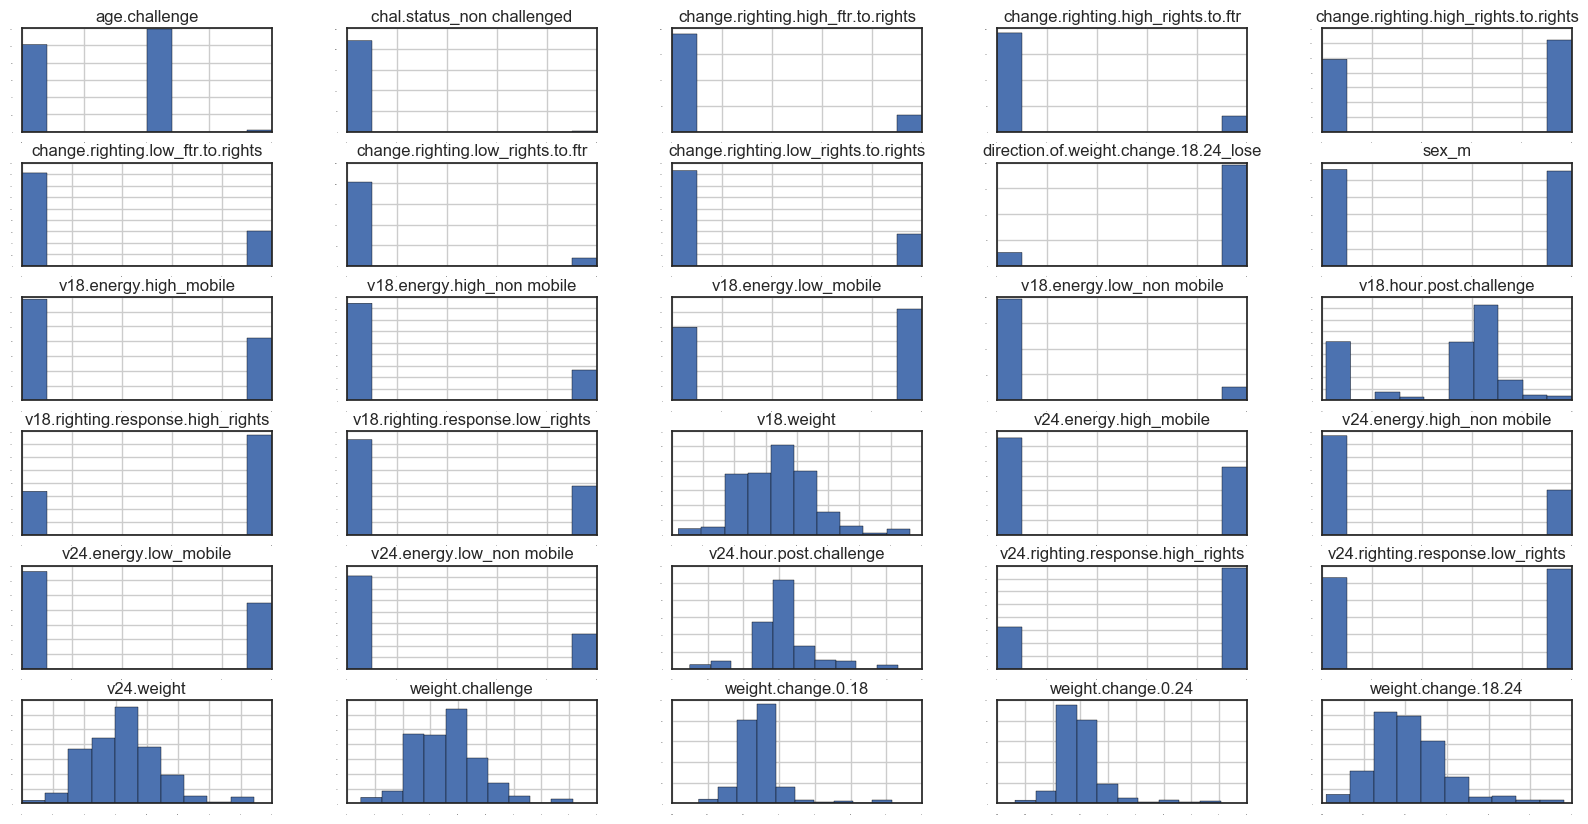

In [33]:
# histograms
df_encoded.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.show()

Because we have a lot of features that are 0/1 we don't get much out of this plot, except that all features/attributes related to `weight` seem to have a gaussian like distribution

### Multimodal Data Visualization

Let's see if we have attributes that correlate

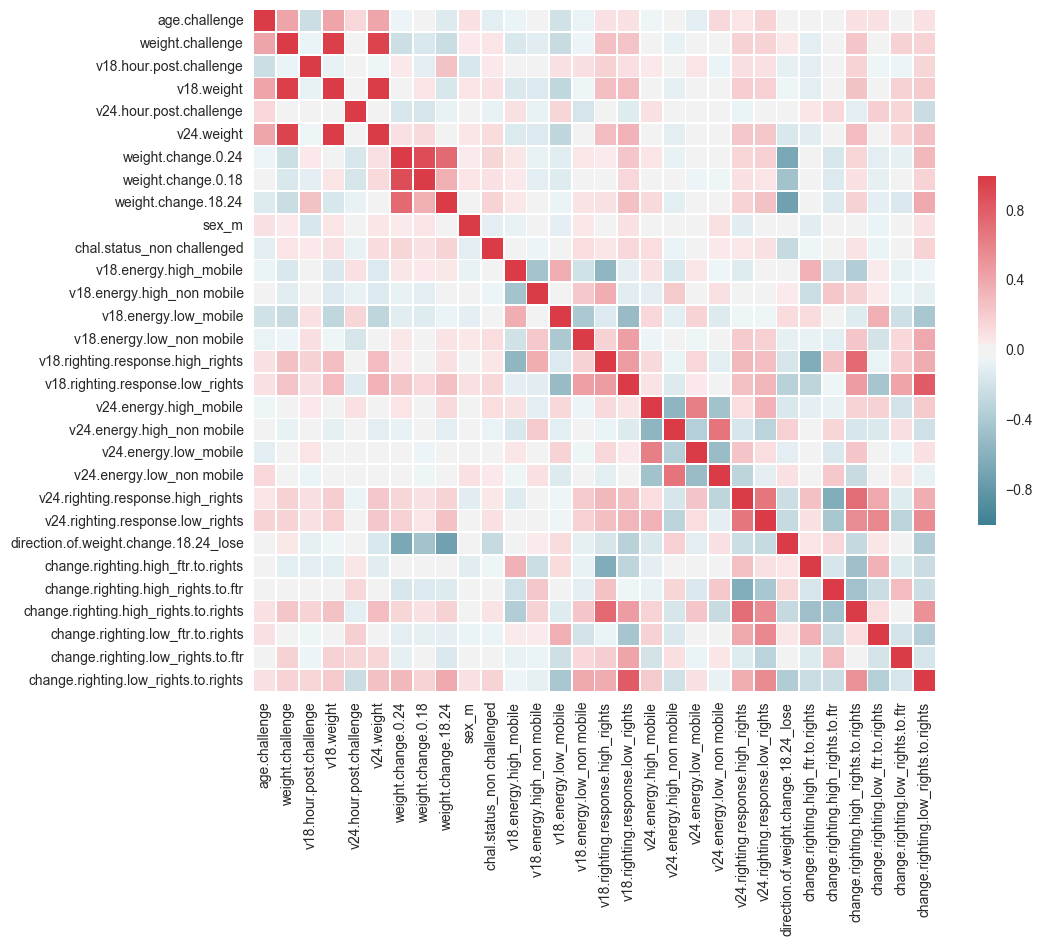

In [34]:
correlations = df_encoded.corr(method='pearson')
correlations

# Plot Correlations
corr = df_encoded.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#for tick in ax.get_xticklabels():
#    tick.set_rotation(90)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

As we can see we have a lot of diagonals in this dataset, which means not all these features are going to be included in the dataset as we have a lot of correlations

We can already spot some positive correlation between the weight and the hours post challenges even if it is a slightly positive (not a strong correlation judging by the colors).

The top left corner seems to have some useful information

Not all the algorithms deal with correlated features equally. Some algorithms like Naive Bayes assumes attributes independence, so it may behaves in an unexpected way, some other approaches like Support Vector Machines care about it much less.

One thing we can do here, is to take the decision to reduce the number of attributes by doing a **Principal Component Aanalysis**, squeezing features that are part of the same components, transform the original dataset and see what this will give us.

But first of all we will need to start doing some transformation to make sure we have all the features included, not only the numerical ones, so we will have to do some transformations.

Let's list all the features we have so far.


In [36]:
outcome = df_encoded.outcome

In [39]:
X = df_encoded.drop('outcome',1)

In [40]:
X.head()

age.challenge  weight.challenge  v18.hour.post.challenge  v18.weight  \
0              8              4.76                    16.93       4.625   
1              8              4.54                    16.93       4.435   
2              8              4.54                    16.93       4.370   
3              9              5.91                    16.33       5.805   
4              9              6.06                    16.33       5.640   

   v24.hour.post.challenge  v24.weight  weight.change.0.24  \
0                    23.93        4.50               -0.26   
1                    23.93        4.32               -0.22   
2                    23.93        4.24               -0.30   
3                    21.50        5.71               -0.20   
4                    21.50        5.39               -0.67   

   weight.change.0.18  weight.change.18.24  sex_m  chal.status_non challenged  \
0              -0.135               -0.125    1.0                         0.0   
1              -0.105               -0.115    1.0                         0.0   
2              -0.170               -0.130    0.0                         0.0   
3              -0.105               -0.095    1.0                         0.0   
4              -0.420               -0.250    0.0                         0.0   

   v18.energy.high_mobile  v18.energy.high_non mobile  v18.energy.low_mobile  \
0                     1.0                         0.0                    1.0   
1                     0.0                         0.0                    0.0   
2                     0.0                         0.0                    1.0   
3                     0.0                         0.0                    0.0   
4                     0.0                         0.0                    0.0   

   v18.energy.low_non mobile  v18.righting.response.high_rights  \
0                        0.0                                0.0   
1                        0.0                                1.0   
2                        0.0                                1.0   
3                        0.0                                1.0   
4                        0.0                                1.0   

   v18.righting.response.low_rights  v24.energy.high_mobile  \
0                               0.0                     0.0   
1                               1.0                     0.0   
2                               0.0                     1.0   
3                               1.0                     1.0   
4                               1.0                     1.0   

   v24.energy.high_non mobile  v24.energy.low_mobile  \
0                         0.0                    0.0   
1                         0.0                    0.0   
2                         0.0                    1.0   
3                         0.0                    1.0   
4                         0.0                    1.0   

   v24.energy.low_non mobile  v24.righting.response.high_rights  \
0                        0.0                                1.0   
1                        1.0                                0.0   
2                        0.0                                1.0   
3                        0.0                                1.0   
4                        0.0                                1.0   

   v24.righting.response.low_rights  direction.of.weight.change.18.24_lose  \
0                               1.0                                    1.0   
1                               0.0                                    1.0   
2                               1.0                                    1.0   
3                               1.0                                    1.0   
4                               1.0                                    1.0   

   change.righting.high_ftr.to.rights  change.righting.high_rights.to.ftr  \
0                                 1.0                                 0.0   
1                                 0.0                             

In [80]:
zip(outcome, pd.factorize(outcome)[0])

[('die', 0),
 ('die', 0),
 ('live', 1),
 ('live', 1),
 ('live', 1),
 ('die', 0),
 ('die', 0),
 ('live', 1),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('live', 1),
 ('die', 0),
 ('live', 1),
 ('live', 1),
 ('die', 0),
 ('die', 0),
 ('live', 1),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('live', 1),
 ('live', 1),
 ('live', 1),
 ('die', 0),
 ('live', 1),
 ('die', 0),
 ('live', 1),
 ('live', 1),
 ('die', 0),
 ('live', 1),
 ('live', 1),
 ('live', 1),
 ('live', 1),
 ('live', 1),
 ('live', 1),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('live', 1),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('live', 1),
 ('live', 1),
 ('die', 0),
 ('live', 1),
 ('live', 1),
 ('live', 1),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('die', 0),
 ('live', 1),
 ('live', 1),
 ('live', 1),
 ('live', 1),
 ('live', 1),
 ('live', 1),
 ('live', 1),
 ('die', 0),
 ('di

In [161]:
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
 
X2 = df_encoded.drop('outcome',1)
y2 = pd.factorize(df_encoded['outcome'])[0]
names = X2.columns
 
rf = RandomForestRegressor(n_estimators=20, max_depth=4)
scores = []
for i in range(X2.shape[1]):
     score = cross_val_score(rf, X2.values[:, i:i+1], y2, scoring="r2", cv=4)
     scores.append((round(np.mean(score), 3), names[i]))
print sorted(scores, reverse=True)

[(0.366, 'v24.righting.response.low_rights'), (0.322, 'v24.righting.response.high_rights'), (0.187, 'change.righting.high_rights.to.rights'), (0.183, 'change.righting.low_rights.to.rights'), (0.139, 'v24.energy.high_non mobile'), (0.106, 'change.righting.high_rights.to.ftr'), (0.095, 'v24.energy.high_mobile'), (0.09, 'direction.of.weight.change.18.24_lose'), (0.065, 'v24.energy.low_mobile'), (0.059, 'weight.change.18.24'), (0.03, 'v24.energy.low_non mobile'), (0.022, 'weight.change.0.24'), (0.013, 'v18.righting.response.low_rights'), (0.007, 'v18.righting.response.high_rights'), (0.003, 'change.righting.low_rights.to.ftr'), (-0.024, 'change.righting.low_ftr.to.rights'), (-0.036, 'v18.energy.low_non mobile'), (-0.046, 'chal.status_non challenged'), (-0.055, 'v18.energy.high_non mobile'), (-0.057, 'change.righting.high_ftr.to.rights'), (-0.063, 'v18.energy.high_mobile'), (-0.066, 'v18.energy.low_mobile'), (-0.073, 'weight.challenge'), (-0.08, 'v18.hour.post.challenge'), (-0.085, 'sex_m')

Feature ranking:
1. feature 22 (0.143685)
2. feature 21 (0.108785)
3. feature 18 (0.075039)
4. feature 26 (0.049447)
5. feature 29 (0.045830)
6. feature 17 (0.043171)
7. feature 19 (0.039344)
8. feature 8 (0.039108)
9. feature 4 (0.036291)
10. feature 6 (0.035621)
11. feature 1 (0.034327)
12. feature 5 (0.032741)
13. feature 3 (0.031979)
14. feature 2 (0.031254)
15. feature 7 (0.030041)
16. feature 23 (0.028202)
17. feature 27 (0.023523)
18. feature 0 (0.021944)
19. feature 24 (0.021139)
20. feature 9 (0.017525)
21. feature 13 (0.015207)
22. feature 25 (0.015127)
23. feature 20 (0.014165)
24. feature 12 (0.014090)
25. feature 11 (0.013410)
26. feature 16 (0.012530)
27. feature 28 (0.010305)
28. feature 15 (0.009958)
29. feature 14 (0.006091)
30. feature 10 (0.000119)


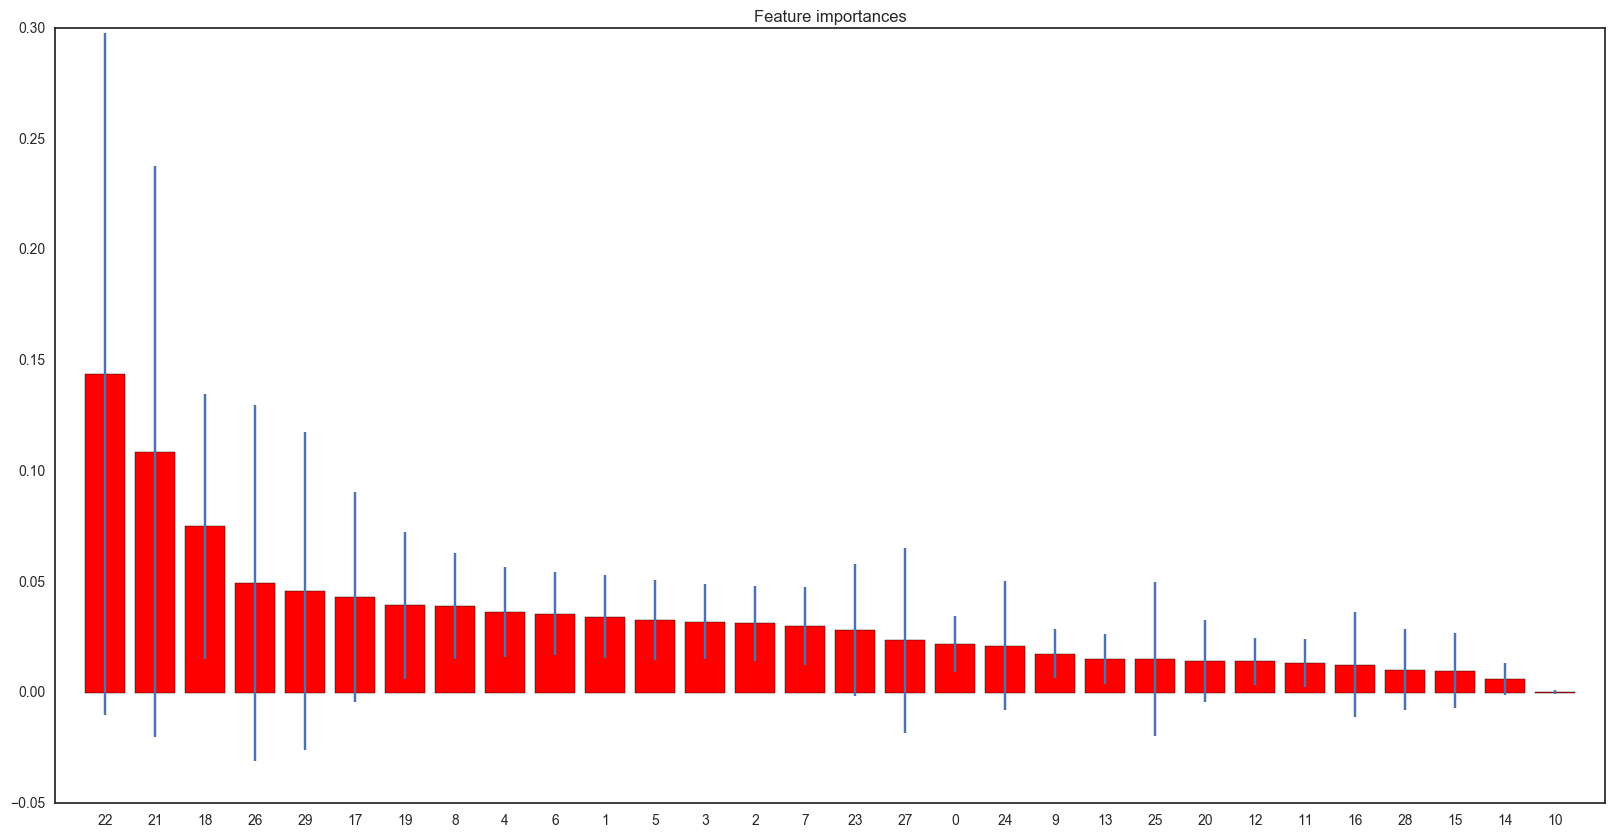

In [194]:

import numpy as np
import matplotlib.pyplot as plt

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=1000,
                              random_state=0)

forest.fit(X2, y2)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X2.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X2.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X2.shape[1]), indices)
plt.xlim([-1, X2.shape[1]])
plt.show()

In [177]:
list(X2)

['age.challenge',
 'weight.challenge',
 'v18.hour.post.challenge',
 'v18.weight',
 'v24.hour.post.challenge',
 'v24.weight',
 'weight.change.0.24',
 'weight.change.0.18',
 'weight.change.18.24',
 'sex_m',
 'chal.status_non challenged',
 'v18.energy.high_mobile',
 'v18.energy.high_non mobile',
 'v18.energy.low_mobile',
 'v18.energy.low_non mobile',
 'v18.righting.response.high_rights',
 'v18.righting.response.low_rights',
 'v24.energy.high_mobile',
 'v24.energy.high_non mobile',
 'v24.energy.low_mobile',
 'v24.energy.low_non mobile',
 'v24.righting.response.high_rights',
 'v24.righting.response.low_rights',
 'direction.of.weight.change.18.24_lose',
 'change.righting.high_ftr.to.rights',
 'change.righting.high_rights.to.ftr',
 'change.righting.high_rights.to.rights',
 'change.righting.low_ftr.to.rights',
 'change.righting.low_rights.to.ftr',
 'change.righting.low_rights.to.rights']

In [220]:
# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

# split data into train and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X, Y, test_size=0.33, random_state=7)
# fit model on all training data
model = XGBClassifier()
model.fit(X2_train, y2_train)
# make predictions for test data and evaluate
y2_pred = model.predict(X2_test)
predictions = [round(value) for value in y2_pred]
accuracy = accuracy_score(y2_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X2_train = selection.transform(X2_train)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X2_train, y2_train)
	# eval model
	select_X2_test = selection.transform(X2_test)
	y2_pred = selection_model.predict(select_X2_test)
	predictions = [round(value) for value in y2_pred]
	accuracy = accuracy_score(y2_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X2_train.shape[1], accuracy*100.0))bb

Accuracy: 93.24%
Thresh=0.000, n=30, Accuracy: 93.24%
Thresh=0.000, n=30, Accuracy: 93.24%
Thresh=0.000, n=30, Accuracy: 93.24%
Thresh=0.000, n=30, Accuracy: 93.24%
Thresh=0.000, n=30, Accuracy: 93.24%
Thresh=0.000, n=30, Accuracy: 93.24%
Thresh=0.000, n=30, Accuracy: 93.24%
Thresh=0.000, n=30, Accuracy: 93.24%
Thresh=0.002, n=22, Accuracy: 93.24%
Thresh=0.002, n=22, Accuracy: 93.24%
Thresh=0.004, n=20, Accuracy: 91.89%
Thresh=0.006, n=19, Accuracy: 91.89%
Thresh=0.012, n=18, Accuracy: 94.59%
Thresh=0.012, n=18, Accuracy: 94.59%
Thresh=0.014, n=16, Accuracy: 94.59%
Thresh=0.026, n=15, Accuracy: 94.59%
Thresh=0.032, n=14, Accuracy: 93.24%
Thresh=0.034, n=13, Accuracy: 94.59%
Thresh=0.039, n=12, Accuracy: 94.59%
Thresh=0.045, n=11, Accuracy: 94.59%
Thresh=0.047, n=10, Accuracy: 91.89%
Thresh=0.049, n=9, Accuracy: 90.54%
Thresh=0.049, n=9, Accuracy: 90.54%
Thresh=0.053, n=7, Accuracy: 75.68%
Thresh=0.053, n=7, Accuracy: 75.68%
Thresh=0.063, n=5, Accuracy: 74.32%
Thresh=0.065, n=4, Accurac

In [221]:
model = XGBClassifier()
model.fit(X2_train, y2_train)
selection = SelectFromModel(model, threshold=0, prefit=True)
select_X2_train = selection.transform(X2_train)

# Predicting outcome WITHOUT feature selection

In [81]:
X = df_encoded.drop('outcome',1)
y = pd.factorize(outcome)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [53]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{'die': 71, 'live': 70}

## Base Line Models


In [83]:
from sklearn.learning_curve import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

LR: 0.857619 (0.055958)
LDA: 0.857143 (0.095831)
KNN: 0.821905 (0.107627)
CART: 0.843810 (0.070238)
NB: 0.829524 (0.057688)
SVM: 0.829524 (0.057688)


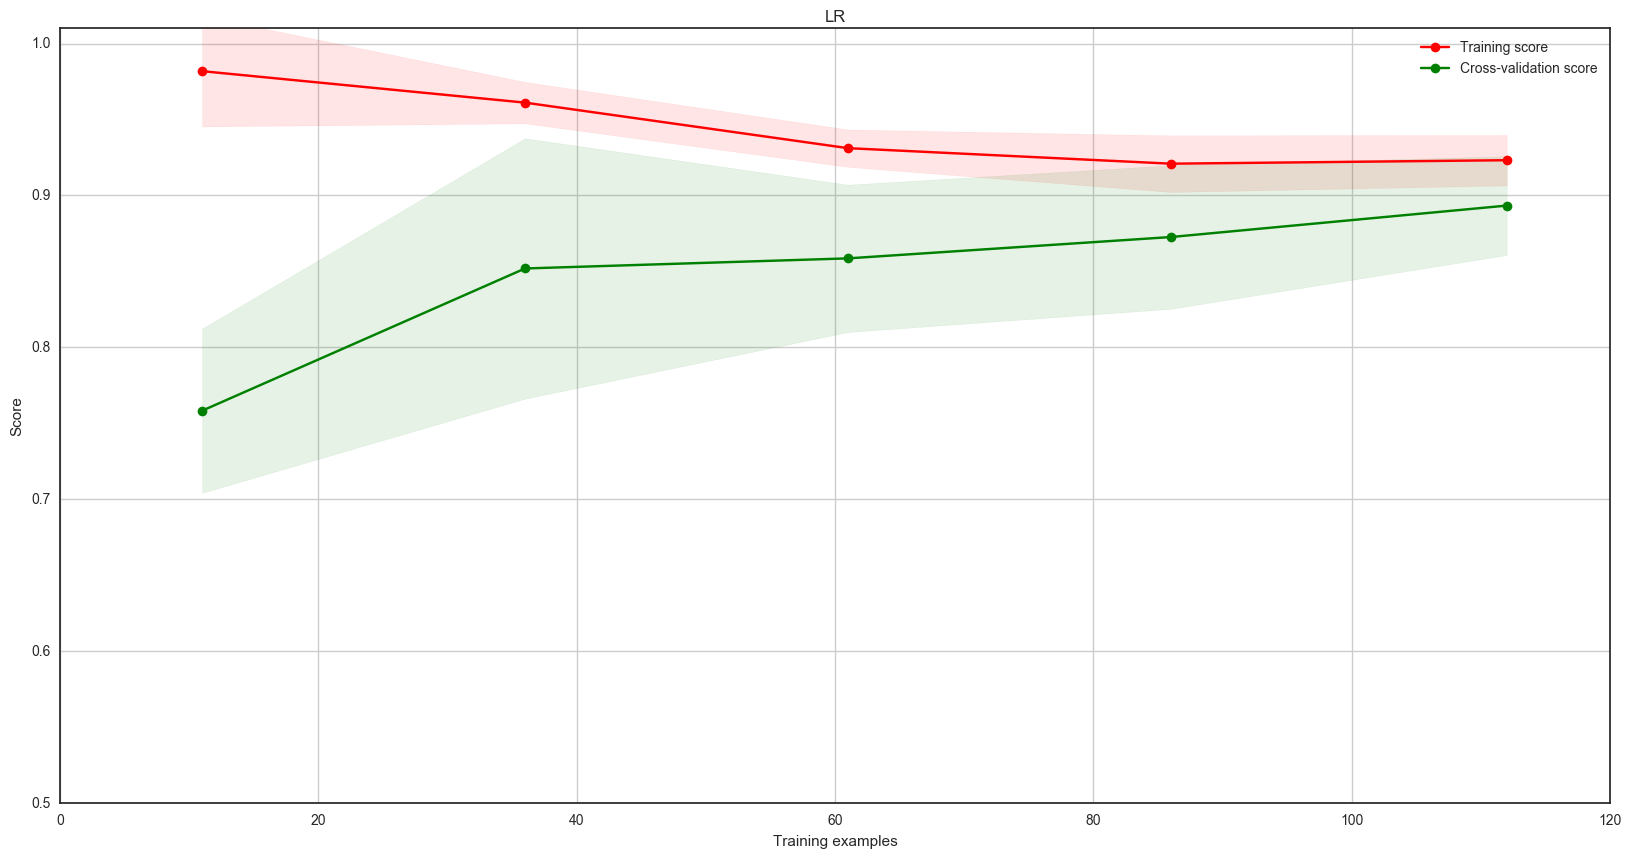

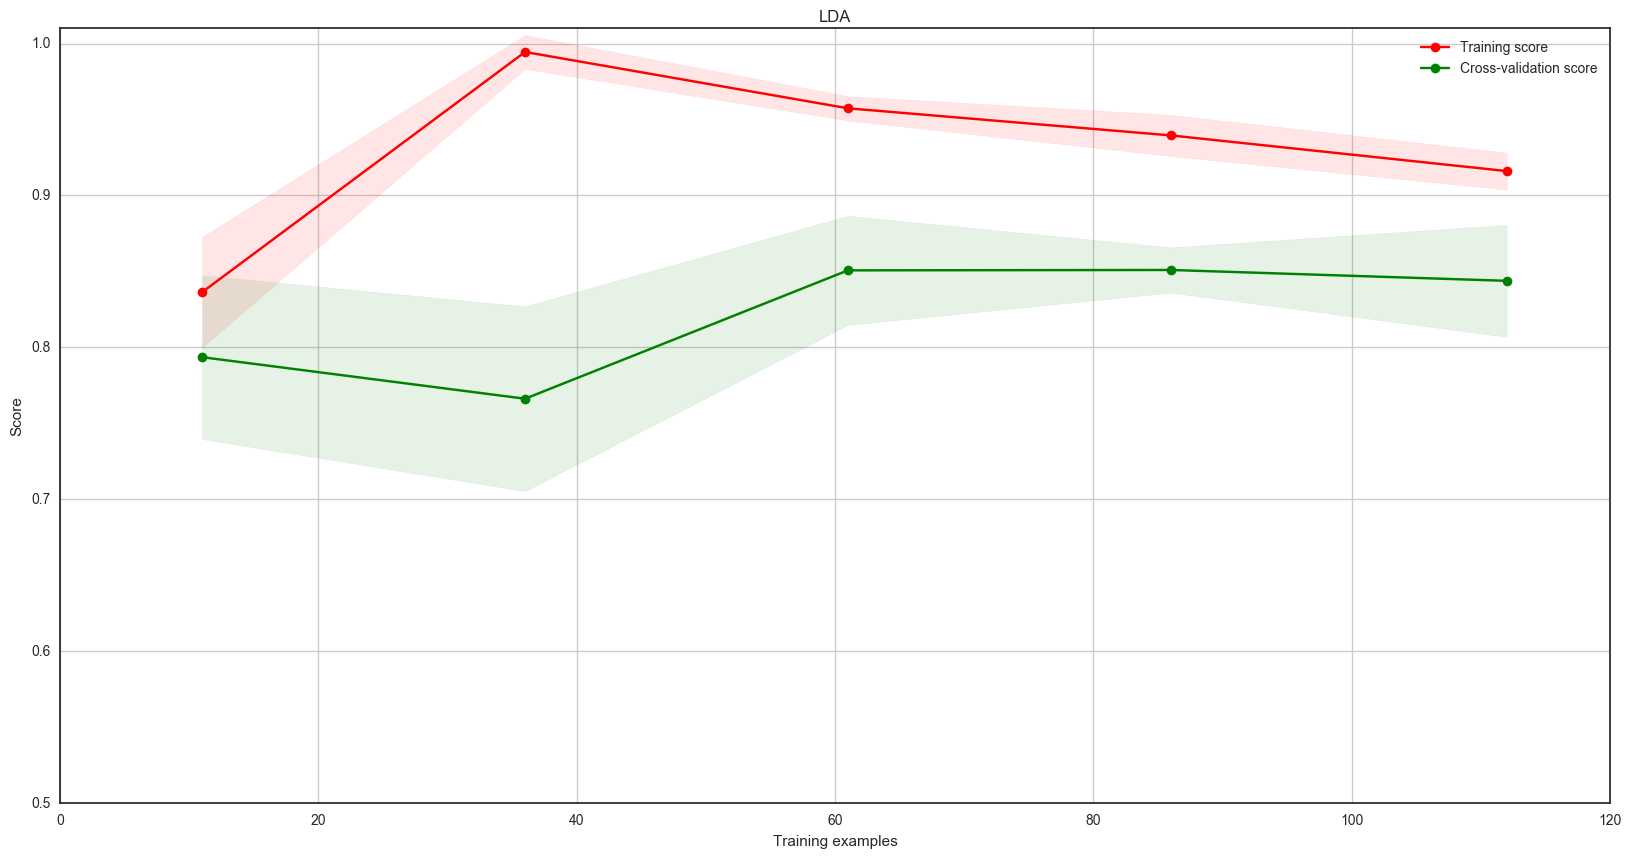

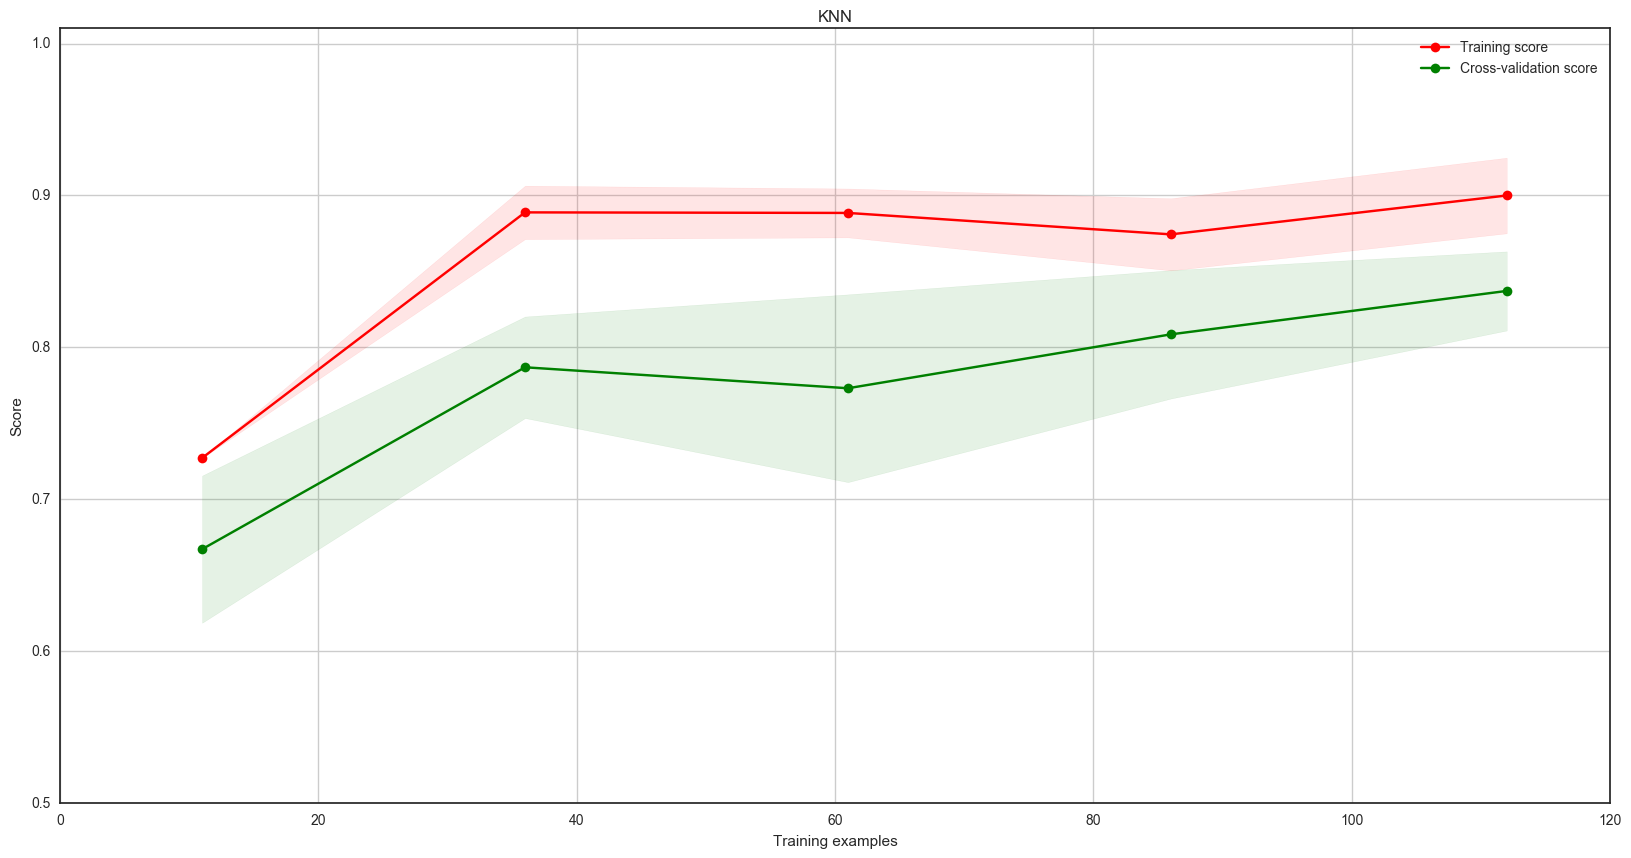

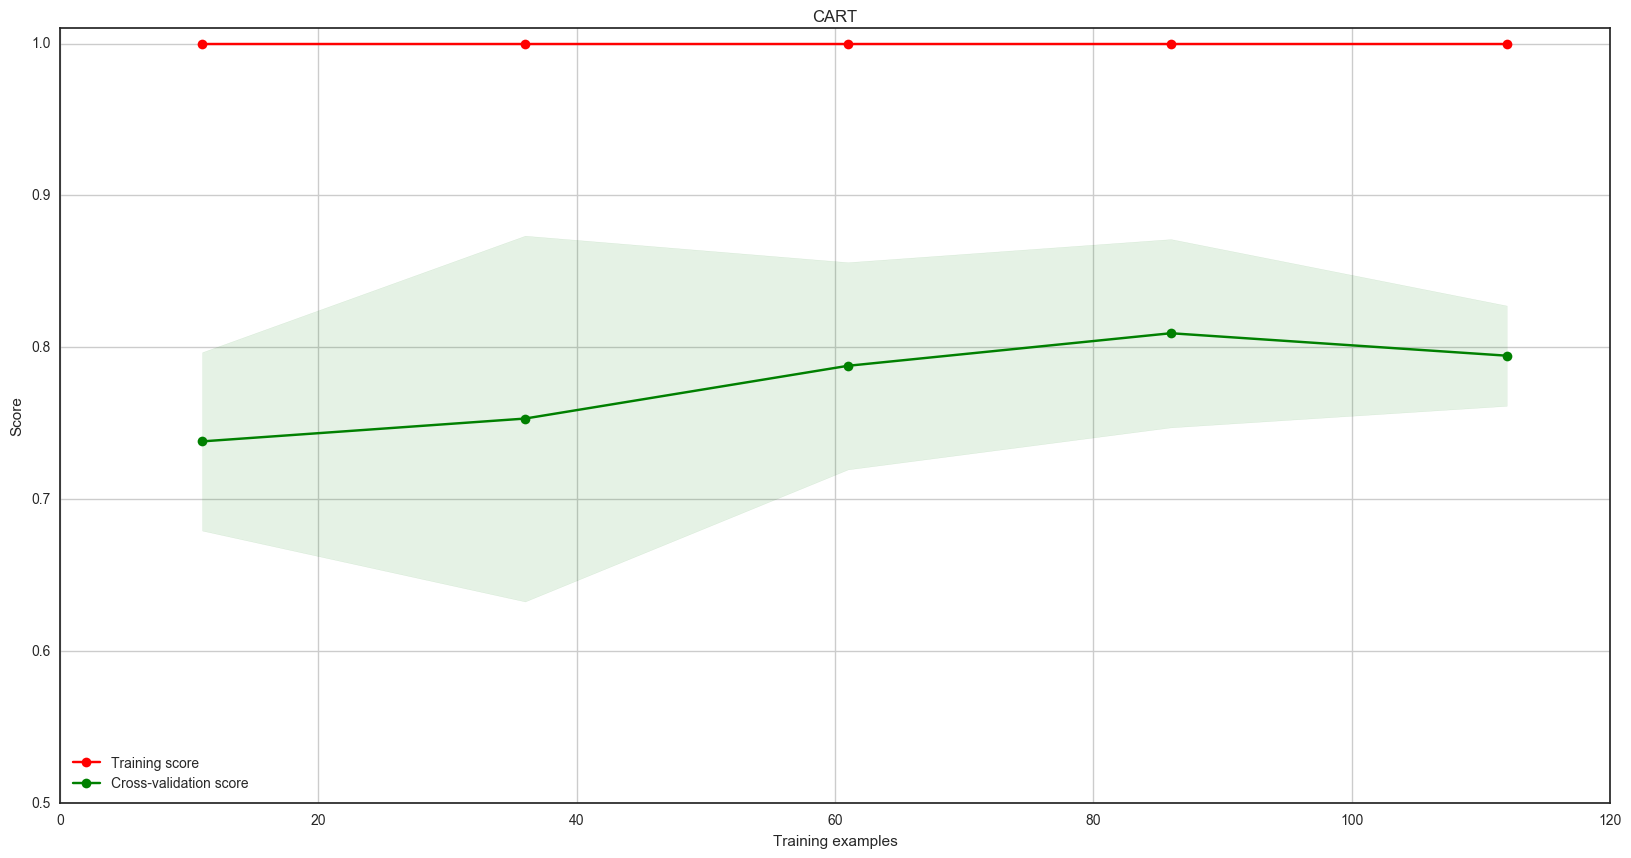

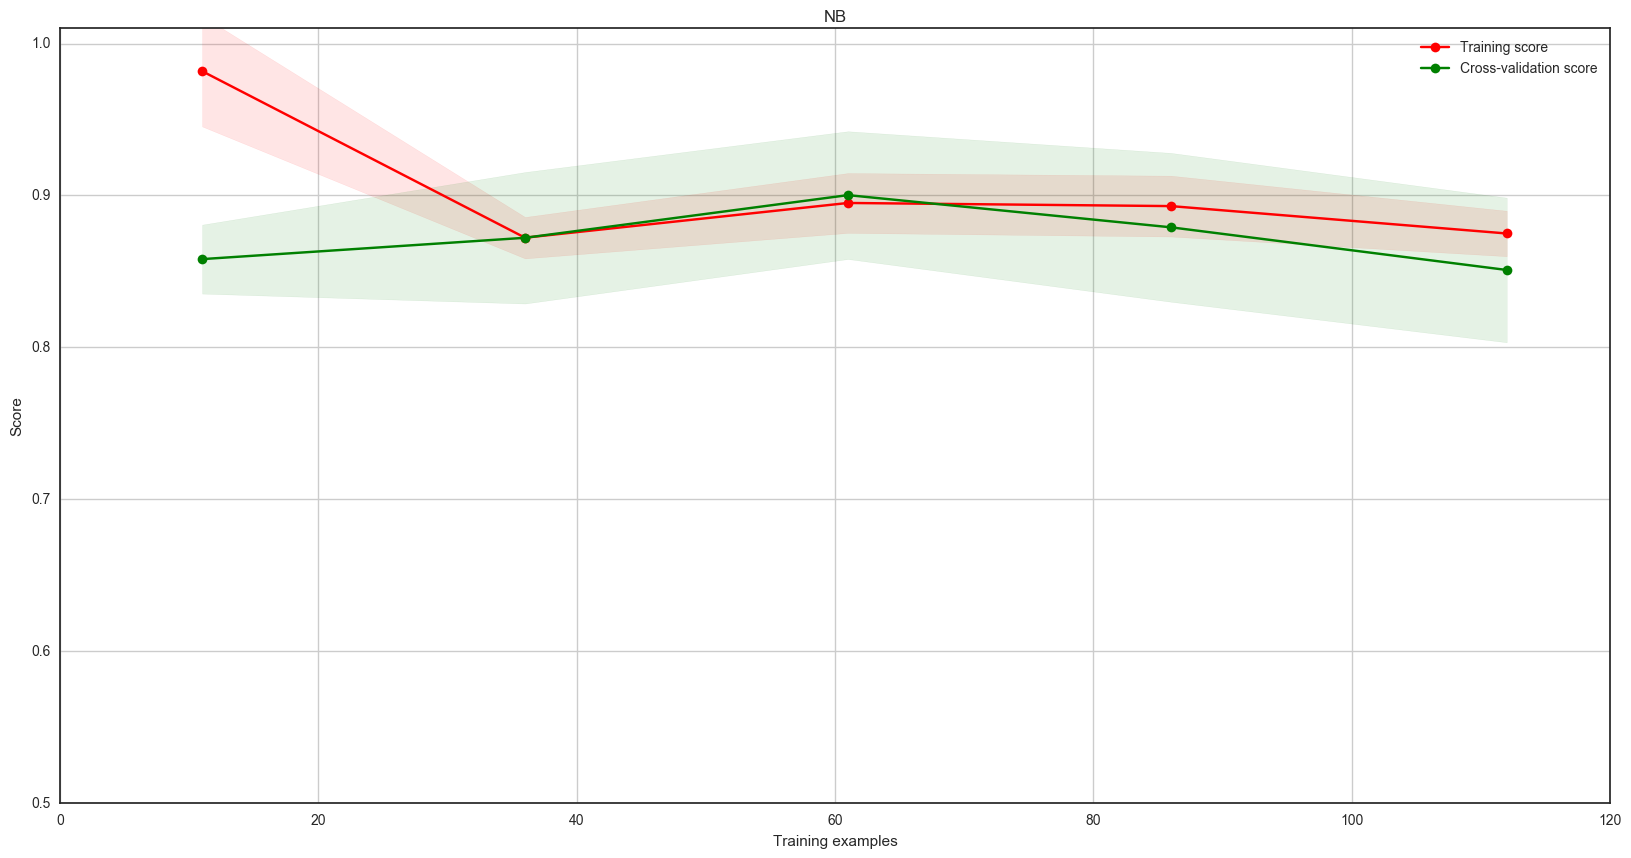

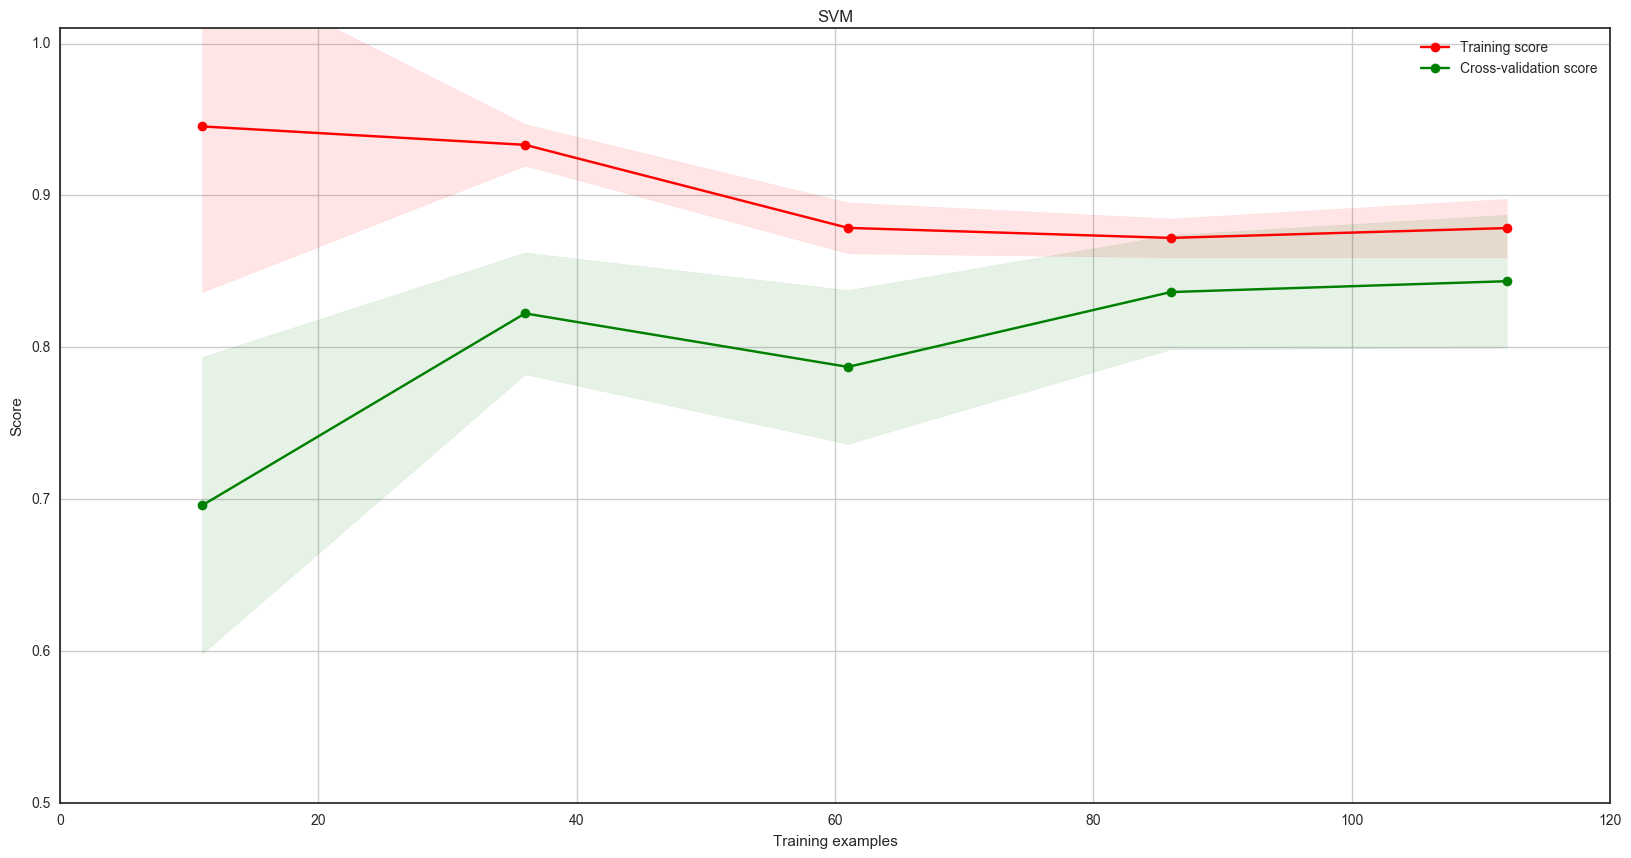

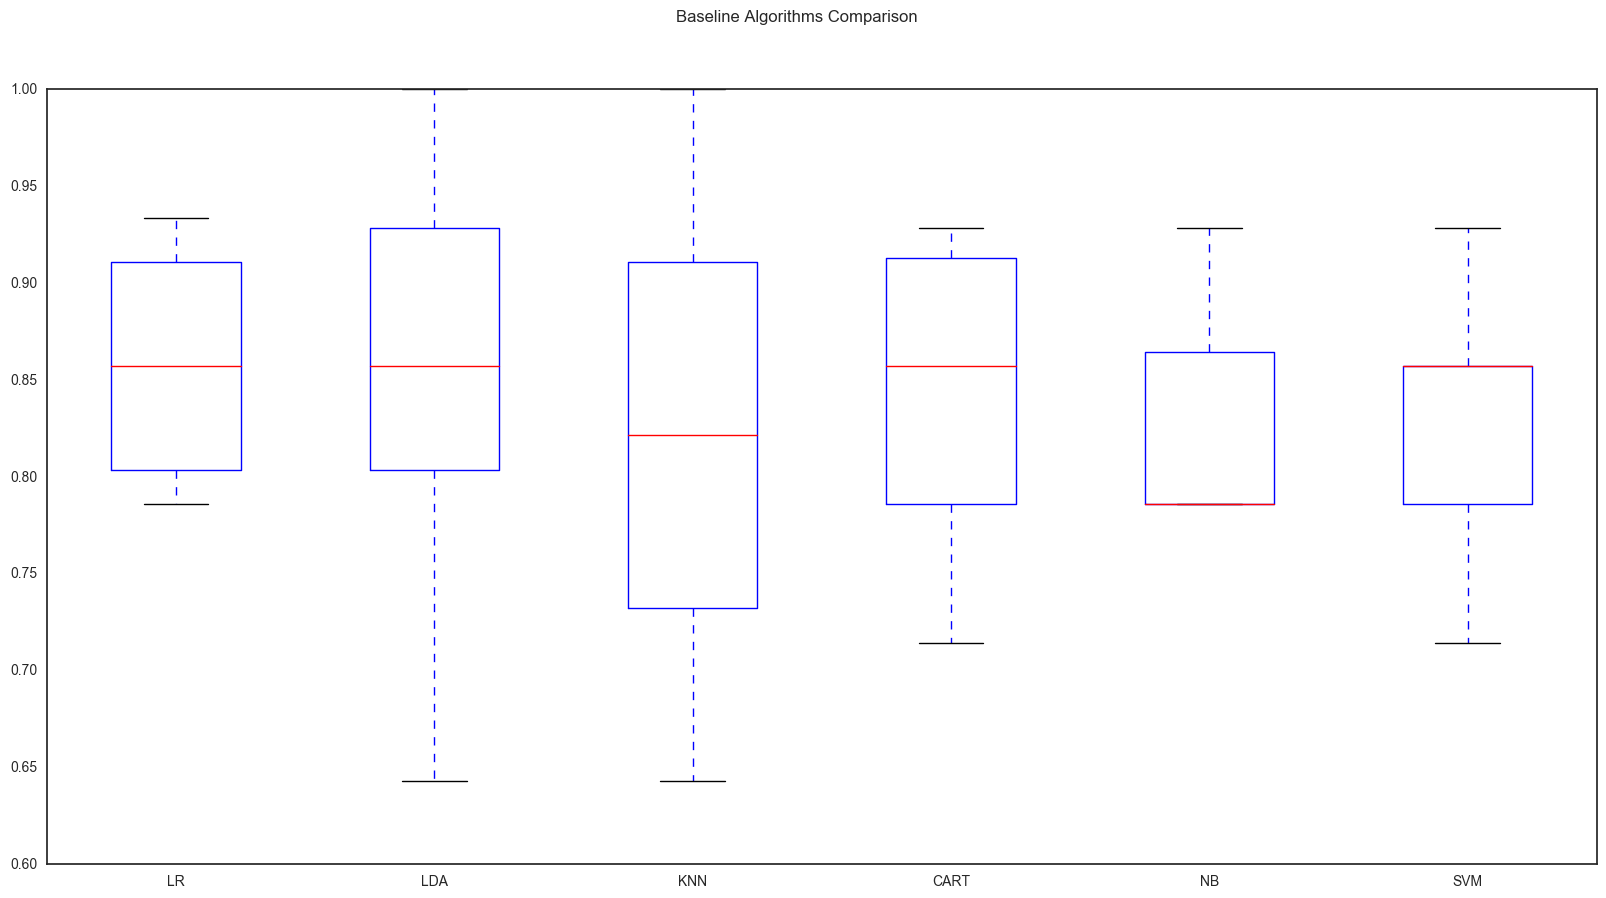

In [84]:
def base_line_models(training_set, outcome):
    # Test options and evaluation metric
    num_folds = 10
    num_instances = len(training_set)
    seed = 7
    scoring = 'accuracy'

    # Spot-Check Algorithms
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))
    results = []
    names = []
    for name, model in models:
        kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        cv_results = cross_validation.cross_val_score(model, training_set, outcome, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        plot_learning_curve(model, name, training_set, outcome, ylim=(0.5, 1.01), cv=10)
    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Baseline Algorithms Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

base_line_models(X_train, y_train)

## Ensemble Models


AB: 0.842857 (0.083299)
GBM: 0.885714 (0.079539)
RF: 0.858095 (0.063952)
ET: 0.871905 (0.053978)
XGB: 0.893333 (0.066127)


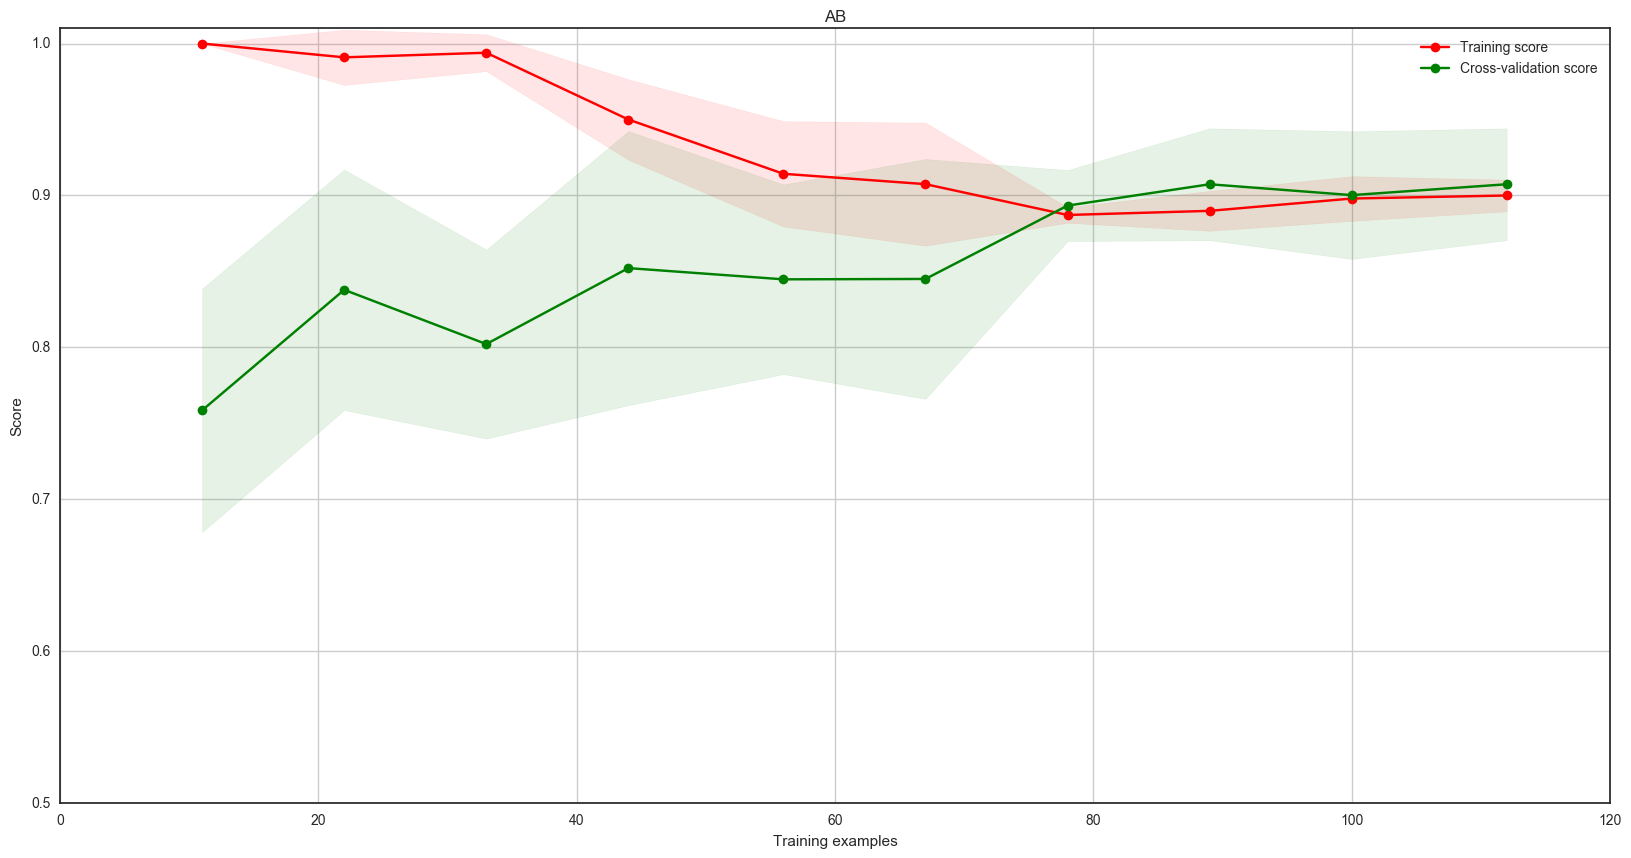

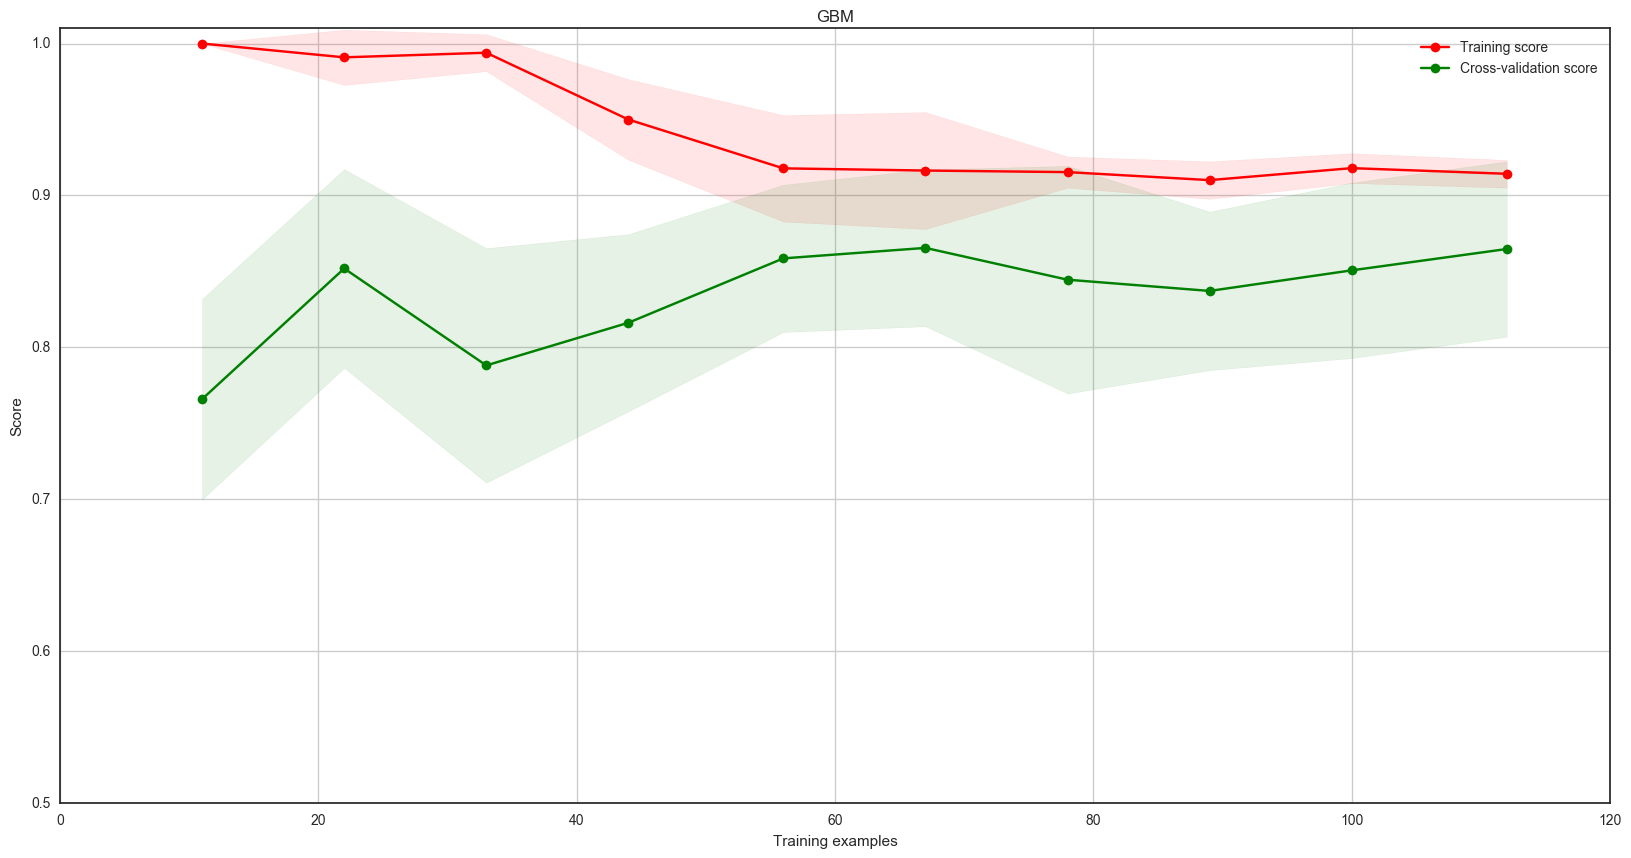

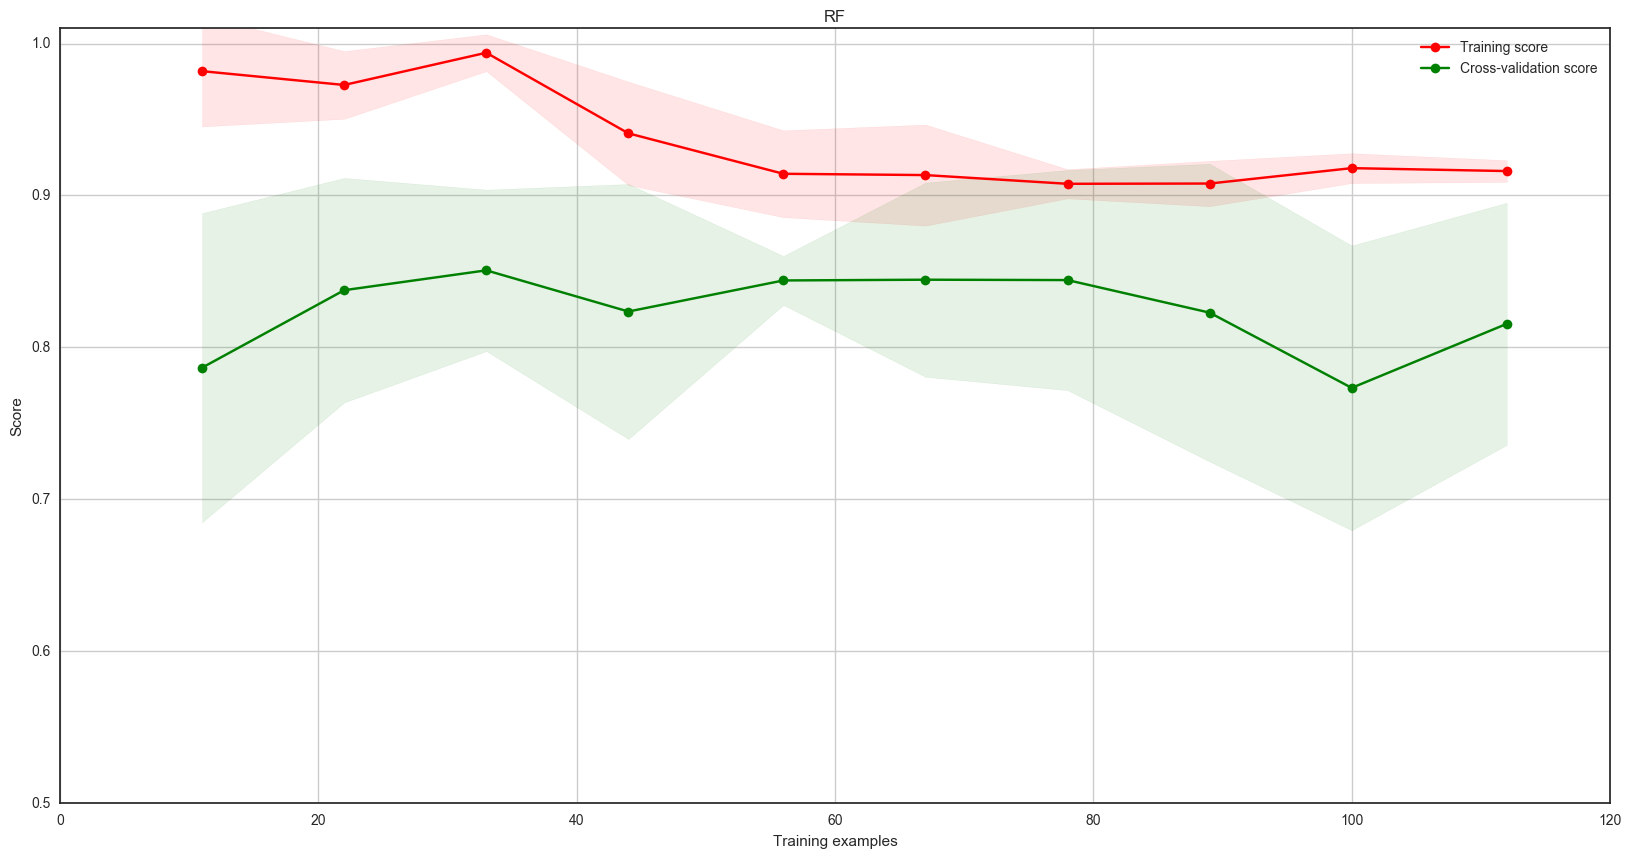

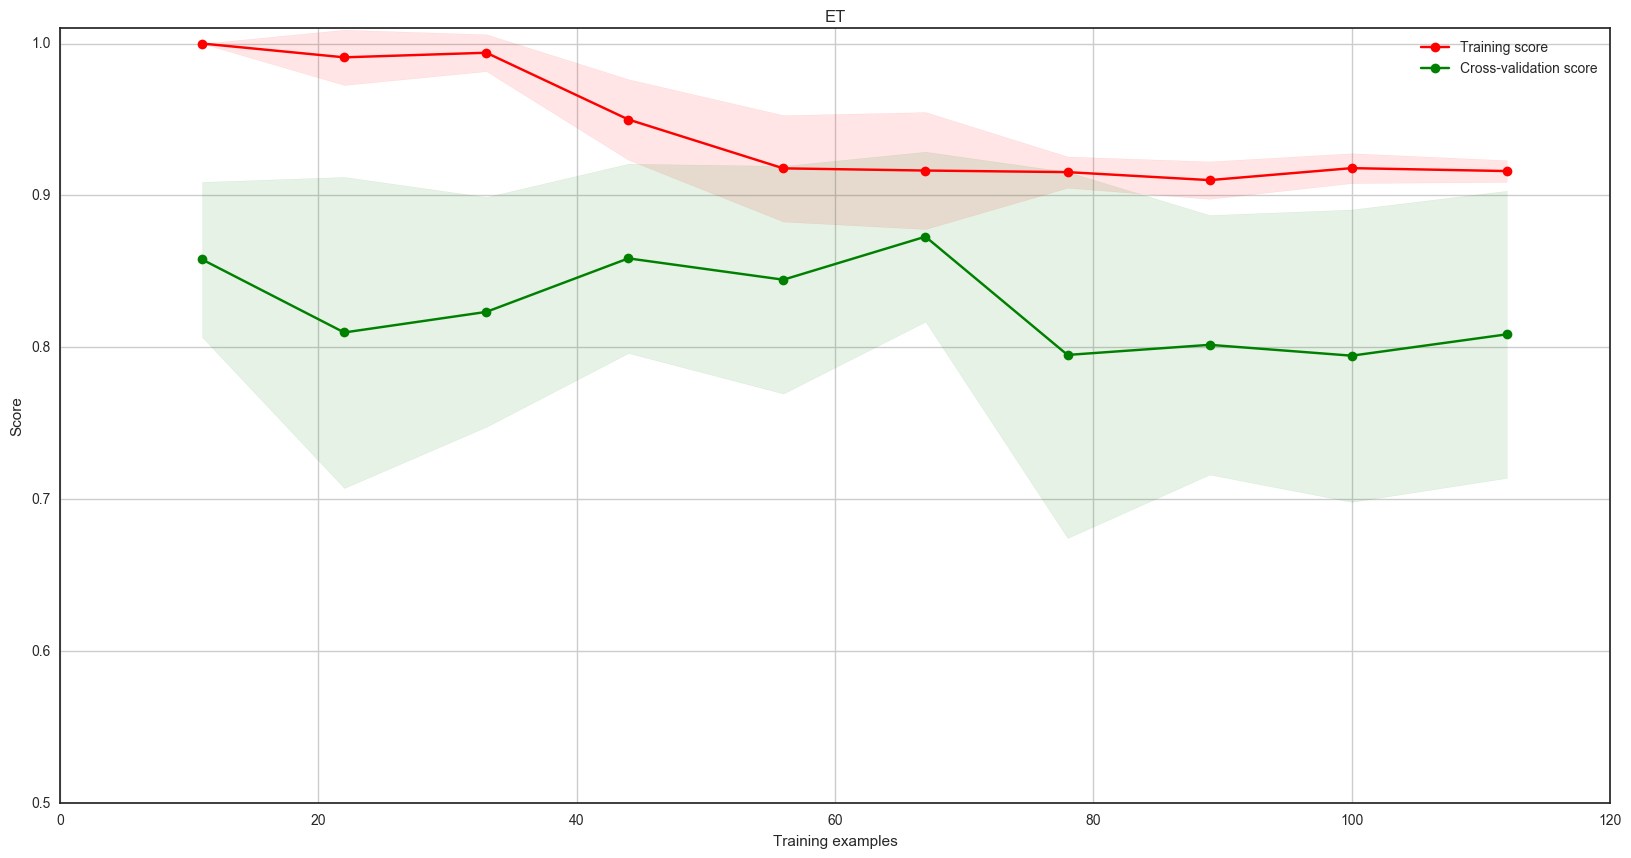

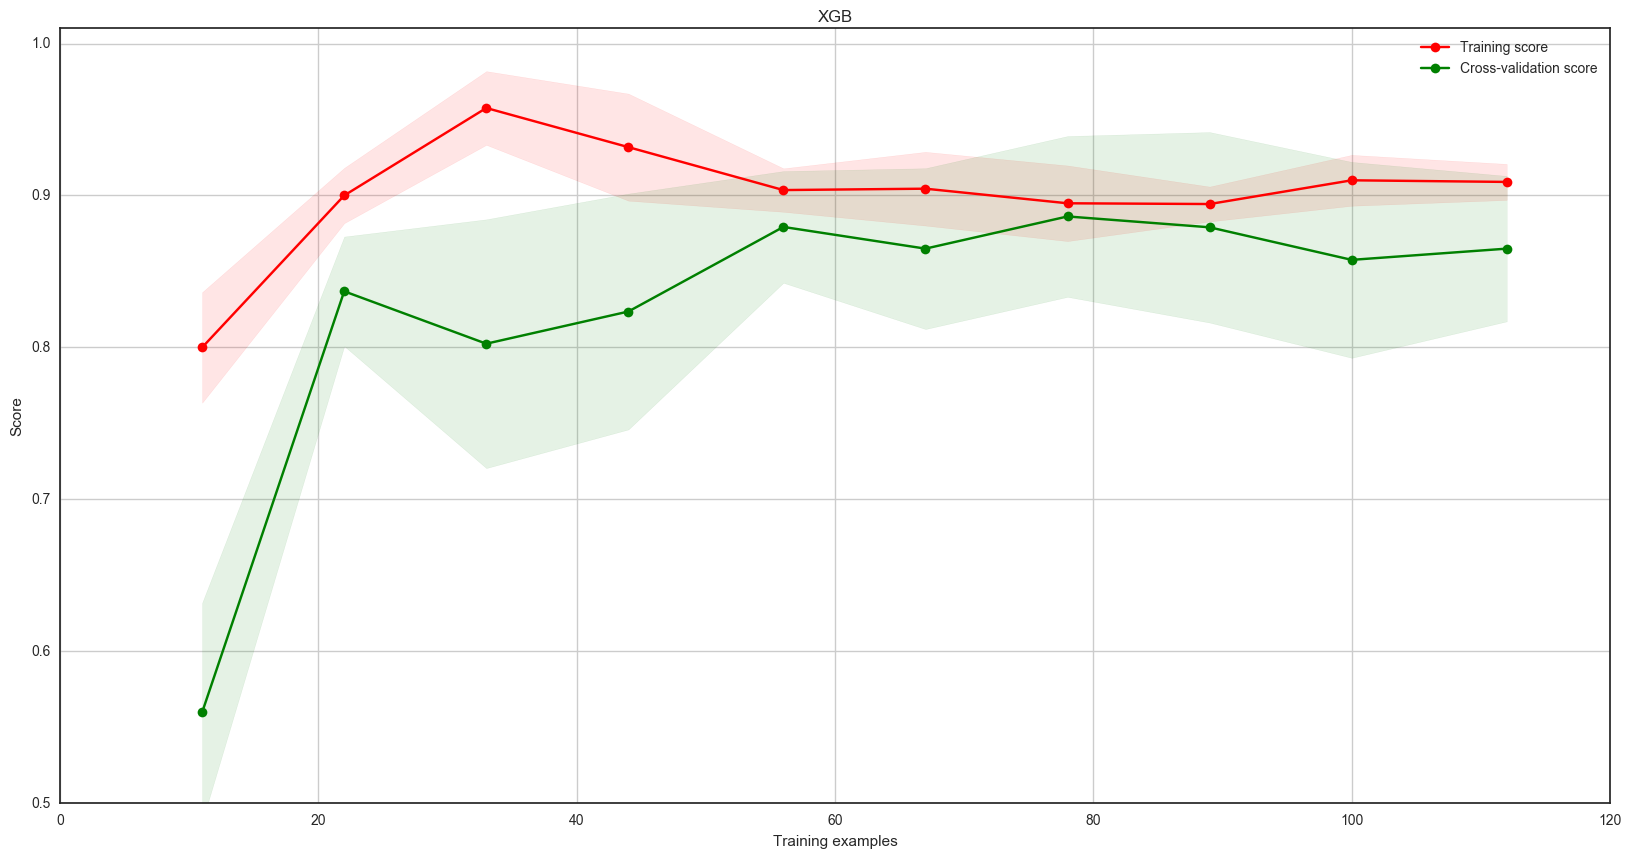

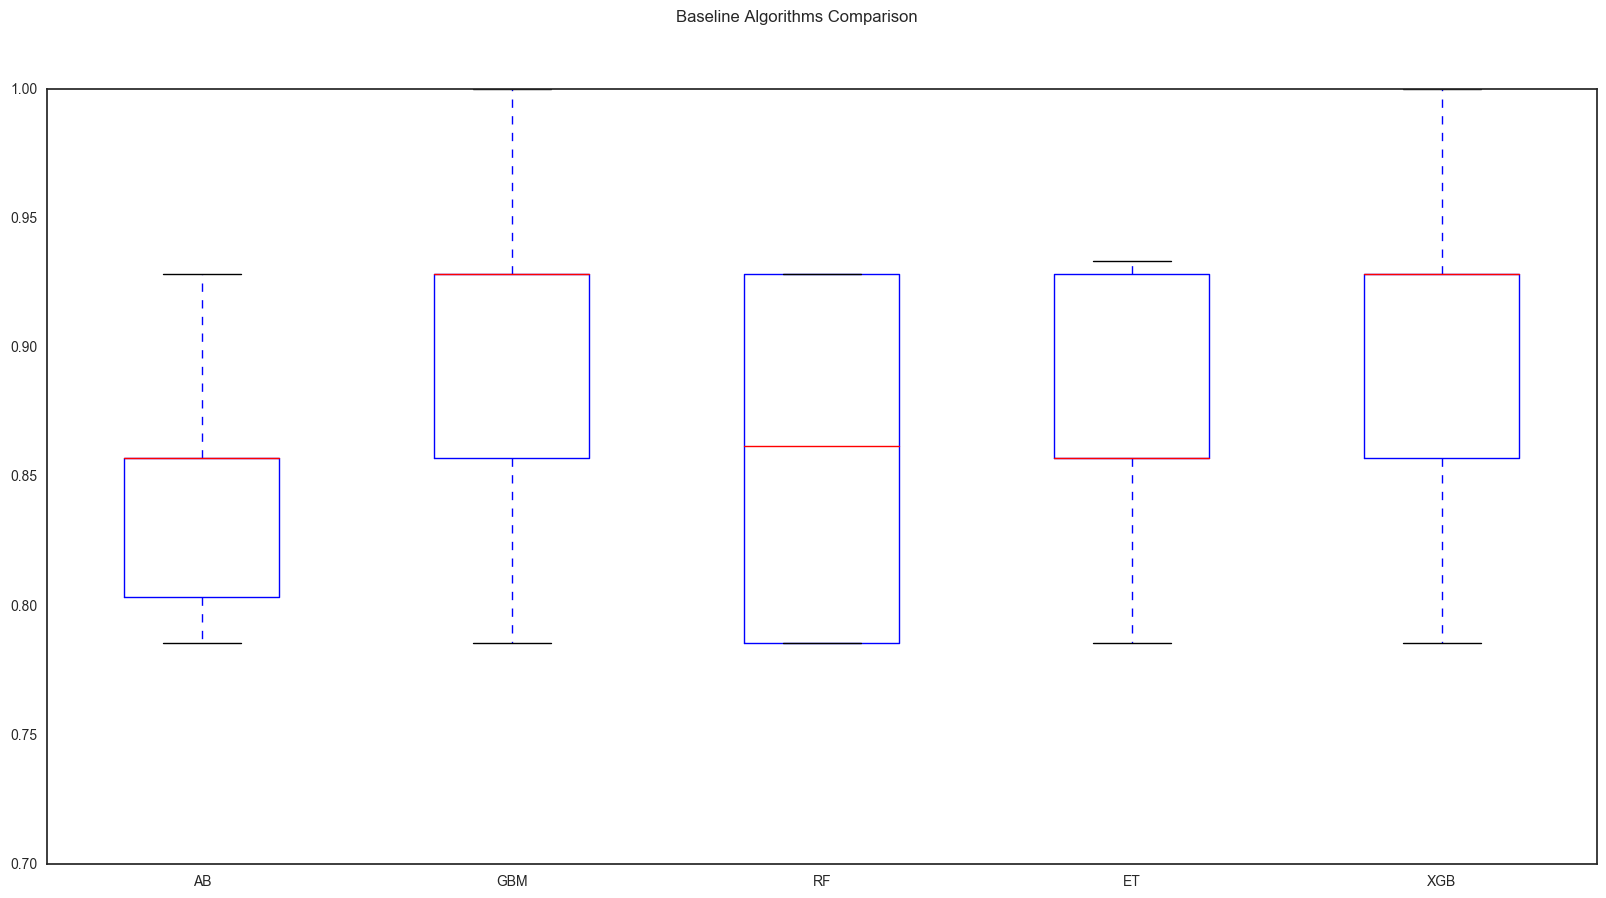

In [85]:
from sklearn.feature_selection import SelectKBest, f_classif

def ensemble_models(training_set, outcome):
    # Test options and evaluation metric
    num_folds = 10
    num_instances = len(training_set)
    seed = 7
    scoring = 'accuracy'

    # ensembles
    ensembles = []
    ensembles.append(('AB', AdaBoostClassifier()))
    ensembles.append(('GBM', GradientBoostingClassifier()))
    ensembles.append(('RF', RandomForestClassifier()))
    ensembles.append(('ET', ExtraTreesClassifier()))
    ensembles.append(('XGB', xgboost.XGBClassifier()))
    results = []
    names = []
    for name, model in ensembles:
        kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        cv_results = cross_validation.cross_val_score(model, training_set, outcome, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        plot_learning_curve(Pipeline([("fs", SelectKBest(f_classif, k=9)), # select two features
                               (name, model)]),
                            name, training_set, outcome, ylim=(0.5, 1.01), train_sizes=np.linspace(0.1, 1.0, 10) , cv=10)

    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Baseline Algorithms Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

ensemble_models(X_train, y_train)

## Model Validations

Validation based on AB
Feature Importance 
[ 0.02  0.02  0.    0.06  0.1   0.02  0.14  0.1   0.2   0.02  0.    0.    0.
  0.    0.    0.    0.    0.02  0.1   0.04  0.    0.06  0.06  0.    0.    0.
  0.02  0.    0.02  0.  ]
0.861111111111
[[14  3]
 [ 2 17]]
[[14  3]
 [ 2 17]]
             precision    recall  f1-score   support

          0       0.88      0.82      0.85        17
          1       0.85      0.89      0.87        19

avg / total       0.86      0.86      0.86        36



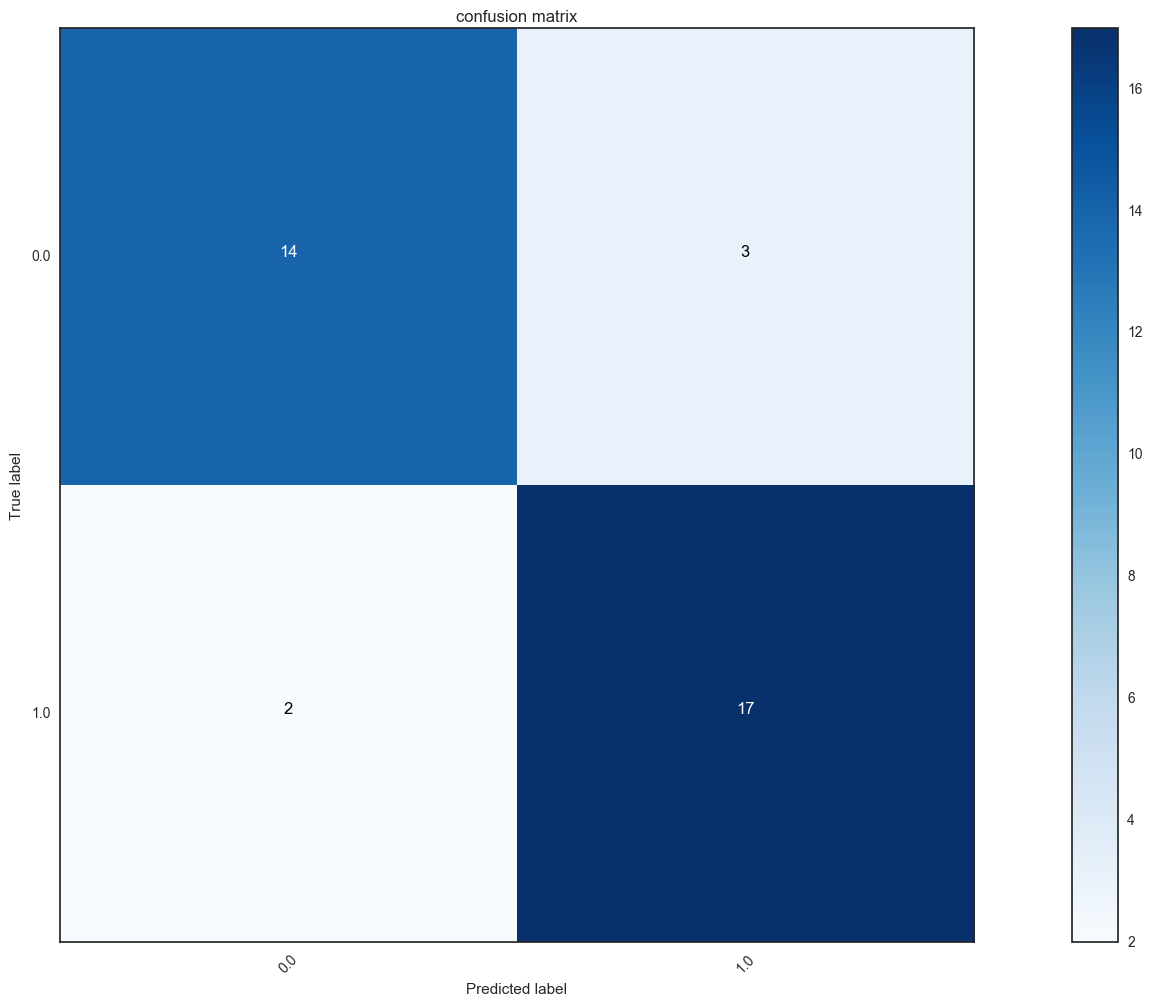

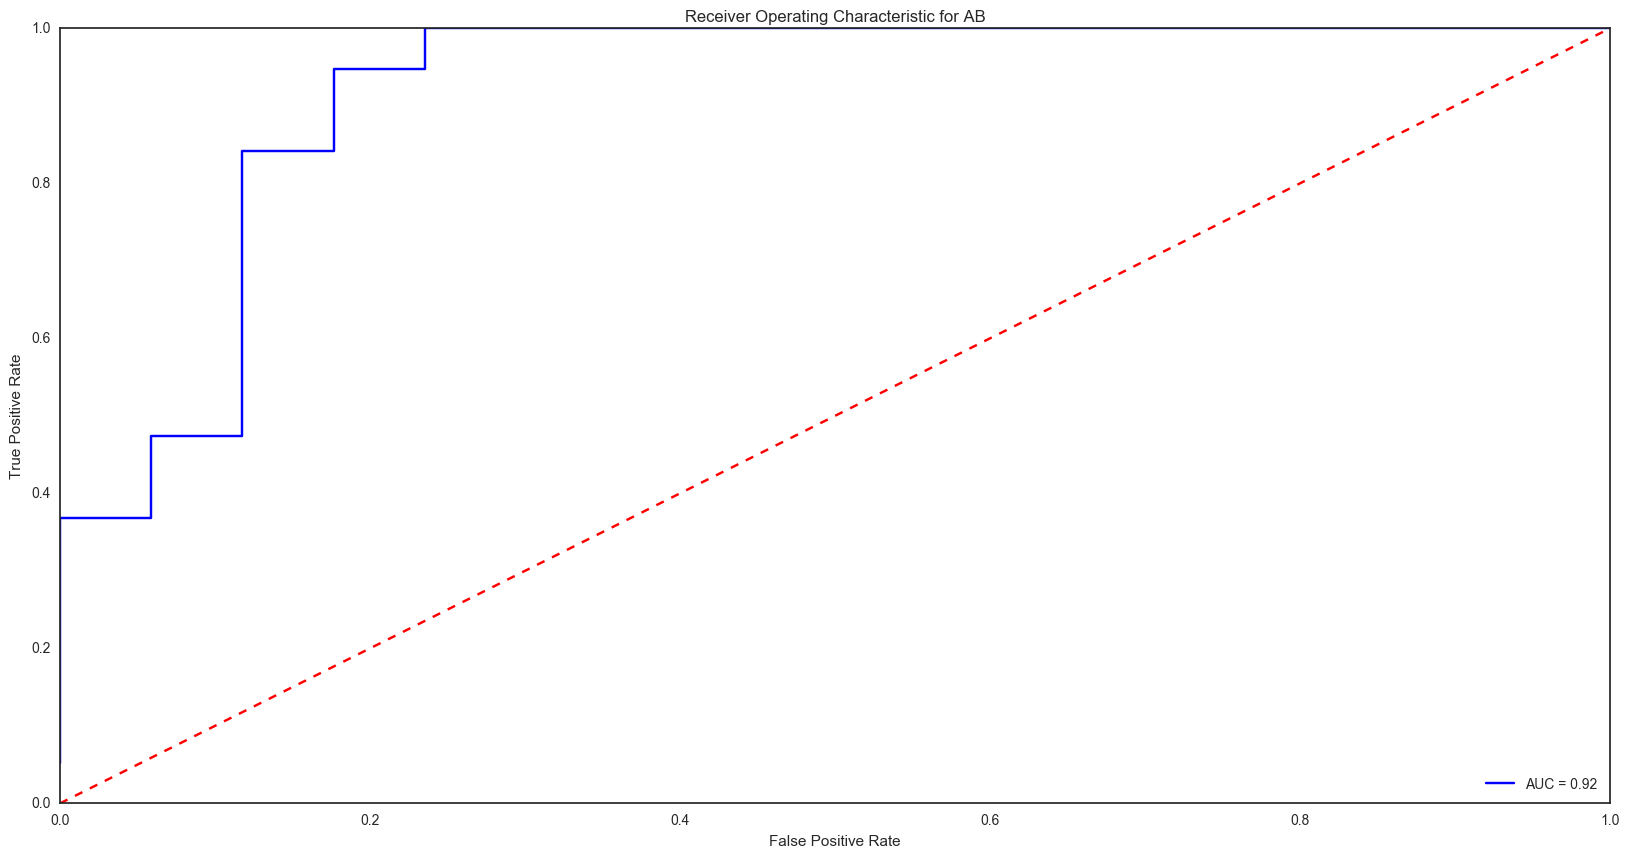

Validation based on GBM
Feature Importance 
[ 0.00154396  0.07591474  0.02331926  0.07636218  0.02291409  0.03982733
  0.12547134  0.03925414  0.17815227  0.00361588  0.          0.00164361
  0.01089697  0.02018449  0.00727275  0.          0.00148734  0.02726233
  0.04807196  0.04682539  0.00252909  0.07612141  0.13998184  0.00497867
  0.01687194  0.          0.00373892  0.00100121  0.00179463  0.00296224]
0.833333333333
[[13  4]
 [ 2 17]]
[[13  4]
 [ 2 17]]
             precision    recall  f1-score   support

          0       0.87      0.76      0.81        17
          1       0.81      0.89      0.85        19

avg / total       0.84      0.83      0.83        36



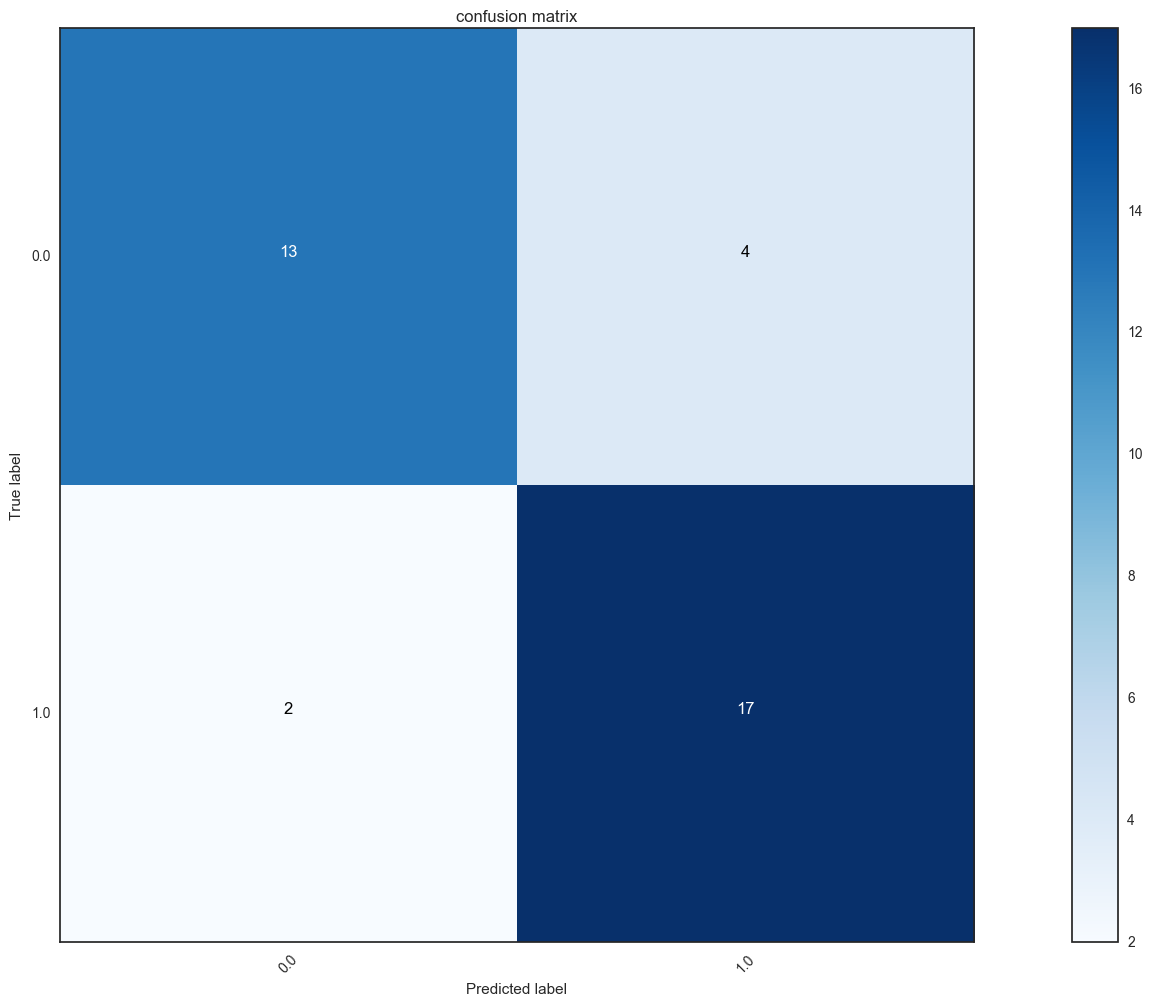

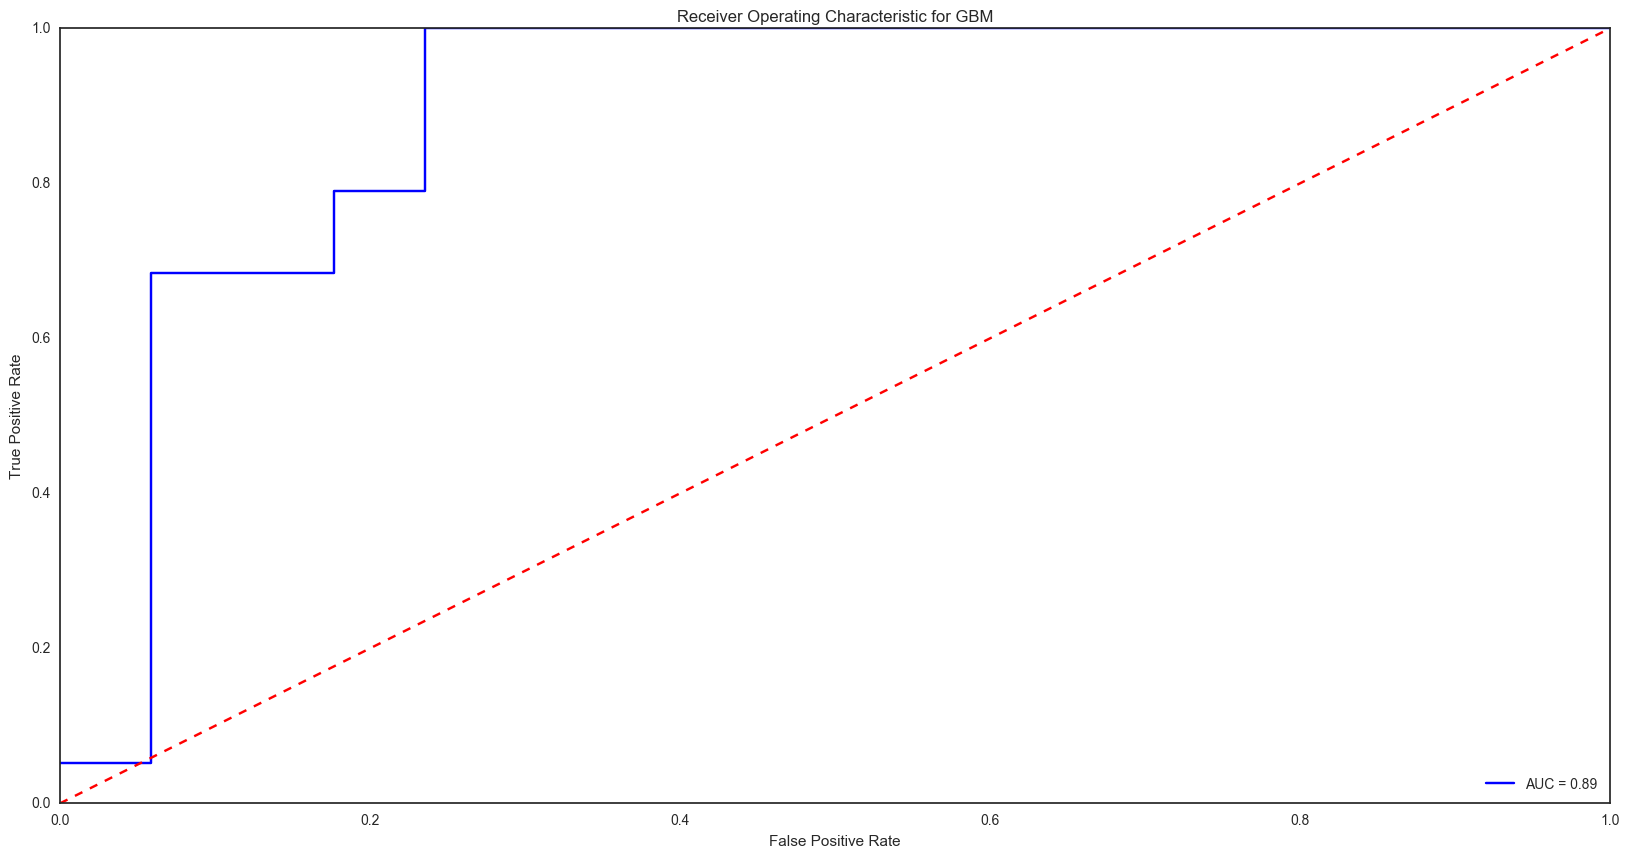

Validation based on RF
Feature Importance 
[ 0.00600126  0.02396385  0.04836104  0.04607642  0.04326002  0.04766364
  0.05111137  0.04482589  0.05841829  0.00888945  0.          0.00876416
  0.00957626  0.01013484  0.01323114  0.00998643  0.00340854  0.06291134
  0.05458097  0.01036137  0.01469545  0.15374395  0.13892458  0.00535497
  0.00620685  0.01259198  0.04578539  0.02380657  0.01370549  0.0236585 ]
0.861111111111
[[15  2]
 [ 3 16]]
[[15  2]
 [ 3 16]]
             precision    recall  f1-score   support

          0       0.83      0.88      0.86        17
          1       0.89      0.84      0.86        19

avg / total       0.86      0.86      0.86        36



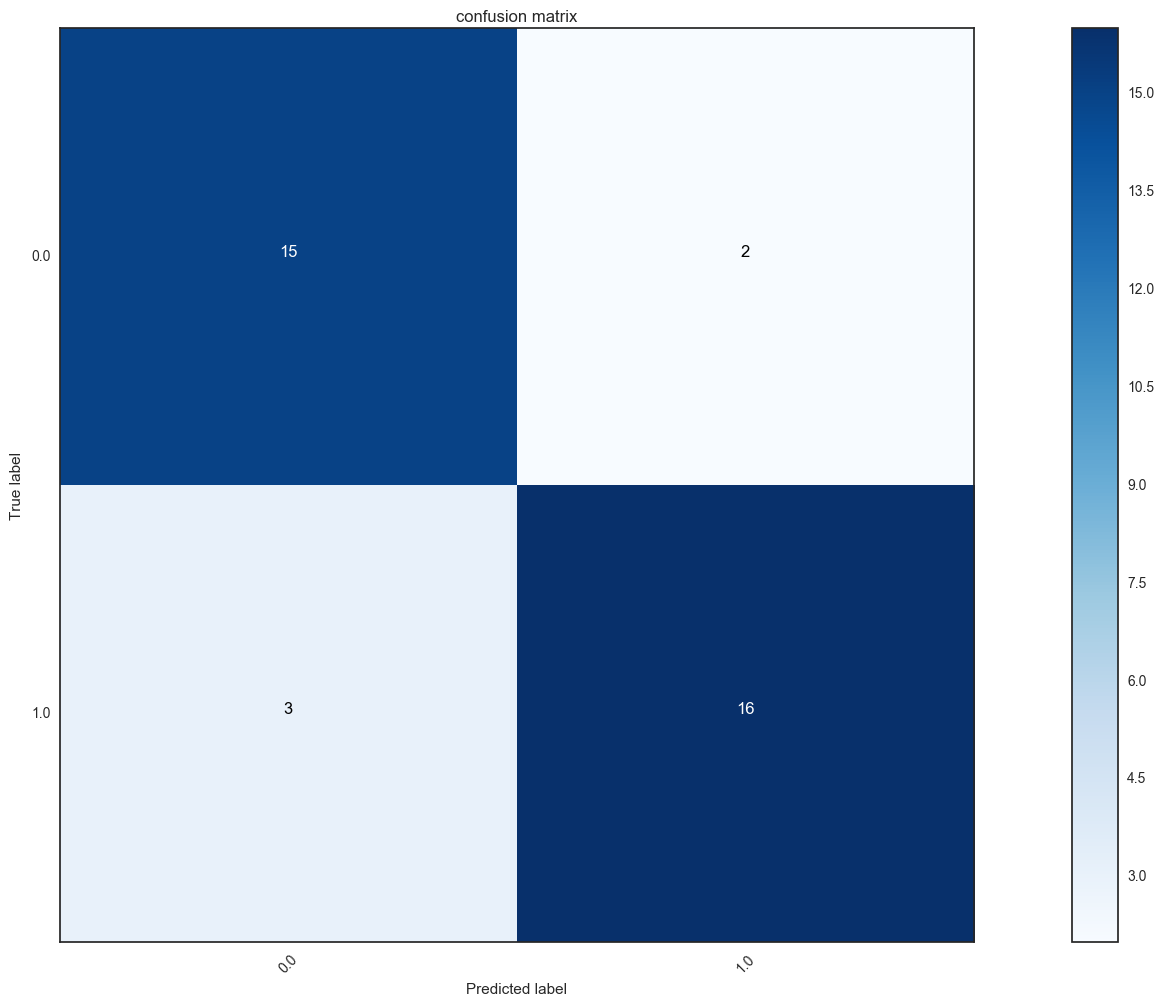

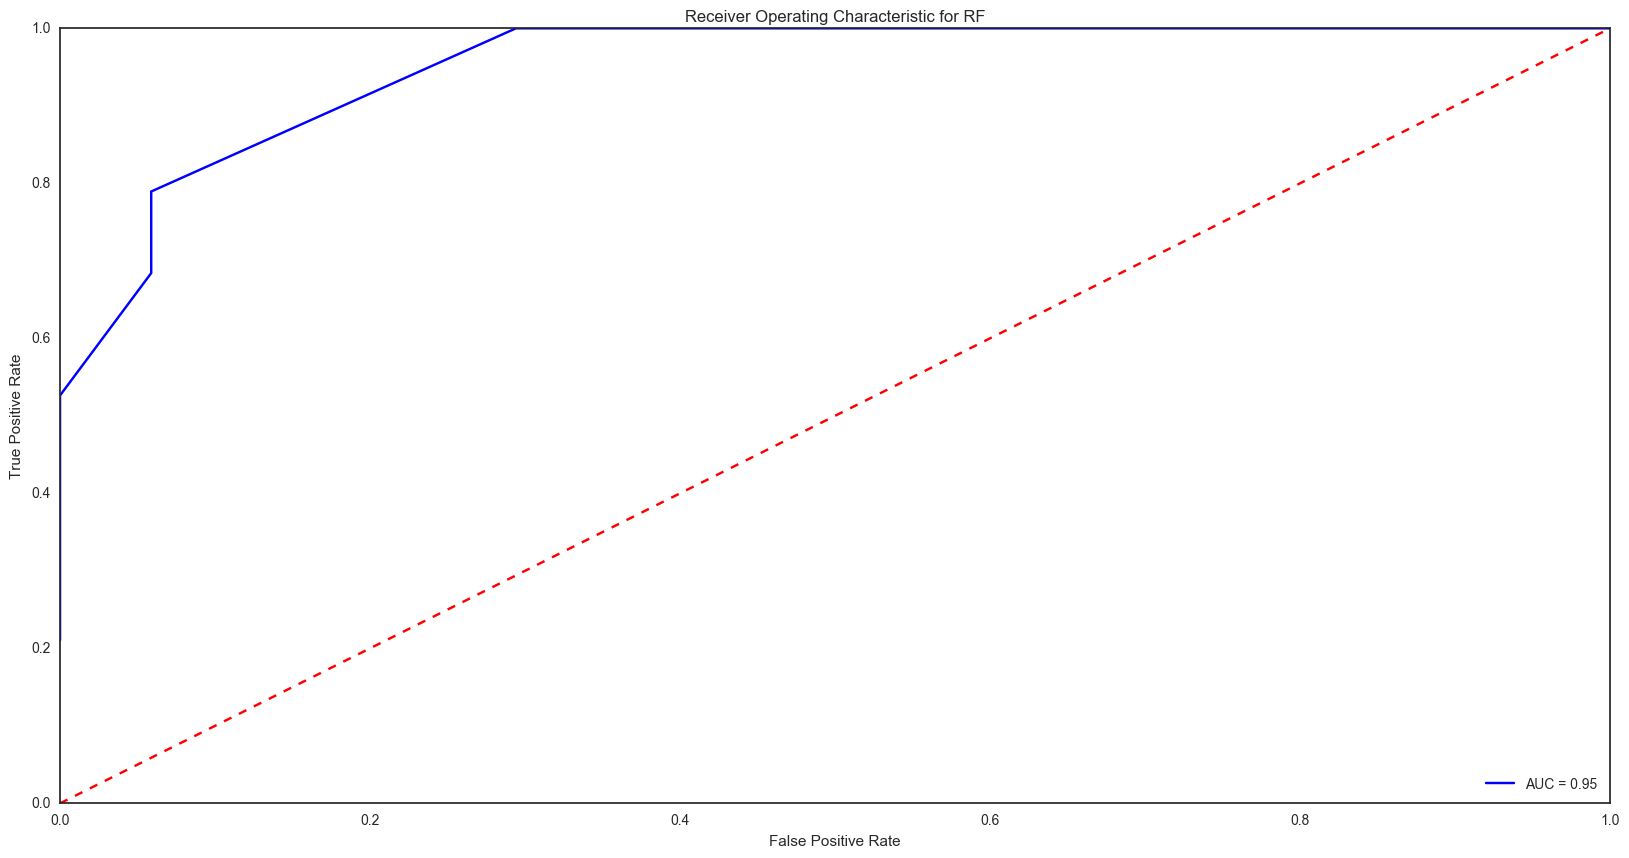

Validation based on ET
Feature Importance 
[ 0.00391708  0.02601385  0.02151106  0.0455521   0.02446494  0.02471697
  0.03737353  0.03289268  0.02947234  0.00698008  0.          0.01083204
  0.00861431  0.02141542  0.0069731   0.01322975  0.00498116  0.0443372
  0.11353724  0.04094746  0.00739208  0.13290322  0.12198235  0.02184454
  0.01227391  0.01575676  0.05542138  0.04673003  0.01158205  0.05635137]
0.833333333333
[[15  2]
 [ 4 15]]
[[15  2]
 [ 4 15]]
             precision    recall  f1-score   support

          0       0.79      0.88      0.83        17
          1       0.88      0.79      0.83        19

avg / total       0.84      0.83      0.83        36



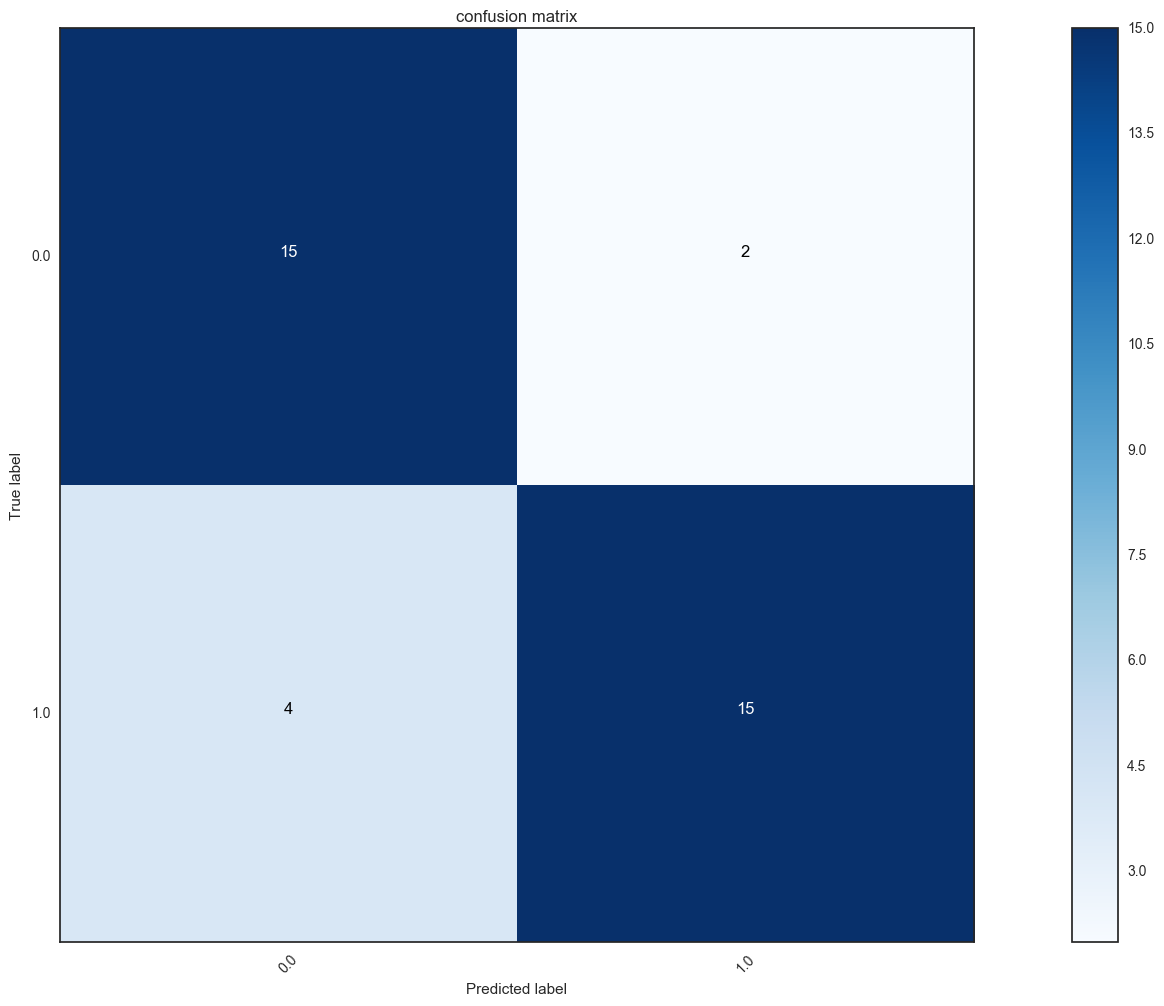

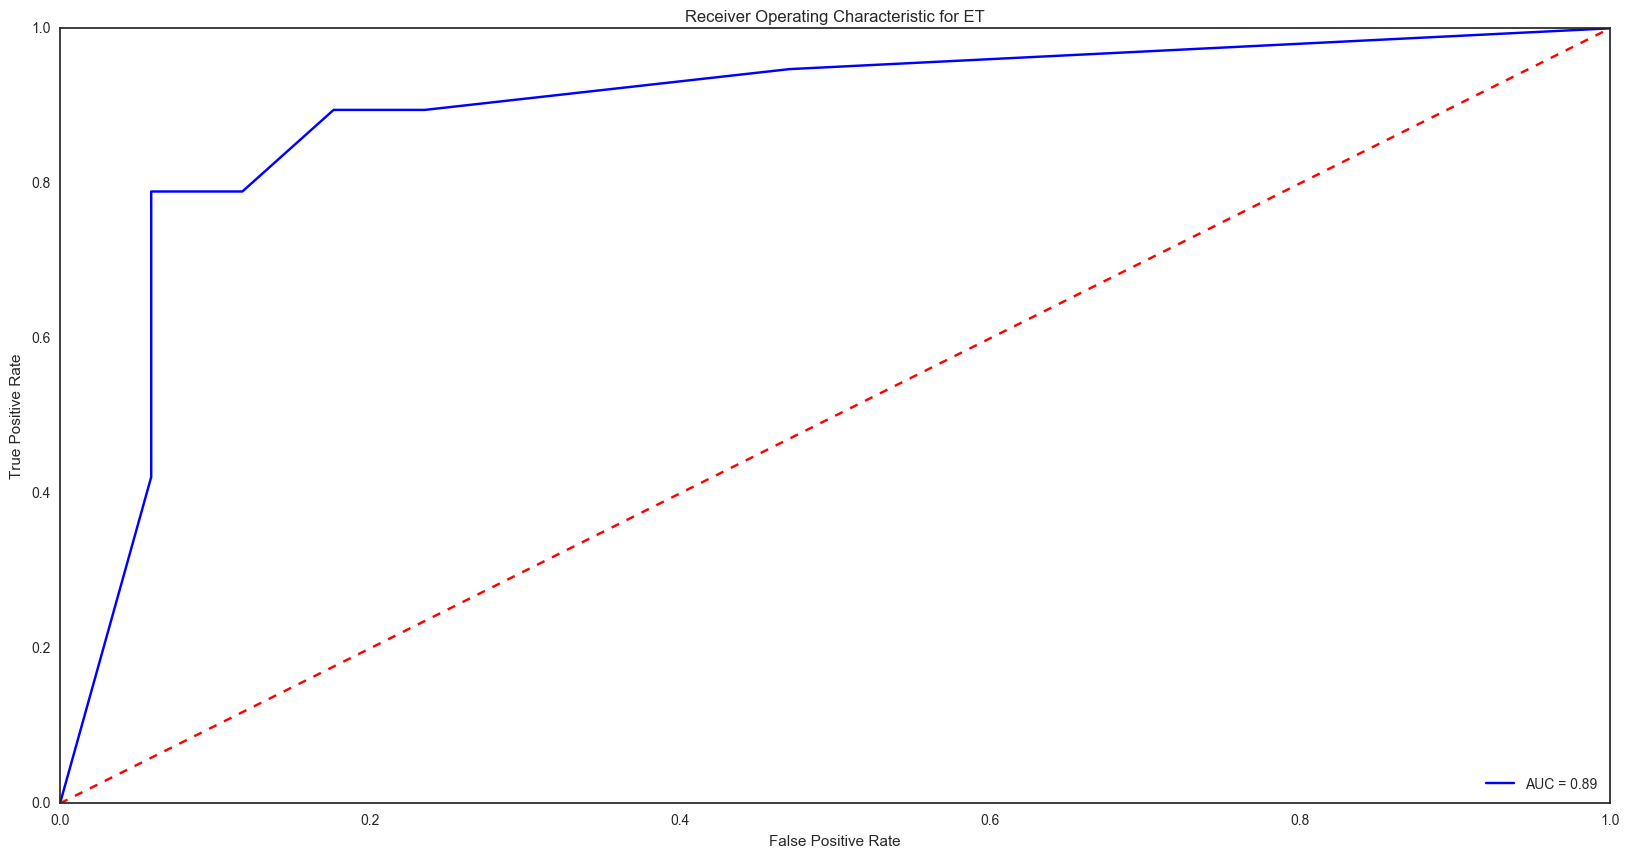

Validation based on XGB
Feature Importance 
[ 0.00819672  0.05532787  0.03278688  0.05942623  0.02868852  0.03278688
  0.16393442  0.09221312  0.10040984  0.          0.          0.
  0.00409836  0.03483607  0.          0.          0.          0.07377049
  0.05327869  0.07786885  0.01229508  0.06352459  0.08811475  0.
  0.00409836  0.          0.01229508  0.          0.          0.00204918]
0.833333333333
[[12  5]
 [ 1 18]]
[[12  5]
 [ 1 18]]
             precision    recall  f1-score   support

          0       0.92      0.71      0.80        17
          1       0.78      0.95      0.86        19

avg / total       0.85      0.83      0.83        36



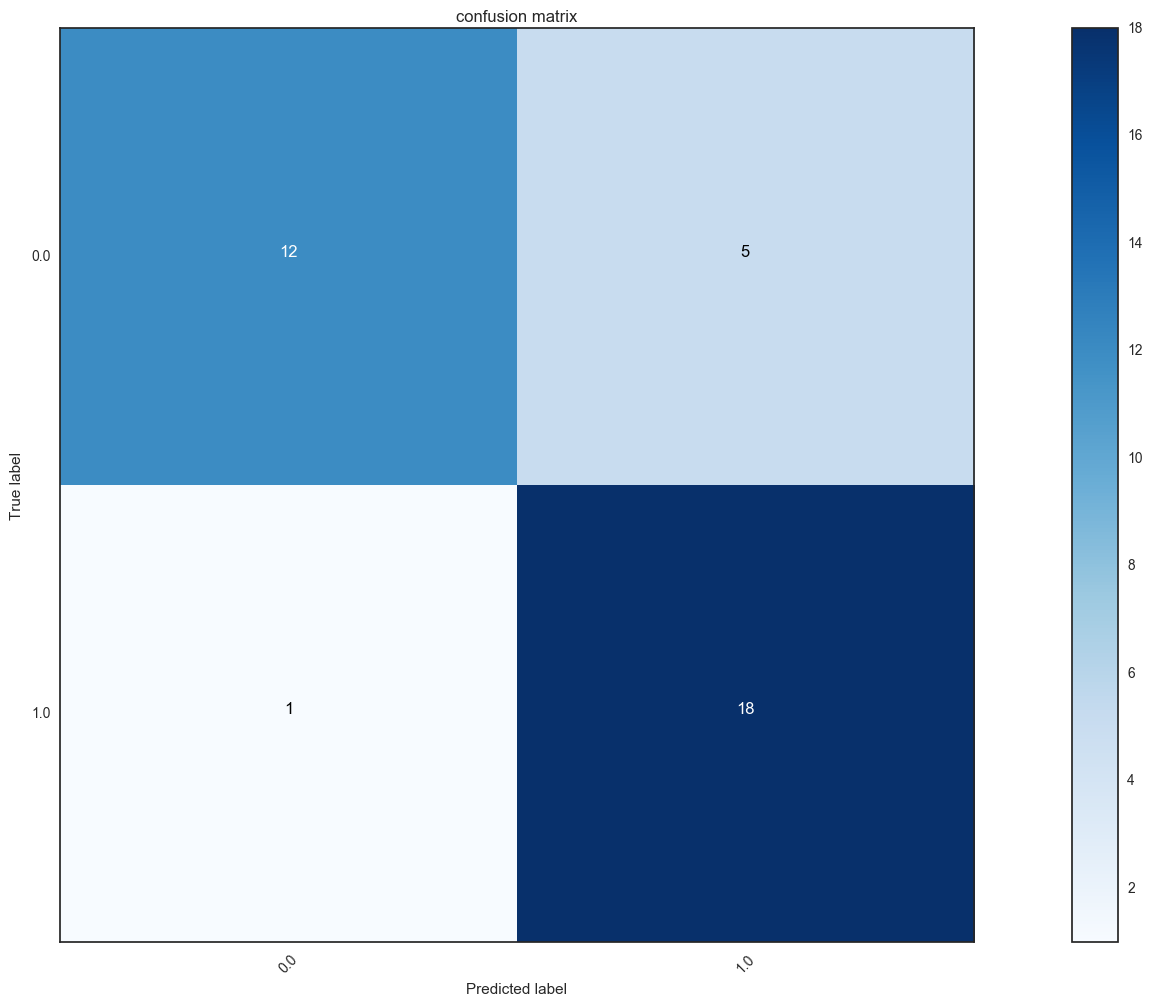

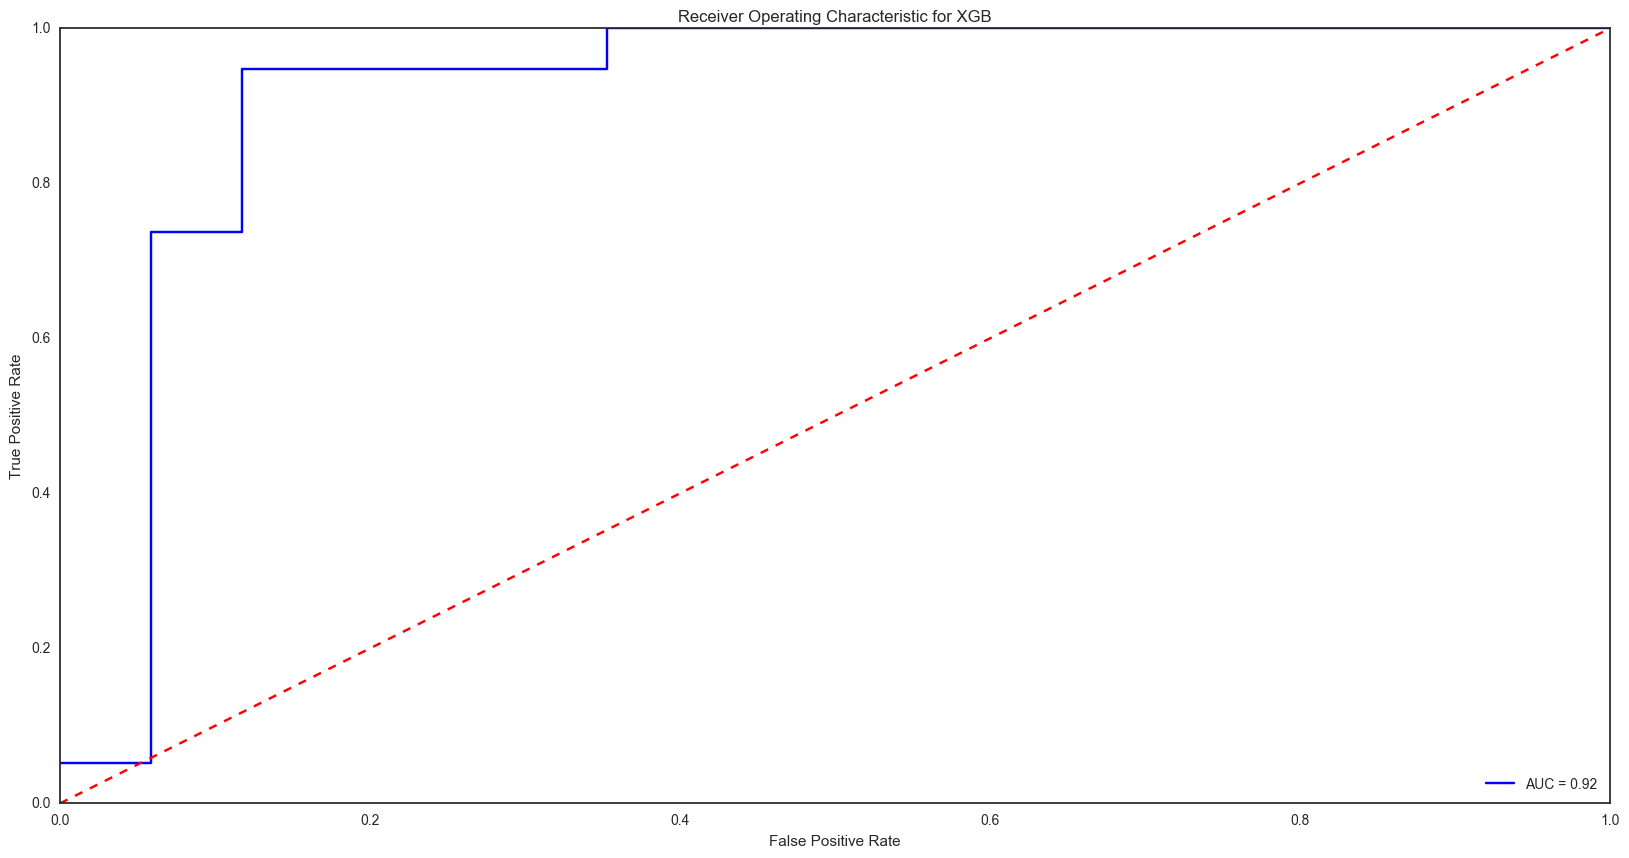

In [86]:
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(1)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def validate_models(training_set, outcome, validation_data, validation_outcome):
    
    models = []
    
    #baselines
    
    #models.append(('LR', LogisticRegression()))
    #models.append(('LDA', LinearDiscriminantAnalysis()))
    #models.append(('KNN', KNeighborsClassifier()))
    #models.append(('CART', DecisionTreeClassifier()))
    #models.append(('NB', GaussianNB()))
    #models.append(('SVM', SVC(probability=True)))
    
    #ensemble
    
    models.append(('AB', AdaBoostClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('ET', ExtraTreesClassifier()))
    models.append(('XGB', xgboost.XGBClassifier()))

    
    for name, model in models:
        mod = model
        mod.fit(training_set, outcome)
        # estimate accuracy on validation dataset
        predictions = mod.predict(validation_data)
        print "Validation based on " + name
        print "Feature Importance " 
        print model.feature_importances_
        
        print(accuracy_score(validation_outcome, predictions))
        print(confusion_matrix(validation_outcome, predictions))
        cfmat = confusion_matrix(validation_outcome, predictions)
        plot_confusion_matrix(cfmat, classes=[0.0, 1.0] , title='confusion matrix')
        
        print(classification_report(validation_outcome, predictions))

        # calculate the fpr and tpr for all thresholds of the classification
        probs = mod.predict_proba(validation_data)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(validation_outcome, preds)
        roc_auc = auc(fpr, tpr)
        
        # method I: plt
        plt.figure(2)
        plt.title('Receiver Operating Characteristic for ' + name)
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
validate_models(X_train, y_train, X_val, y_val)

# Predicting outcome WITH feature selection


	Corr.	Linear reg	MIC	RF	RFE	Ridge	Stability	XGB	Mean
age.challenge	0.0	0.0	0.03	0.03	0.36	0.36	0.0	0.21	0.03
weight.challenge	0.02	0.33	0.61	0.11	1.0	0.03	0.0	1.0	0.22
v18.hour.post.challenge	0.02	0.0	0.83	0.1	0.04	0.0	0.0	0.37	0.03
v18.weight	0.03	0.08	0.68	0.14	1.0	0.0	0.0	0.5	0.11
v24.hour.post.challenge	0.0	0.0	0.89	0.13	0.24	0.23	0.0	0.41	0.18
v24.weight	0.05	0.26	0.73	0.07	0.96	0.09	0.0	0.42	0.17
weight.change.0.24	0.06	1.0	0.6	0.14	1.0	0.05	0.0	0.46	0.3
weight.change.0.18	0.01	0.67	0.46	0.1	1.0	0.01	0.0	0.43	0.27
weight.change.18.24	0.14	0.74	0.8	0.2	1.0	0.07	0.0	0.81	0.47
sex_m	0.01	0.0	0.01	0.02	0.16	0.15	0.0	0.08	0.01
chal.status_non challenged	0.01	0.0	0.03	0.0	0.32	0.09	0.0	0.0	0.01
v18.energy.high_mobile	0.0	0.0	0.0	0.02	0.08	0.04	0.0	0.05	0.01
v18.energy.high_non mobile	0.0	0.0	0.0	0.01	0.28	0.27	0.0	0.06	0.01
v18.energy.low_mobile	0.0	0.0	0.0	0.03	0.12	0.06	0.0	0.07	0.01
v18.energy.low_non mobile	0.02	0.0	0.03	0.0	0.2	0.14	0.0	0.0	0.01
v18.righting.response.high_rights	

/Users/Rad/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:71: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/Rad/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:73: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


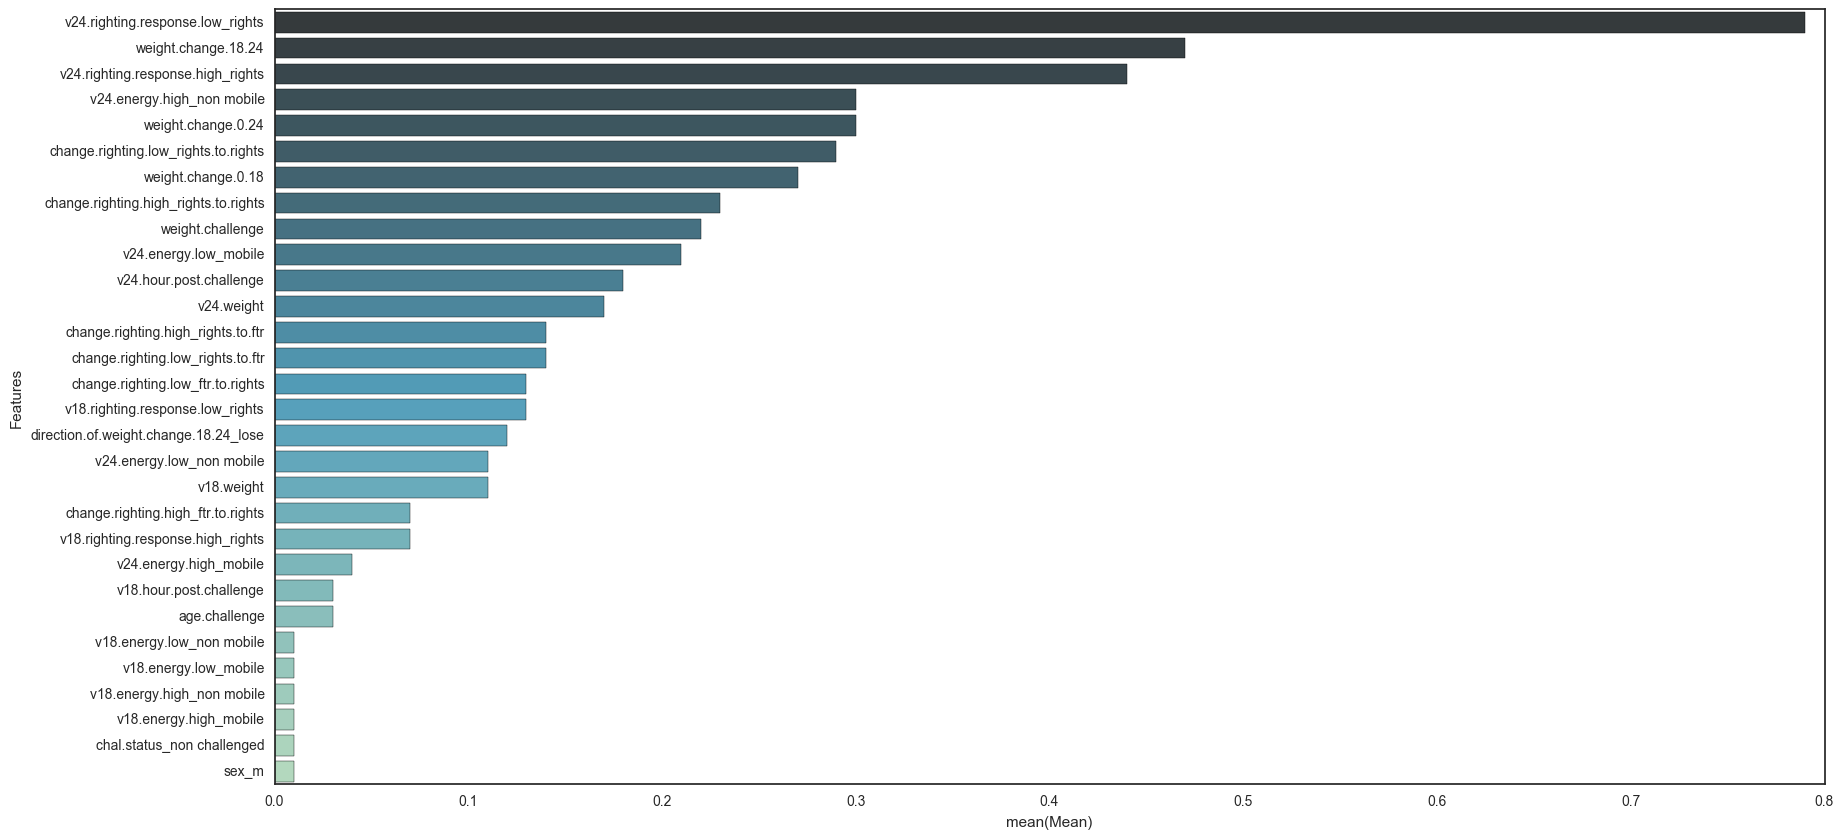

In [92]:

#names = X.columns
#X = X.values
Y = y

ranks = {}
 
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))
 
lr = LinearRegression(normalize=True)
lr.fit(X, Y)
ranks["Linear reg"] = rank_to_dict(np.abs(lr.coef_), names)
 
ridge = Ridge(alpha=7)
ridge.fit(X, Y)
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)
 
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["Stability"] = rank_to_dict(np.abs(rlasso.scores_), names)

rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X,Y)
ranks["RFE"] = rank_to_dict(map(float, rfe.ranking_), names, order=-1)
 
rf = RandomForestRegressor()
rf.fit(X,Y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)

xgb = xgboost.XGBRegressor()
xgb.fit(X,Y)
ranks["XGB"] = rank_to_dict(xgb.feature_importances_, names)
 
f, pval  = f_regression(X, Y, center=True)
ranks["Corr."] = rank_to_dict(f, names)
 
mine = MINE()
mic_scores = []
for i in range(X.shape[1]):
    mine.compute_score(X[:,i], Y)
    m = mine.mic()
    mic_scores.append(m)

ranks["MIC"] = rank_to_dict(mic_scores, names) 
 
r = {}
for name in names:
    r[name] = round(np.median([ranks[method][name] 
                             for method in ranks.keys()]), 2)

methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print "\t%s" % "\t".join(methods)
for name in names:
    print "%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods])))


results_FS = pd.DataFrame(columns=methods)
for name in names:
    results_FS.loc[name] = map(float, [ranks[method][name] for method in methods])

results_FS['Features'] = results_FS.index
results_FS.reset_index(level=0, inplace=True)
results_FS.sort(['Ridge'], ascending=False).head()
results_FS = results_FS.drop(['index'], axis=1)
ax = sns.barplot(y="Features", x="Mean", data=results_FS.sort(['Mean'], ascending=False), orient='h', palette="GnBu_d")

In [207]:

X_train_2 = X_train[["v24.righting.response.high_rights", "v24.righting.response.low_rights", "v24.energy.high_non mobile"]]
X_val_2 = X_val[["v24.righting.response.high_rights", "v24.righting.response.low_rights", "v24.energy.high_non mobile"]]


#X_train_2 = X_train[["weight.change.18.24", "weight.challenge"]]
#X_val_2 = X_val[["weight.change.18.24", "weight.challenge"]]

## Base line Models



LR: 0.865238 (0.038395)
LDA: 0.815714 (0.056587)
KNN: 0.850476 (0.050763)
CART: 0.850952 (0.038747)
NB: 0.850952 (0.038747)
SVM: 0.879524 (0.032230)


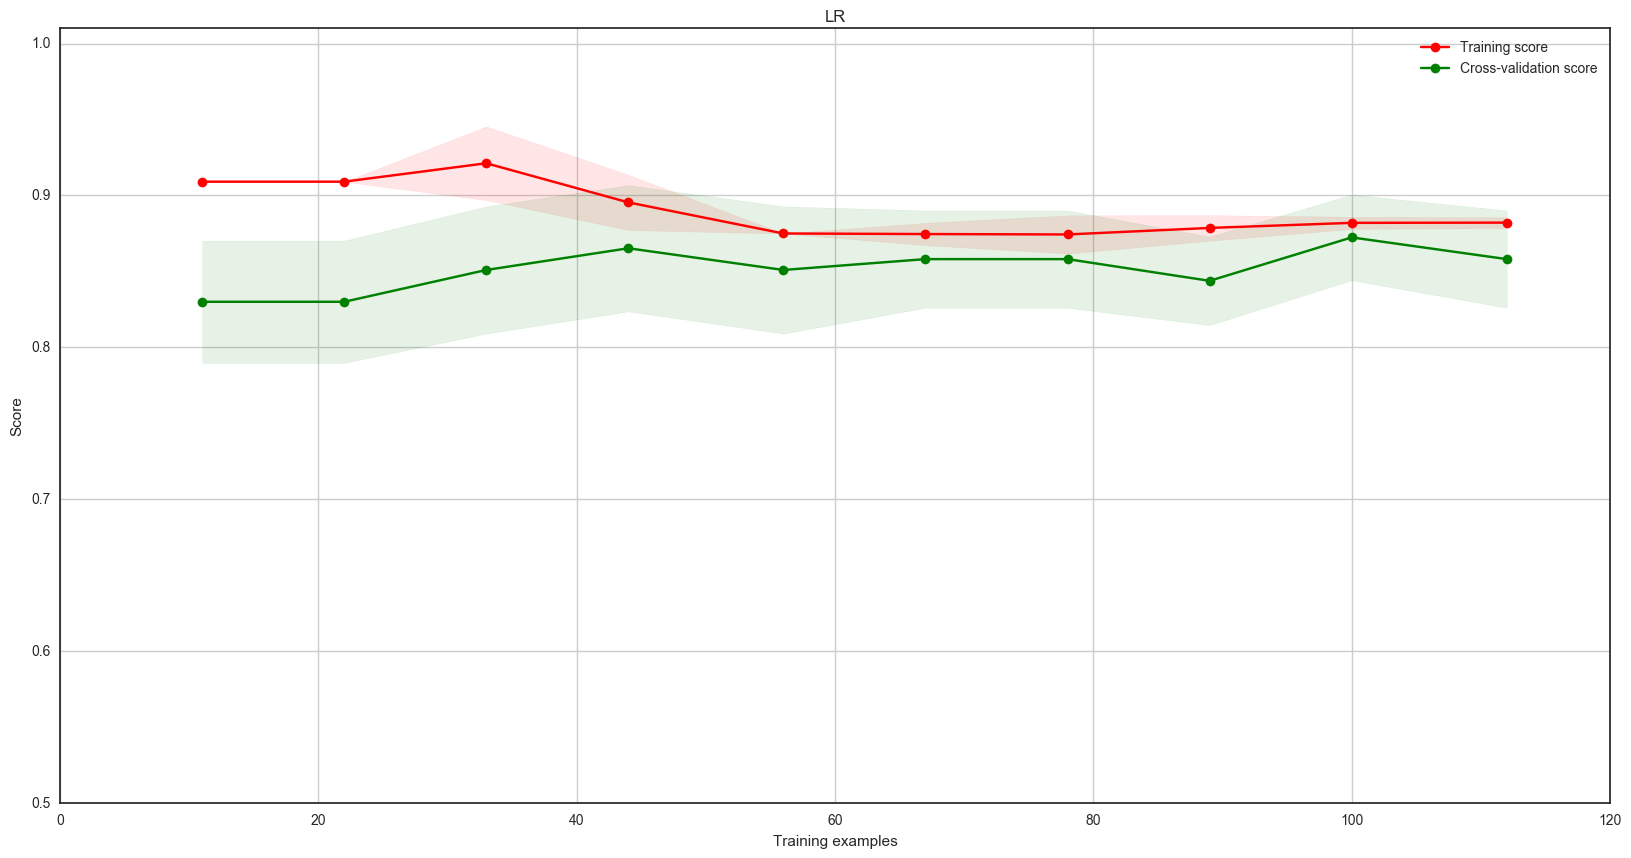

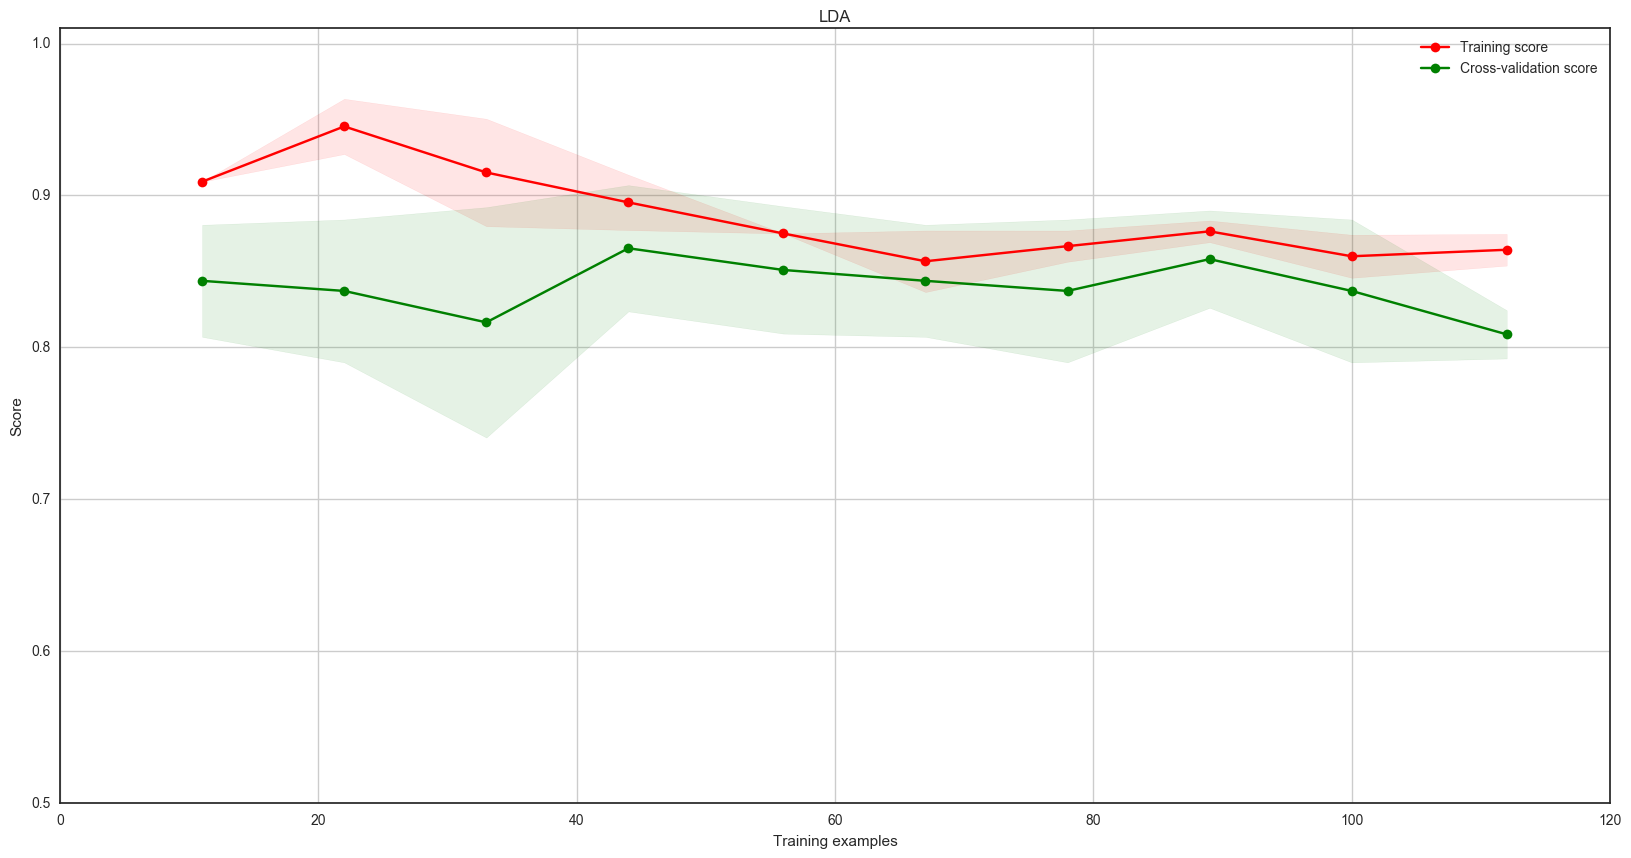

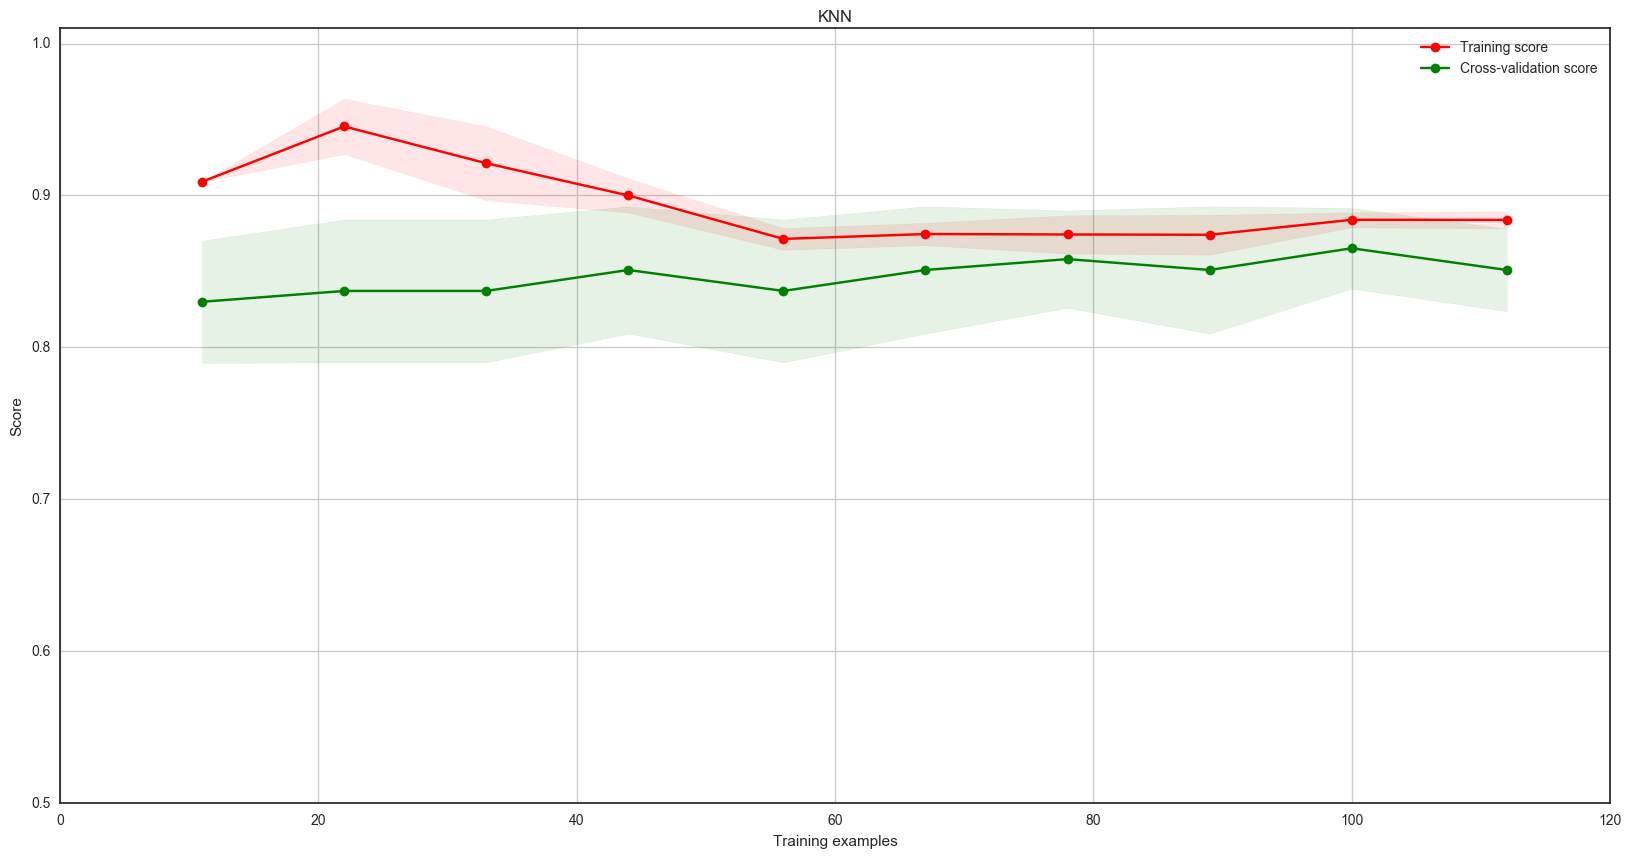

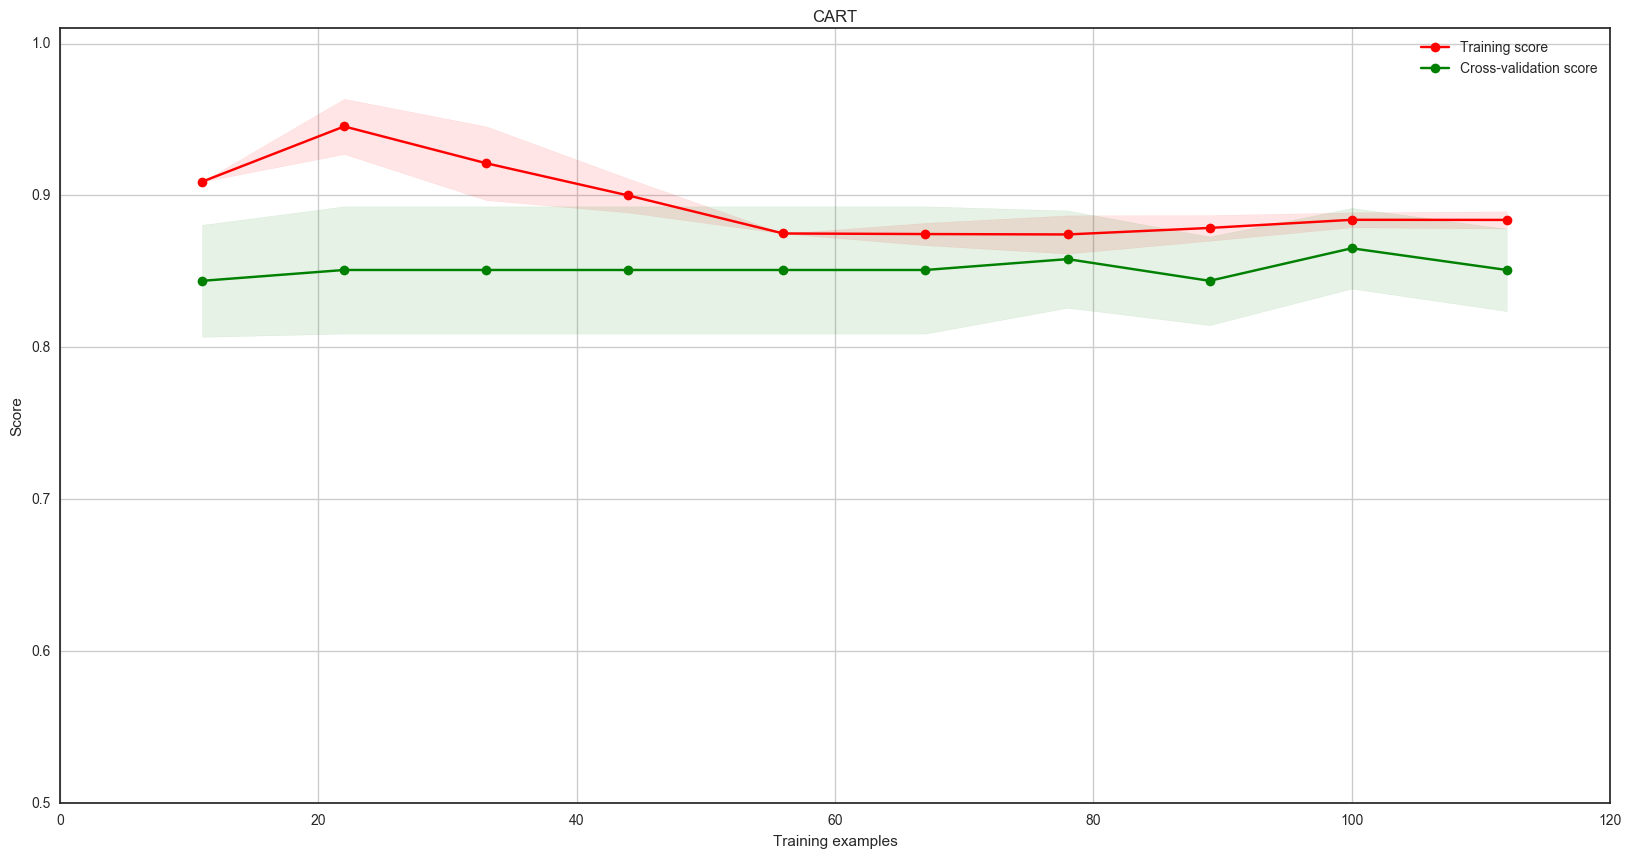

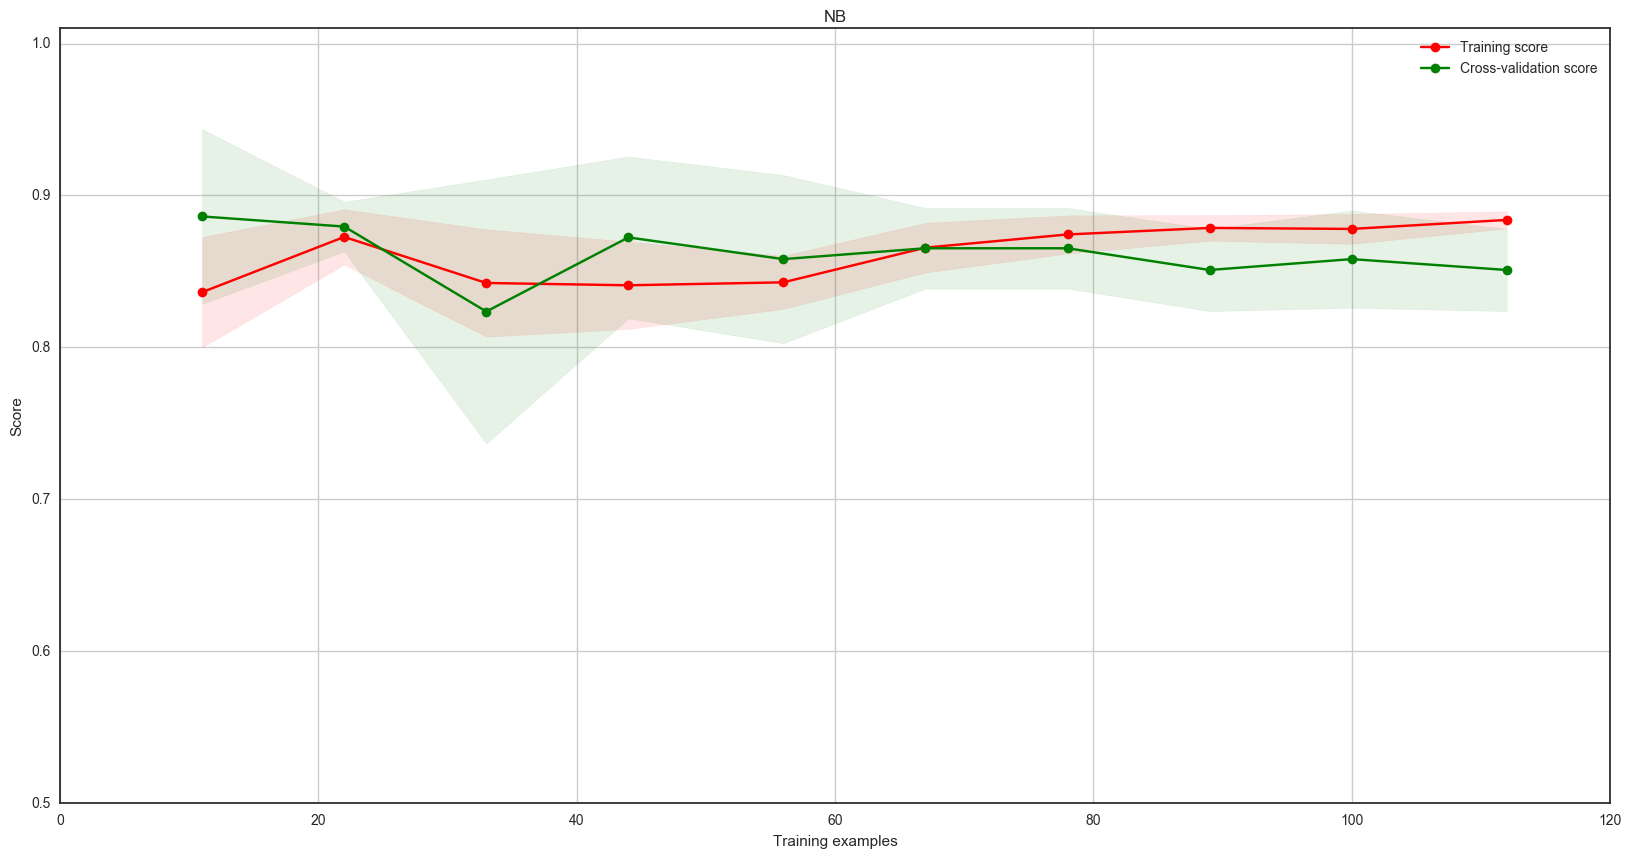

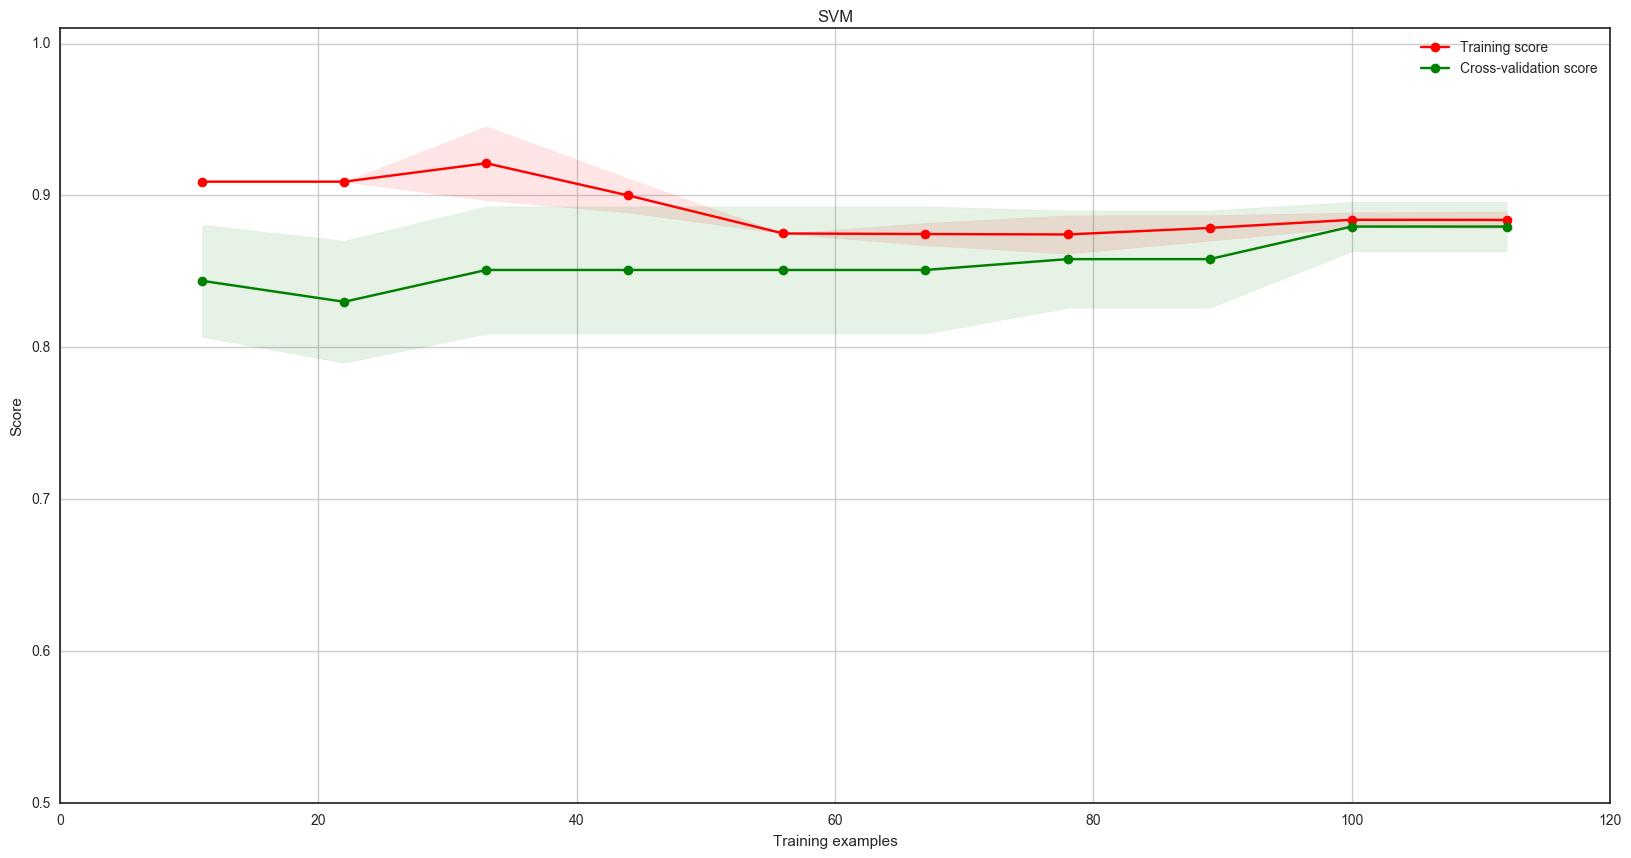

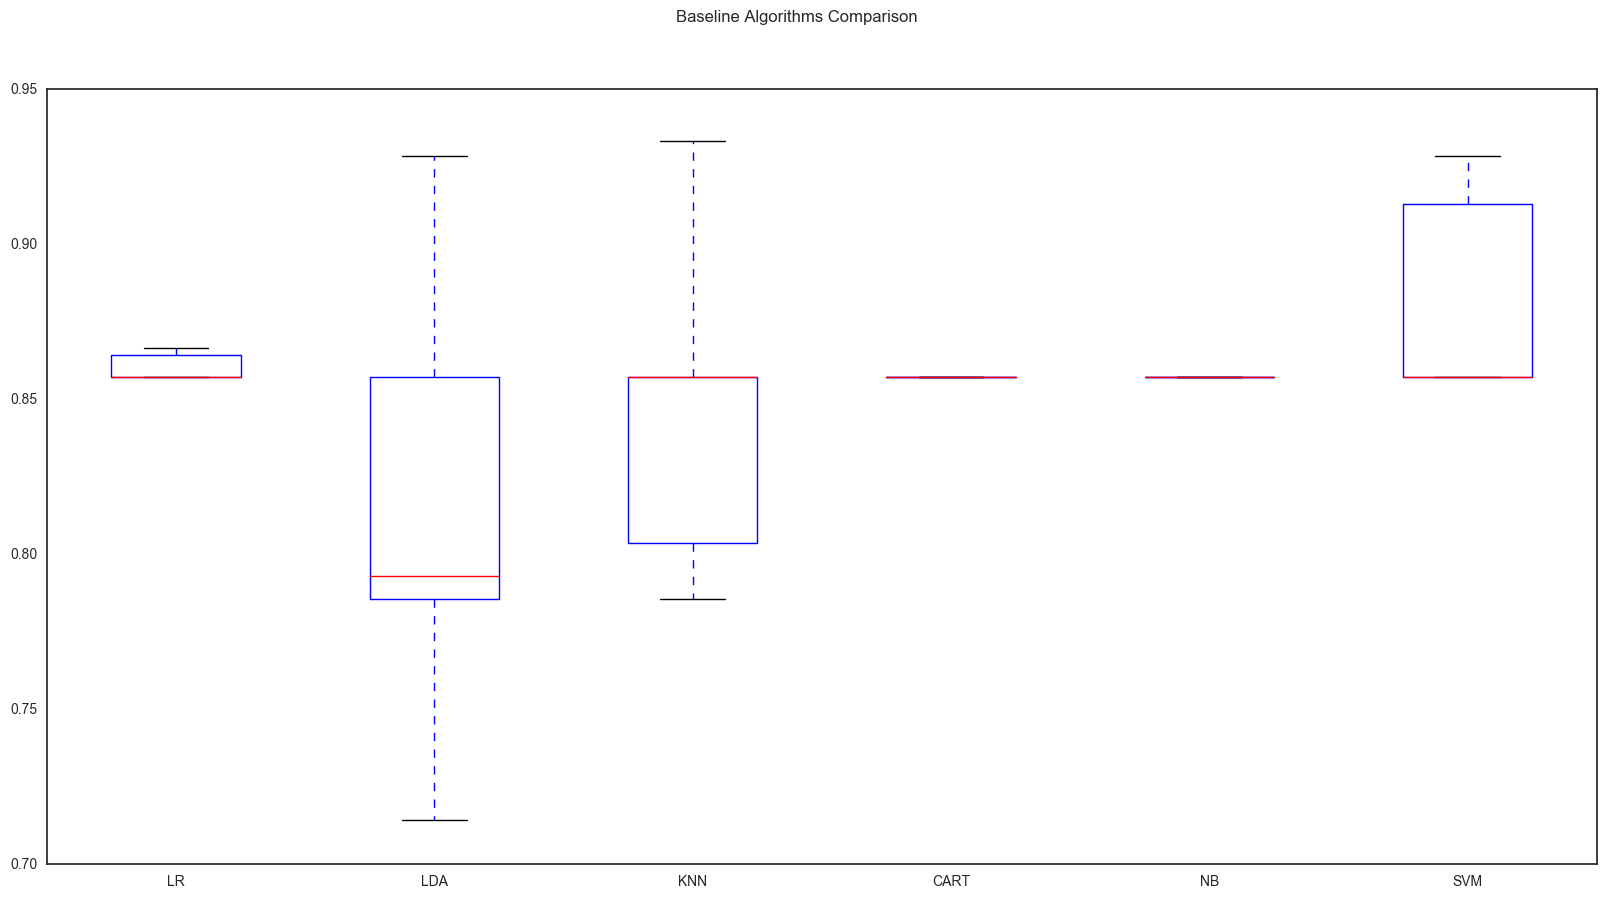

In [208]:
def base_line_models(training_set, outcome):
    # Test options and evaluation metric
    num_folds = 10
    num_instances = len(training_set)
    seed = 7
    scoring = 'accuracy'

    # Spot-Check Algorithms
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))
    results = []
    names = []
    for name, model in models:
        kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        cv_results = cross_validation.cross_val_score(model, training_set, outcome, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        plot_learning_curve(model,name, training_set, outcome, ylim=(0.5, 1.01), train_sizes=np.linspace(0.1, 1.0, 10) , cv=10)
    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Baseline Algorithms Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

base_line_models(X_train_2, y_train)

## Ensemble Methods

AB: 0.879524 (0.032230)
GBM: 0.865238 (0.038395)
RF: 0.858095 (0.045266)
ET: 0.850952 (0.038747)
XGB: 0.879524 (0.032230)


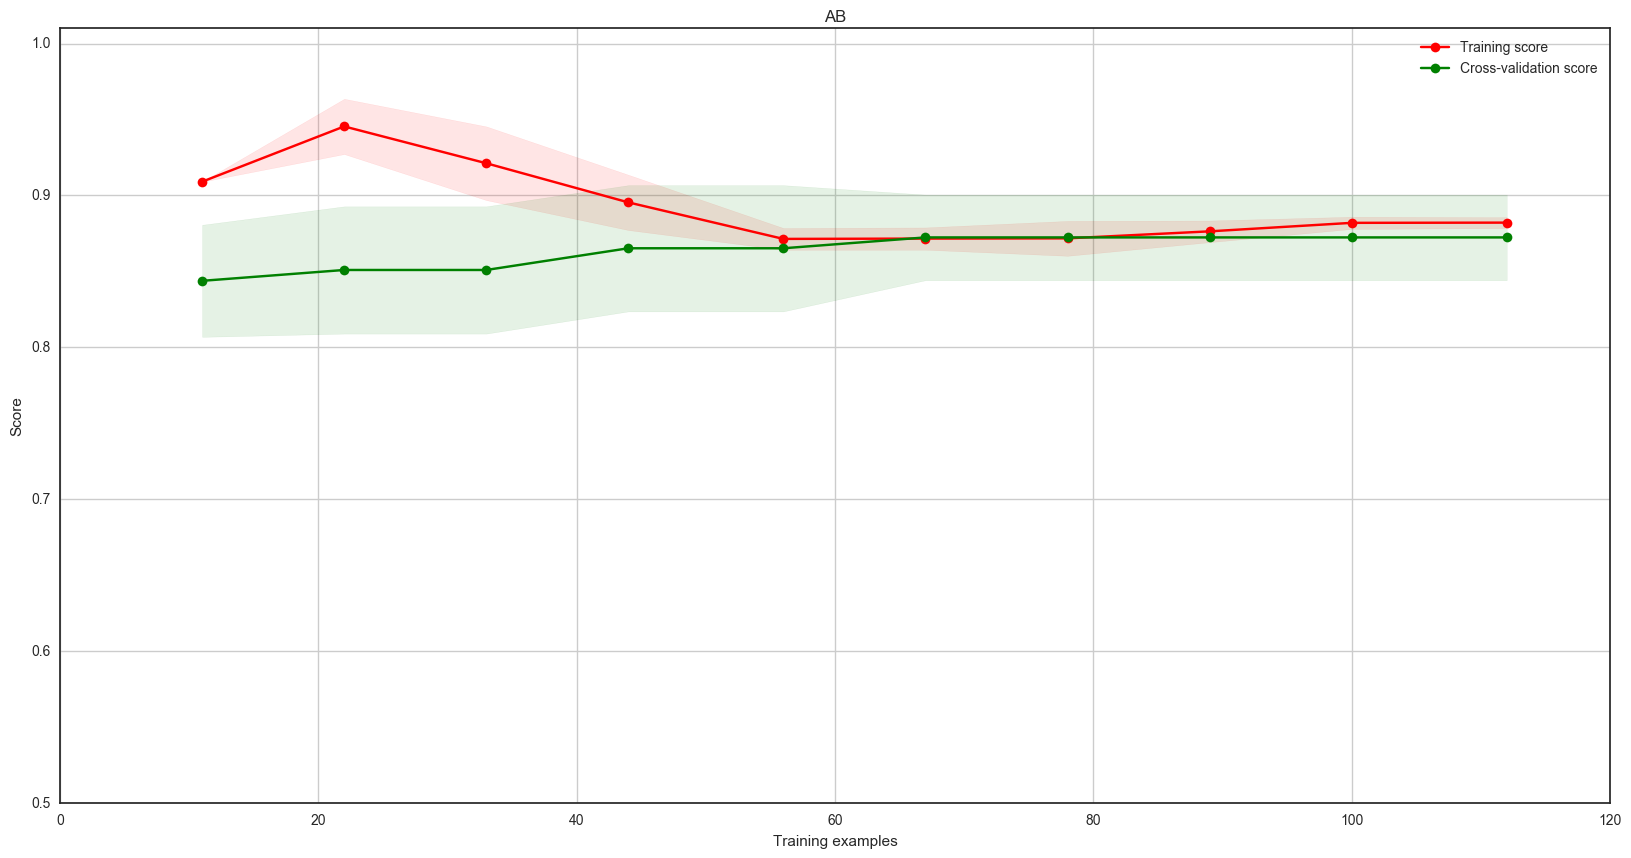

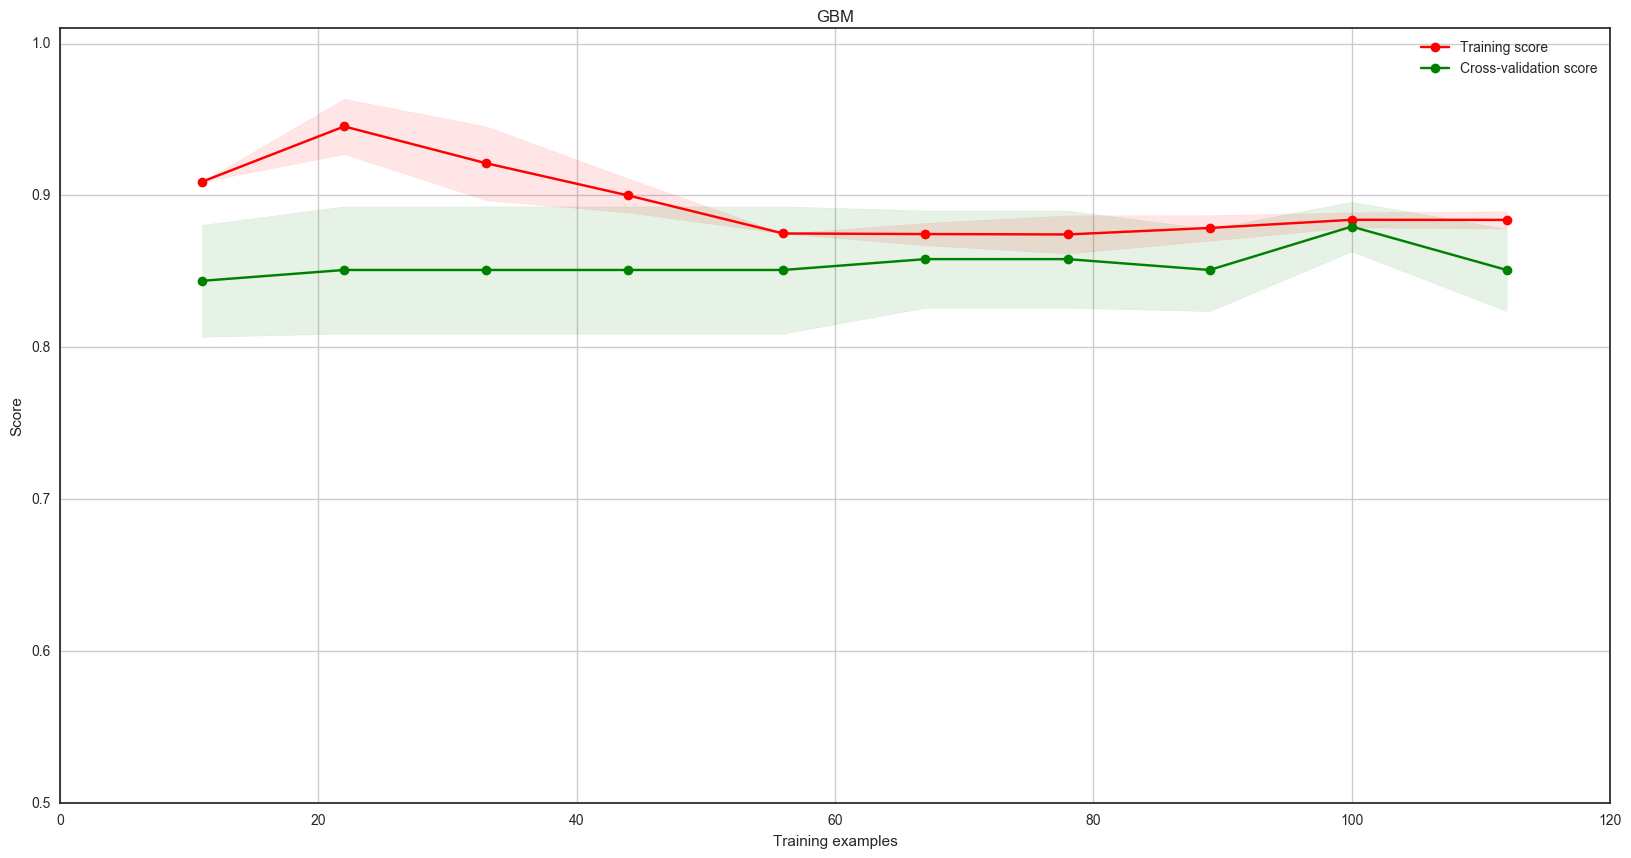

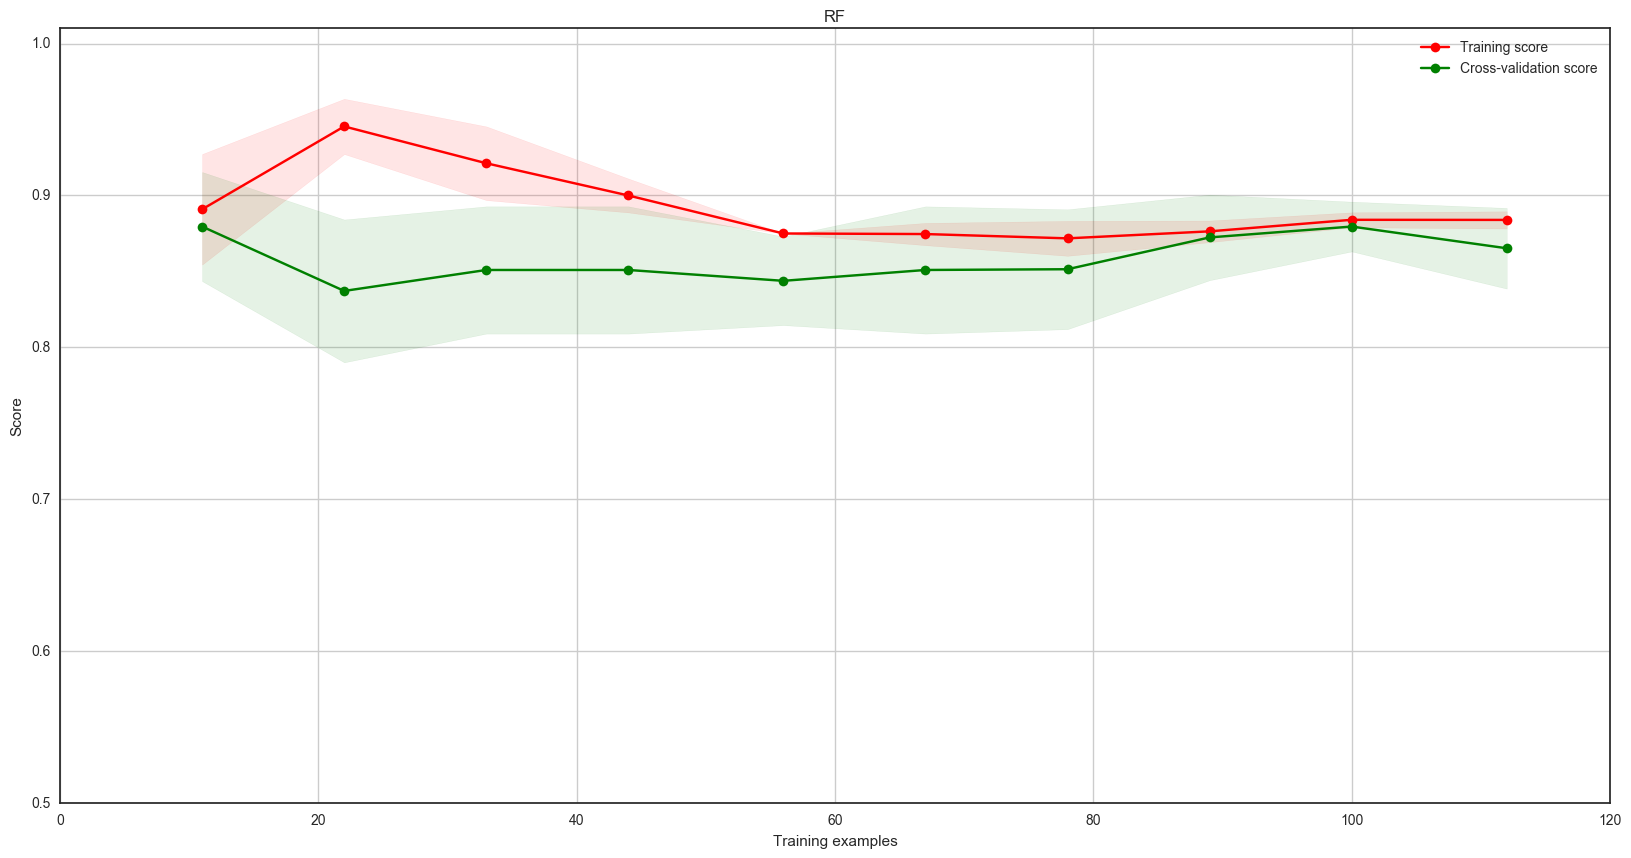

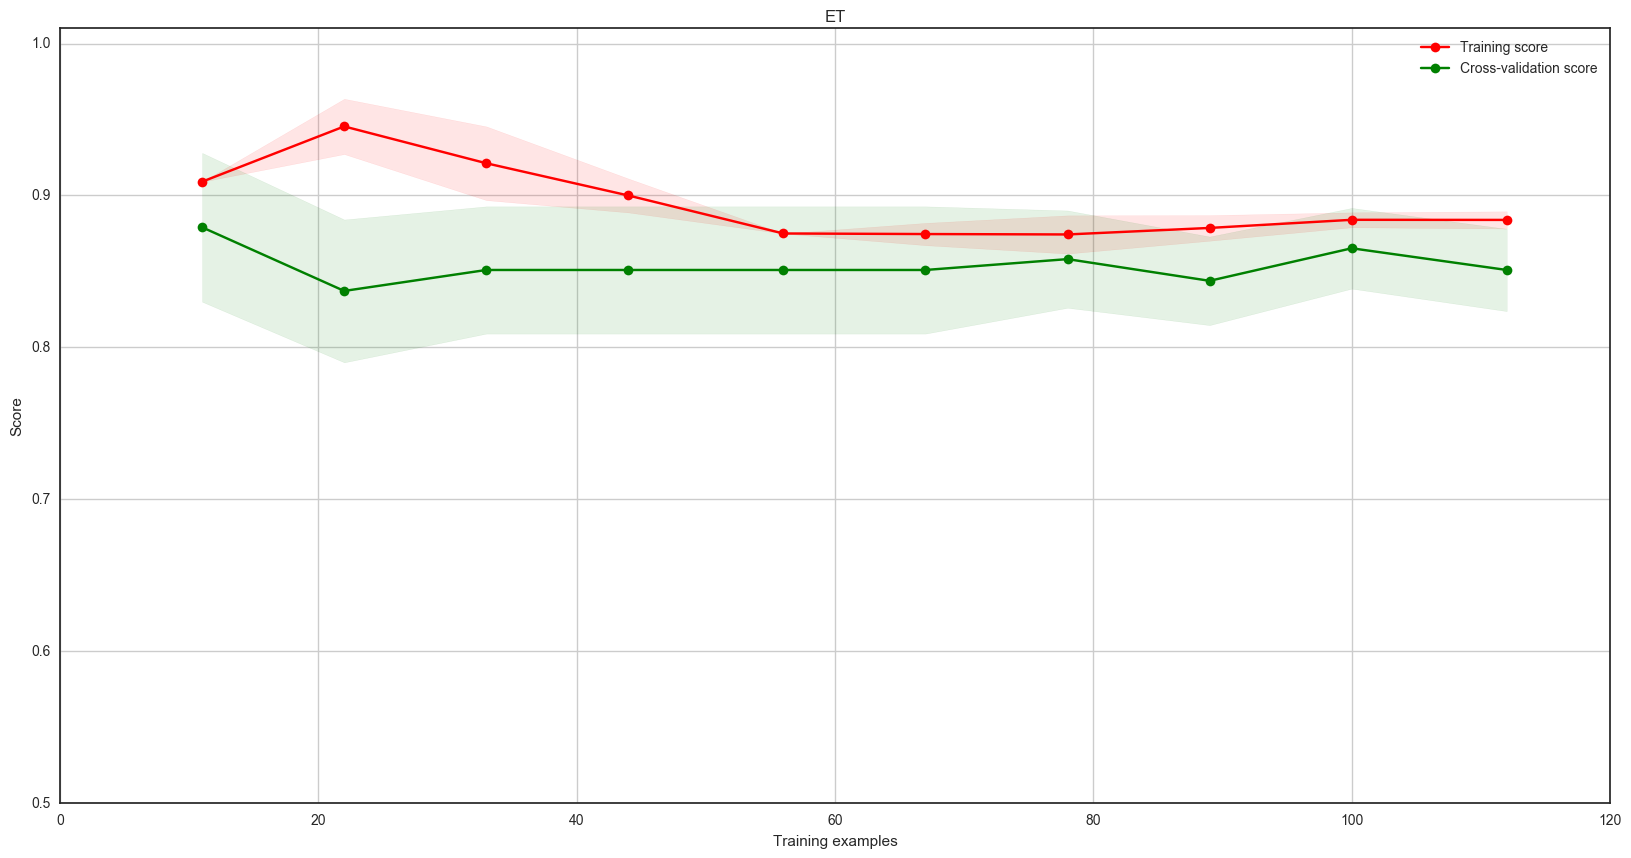

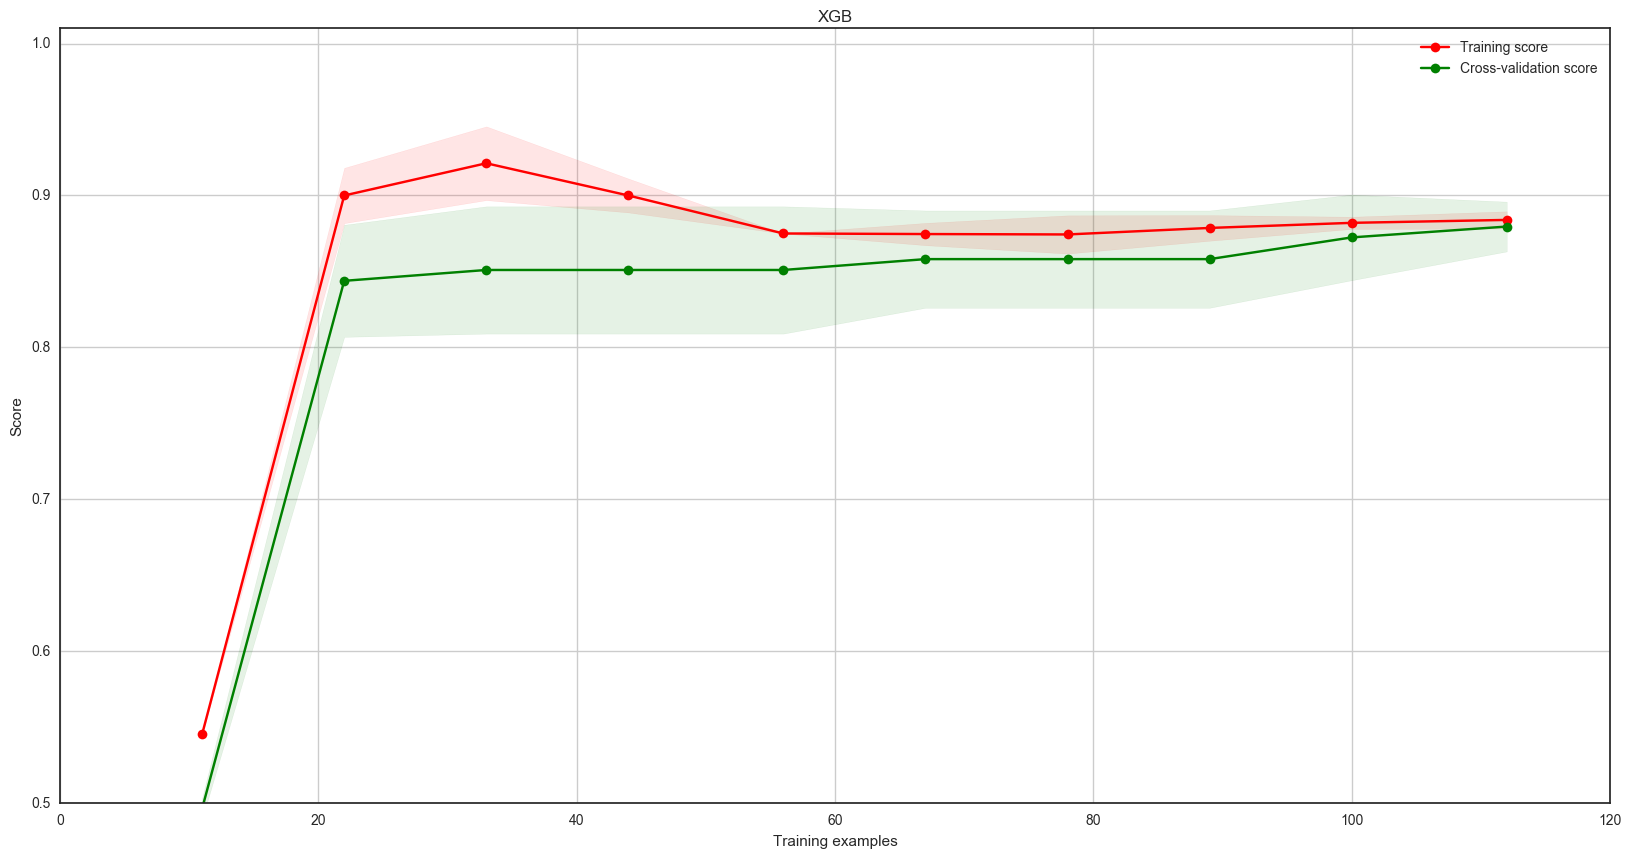

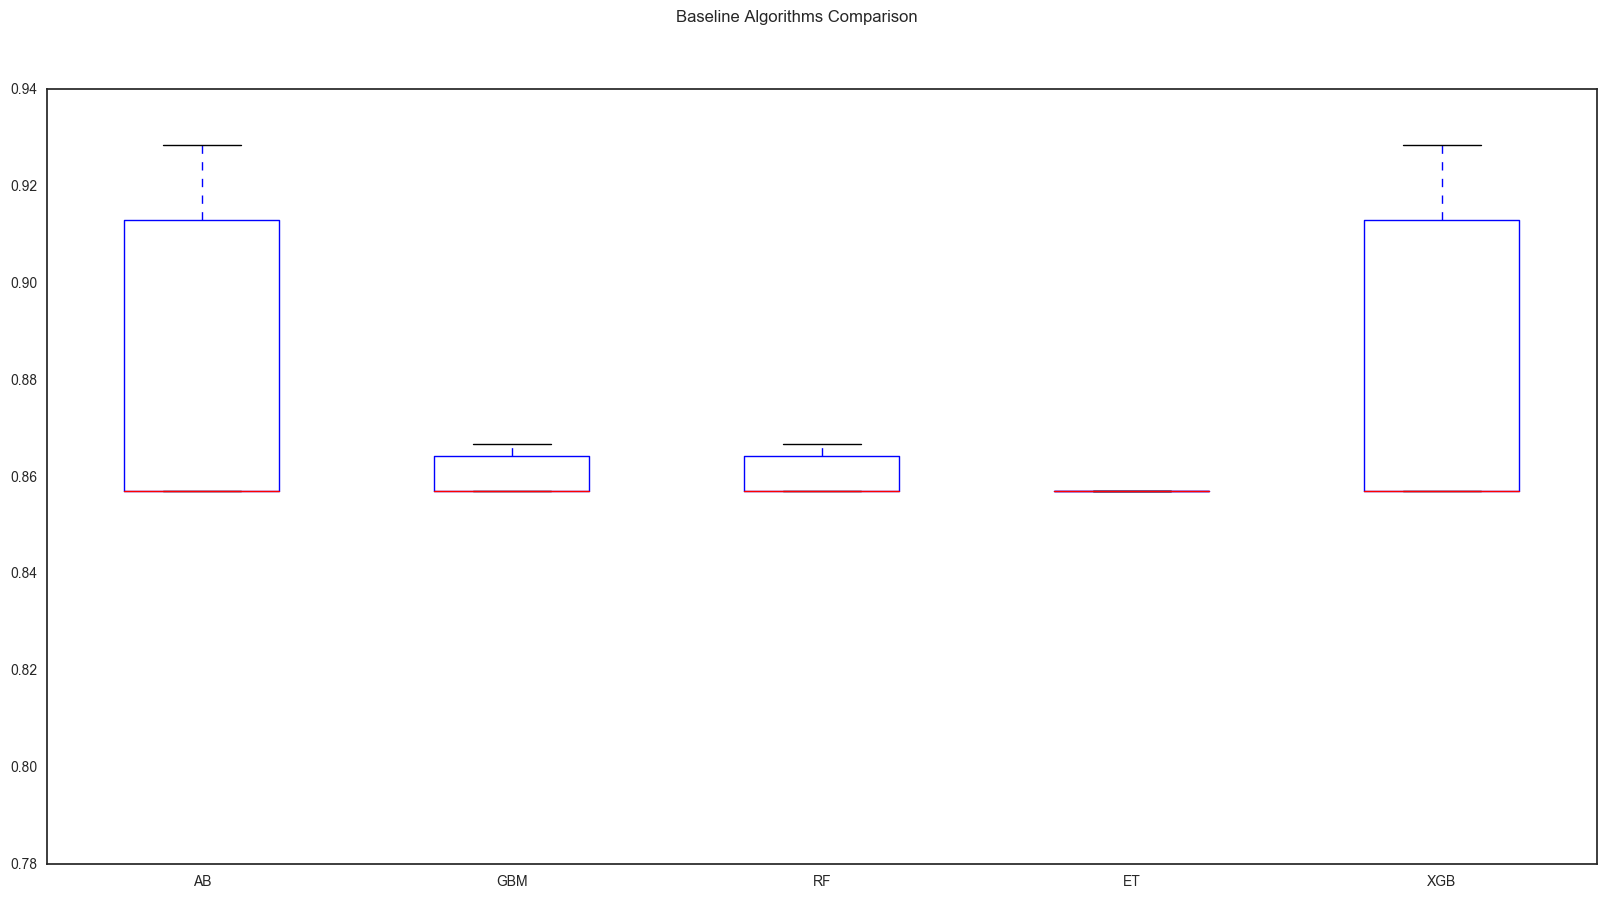

In [209]:
def ensemble_models(training_set, outcome):
    # Test options and evaluation metric
    num_folds = 10
    num_instances = len(training_set)
    seed = 7
    scoring = 'accuracy'

    # ensembles
    ensembles = []
    ensembles.append(('AB', AdaBoostClassifier()))
    ensembles.append(('GBM', GradientBoostingClassifier()))
    ensembles.append(('RF', RandomForestClassifier()))
    ensembles.append(('ET', ExtraTreesClassifier()))
    ensembles.append(('XGB', xgboost.XGBClassifier()))
    results = []
    names = []
    for name, model in ensembles:
        kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        cv_results = cross_validation.cross_val_score(model, training_set, outcome, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        plot_learning_curve(model, name, training_set, outcome, ylim=(0.5, 1.01), train_sizes=np.linspace(0.1, 1.0, 10) , cv=10)
    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Baseline Algorithms Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

ensemble_models(X_train_2, y_train)

## Model Validation

Validation based on LR
0.888888888889
[[15  2]
 [ 2 17]]
[[15  2]
 [ 2 17]]
             precision    recall  f1-score   support

          0       0.88      0.88      0.88        17
          1       0.89      0.89      0.89        19

avg / total       0.89      0.89      0.89        36



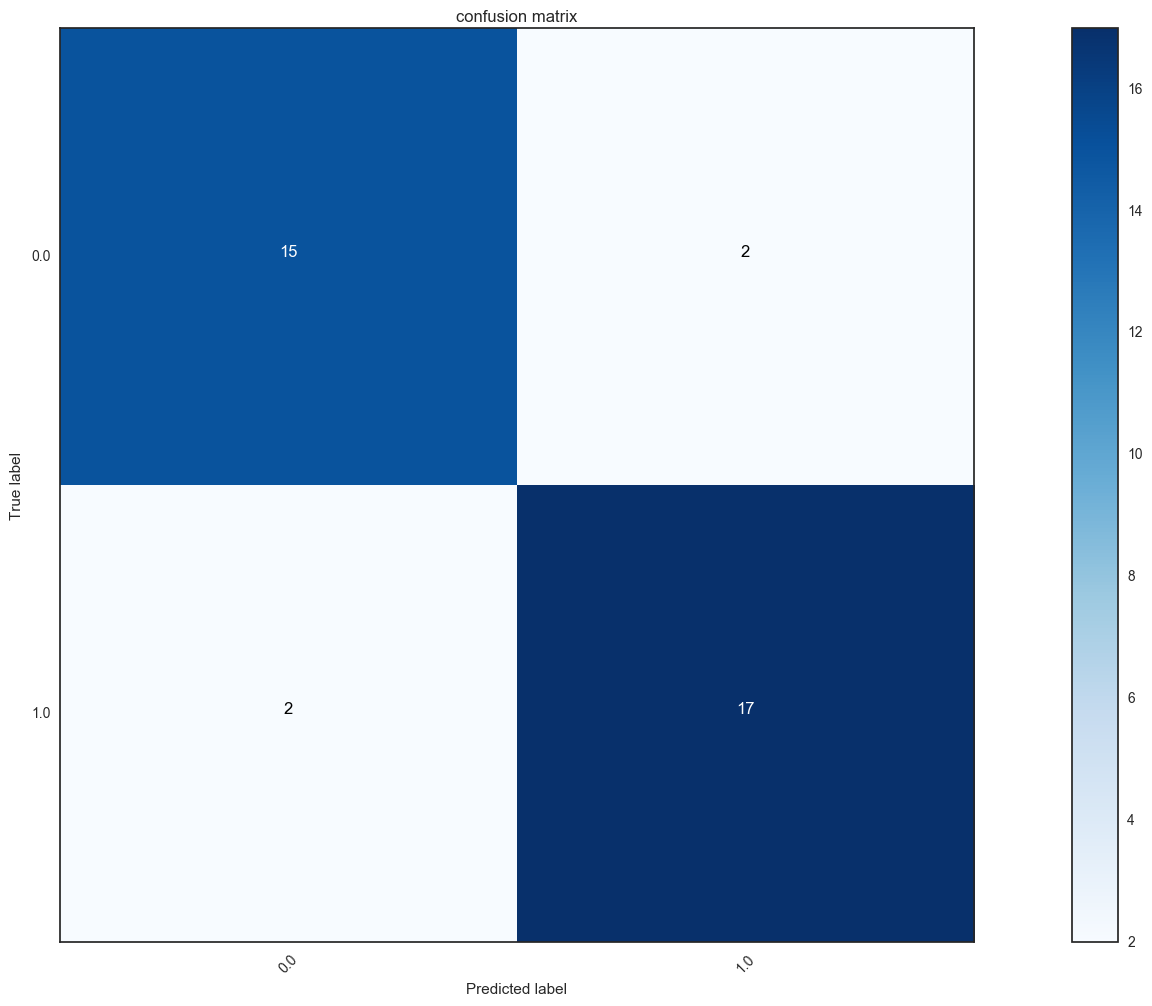

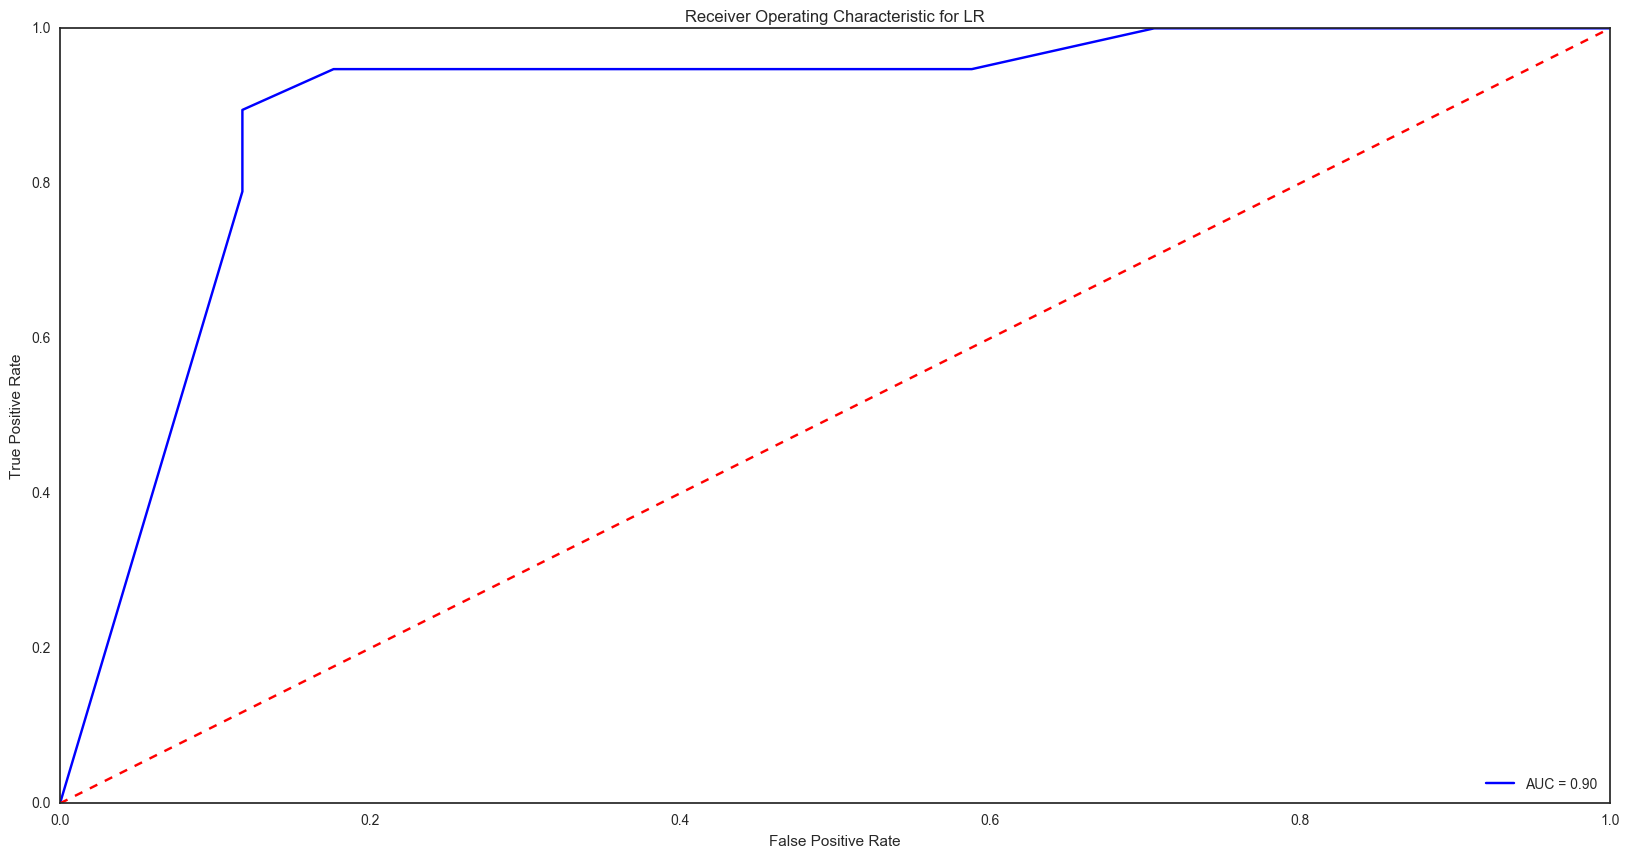

Validation based on LDA
0.833333333333
[[14  3]
 [ 3 16]]
[[14  3]
 [ 3 16]]
             precision    recall  f1-score   support

          0       0.82      0.82      0.82        17
          1       0.84      0.84      0.84        19

avg / total       0.83      0.83      0.83        36



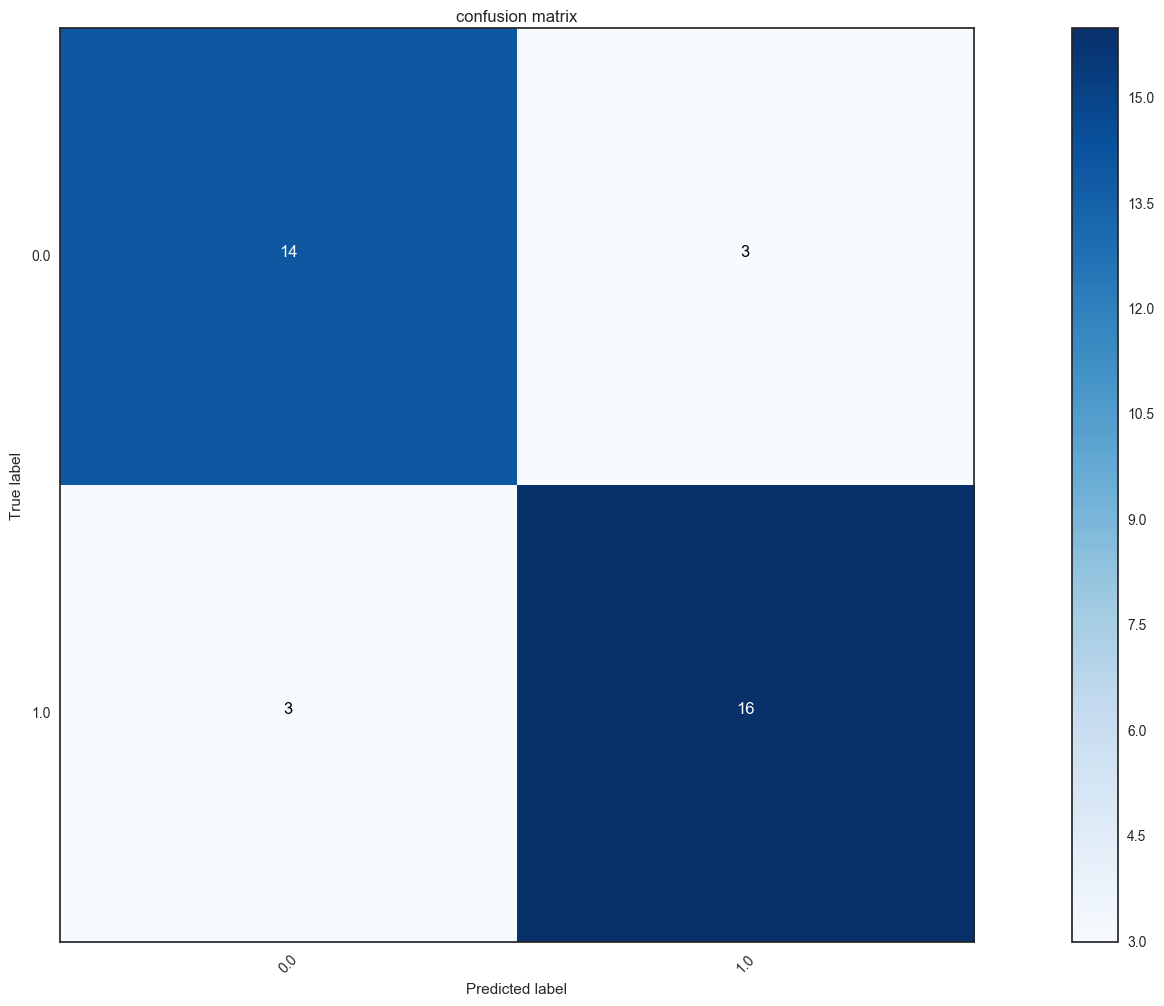

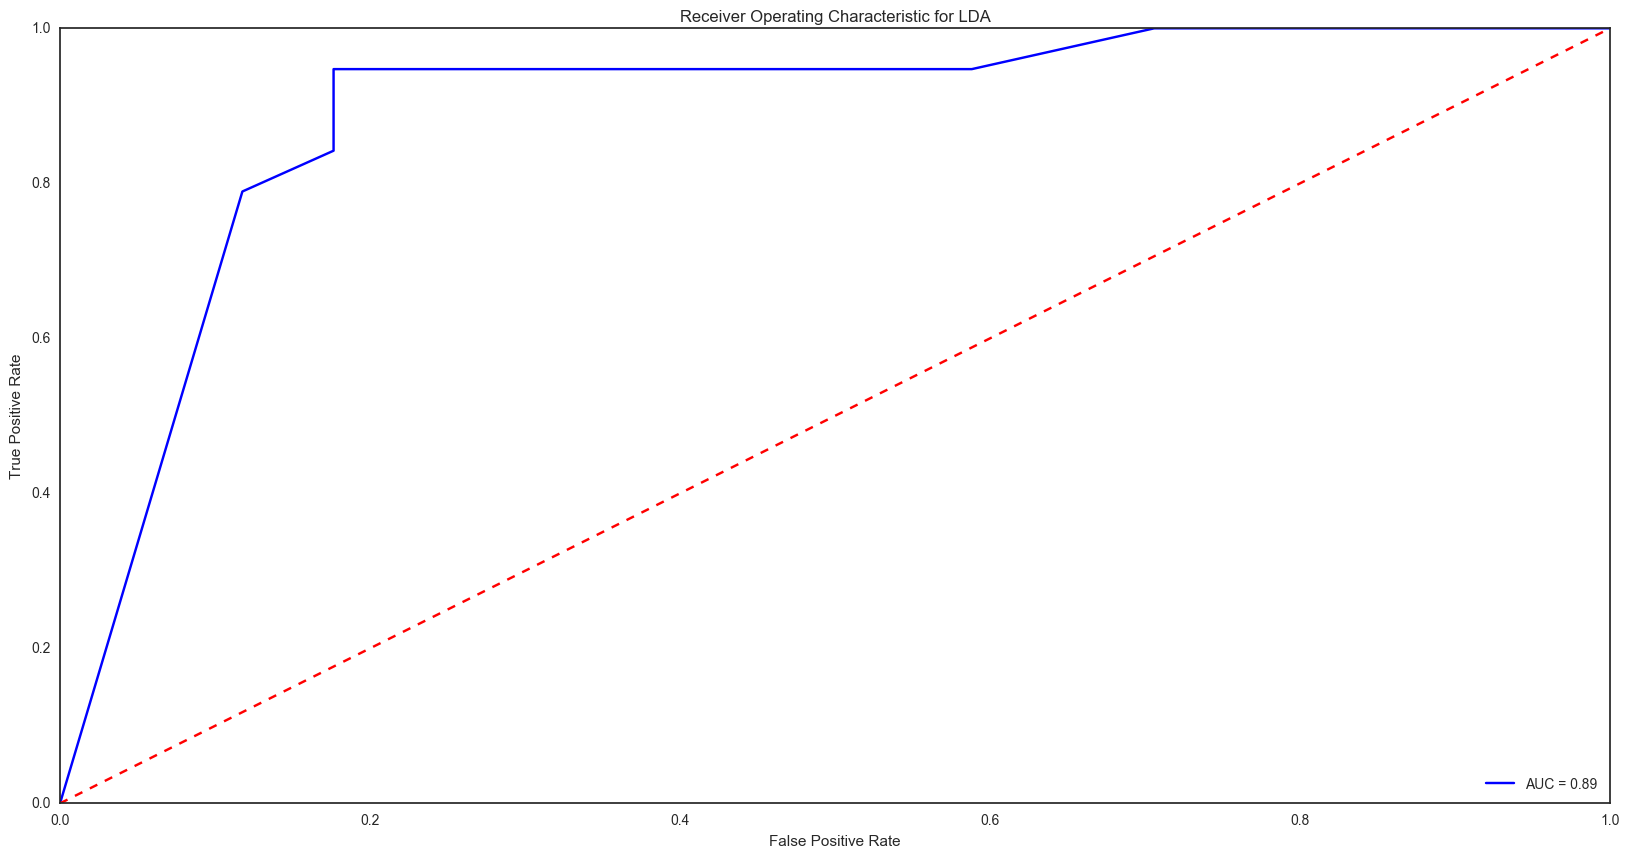

Validation based on KNN
0.888888888889
[[15  2]
 [ 2 17]]
[[15  2]
 [ 2 17]]
             precision    recall  f1-score   support

          0       0.88      0.88      0.88        17
          1       0.89      0.89      0.89        19

avg / total       0.89      0.89      0.89        36



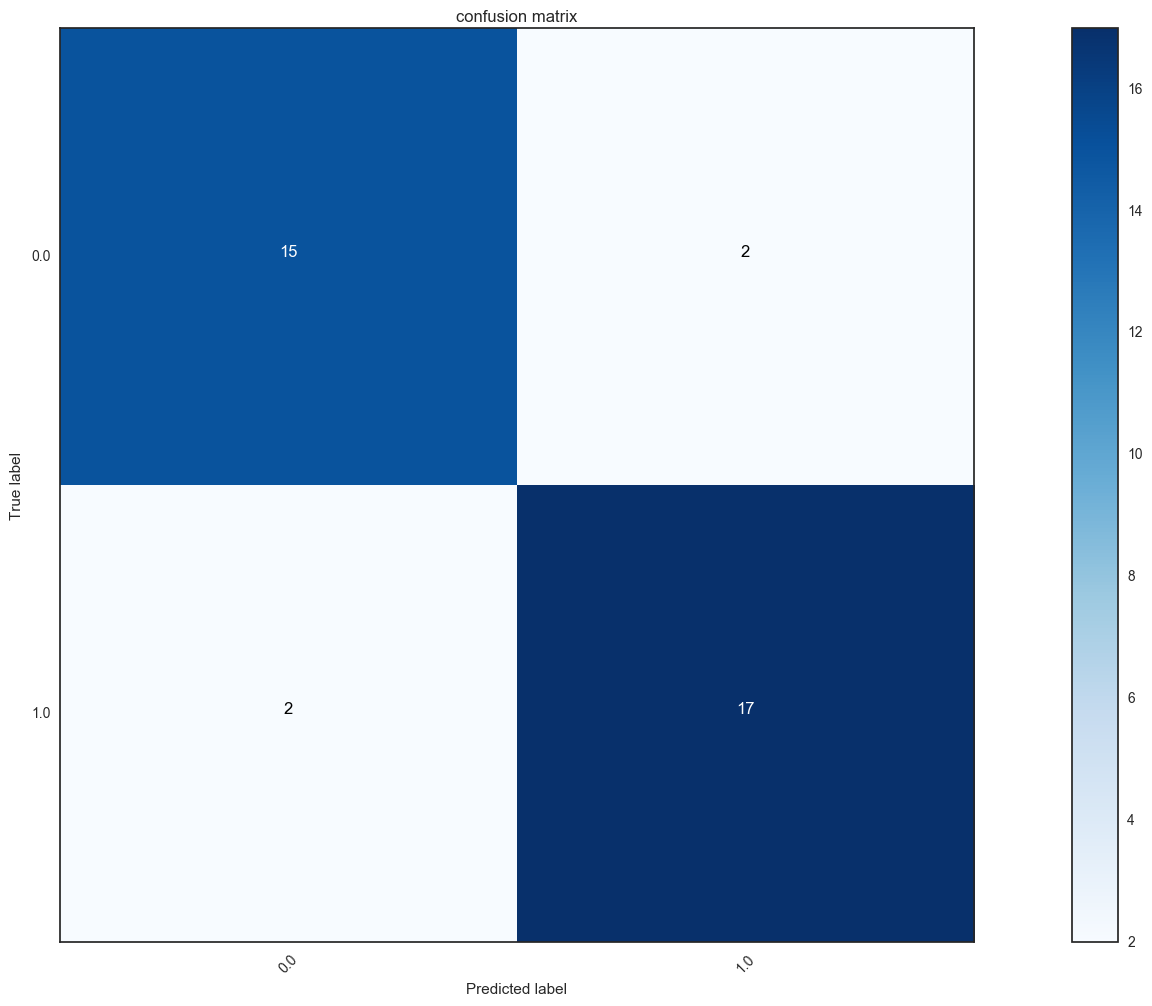

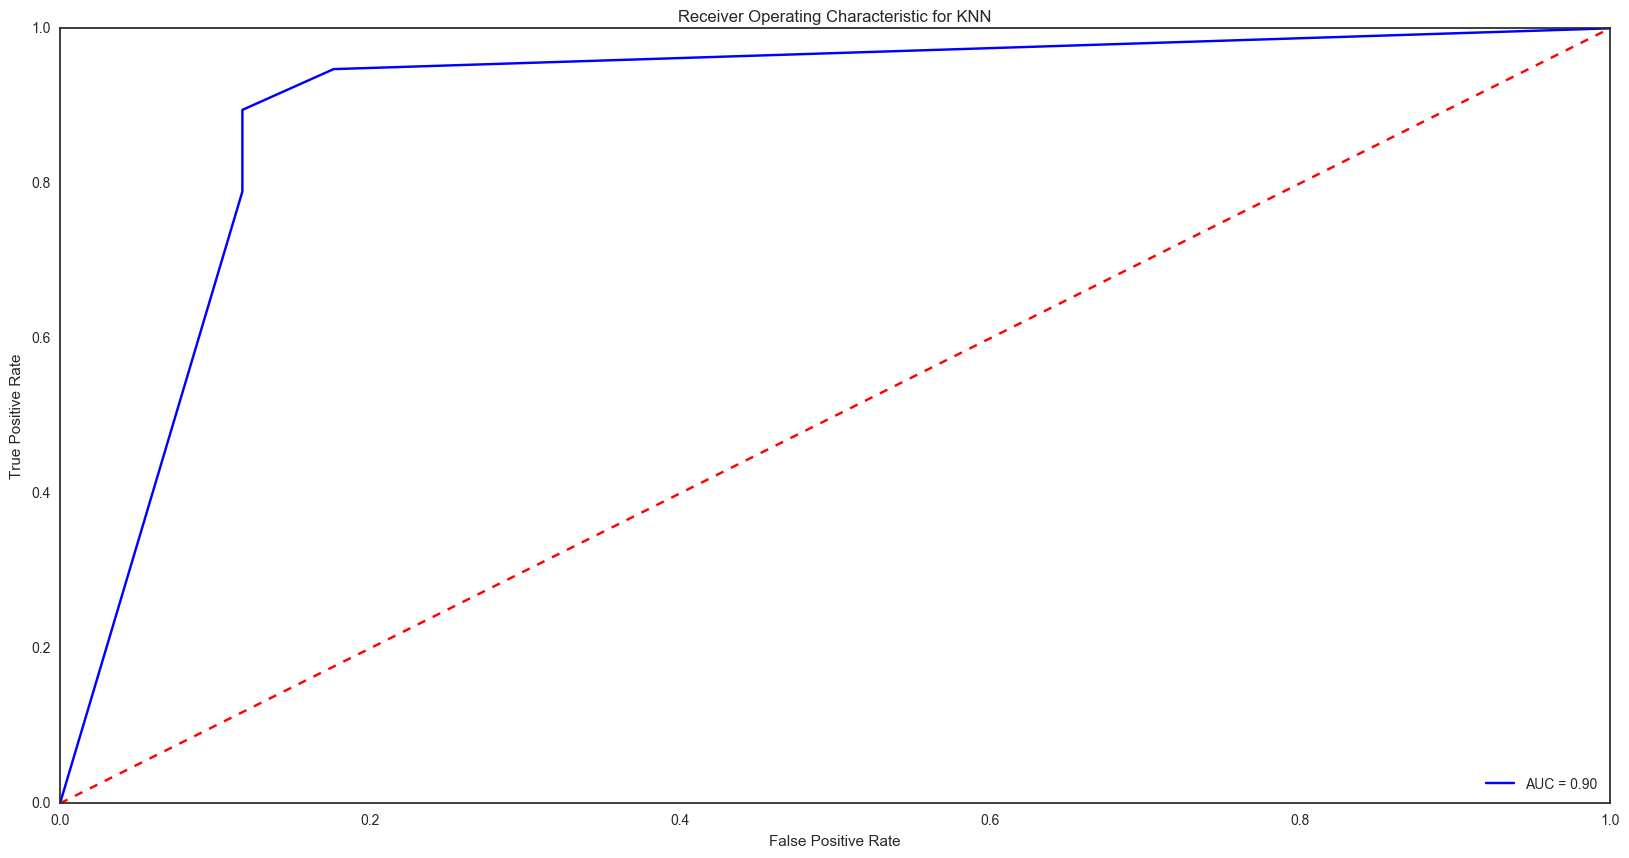

Validation based on CART
0.888888888889
[[15  2]
 [ 2 17]]
[[15  2]
 [ 2 17]]
             precision    recall  f1-score   support

          0       0.88      0.88      0.88        17
          1       0.89      0.89      0.89        19

avg / total       0.89      0.89      0.89        36



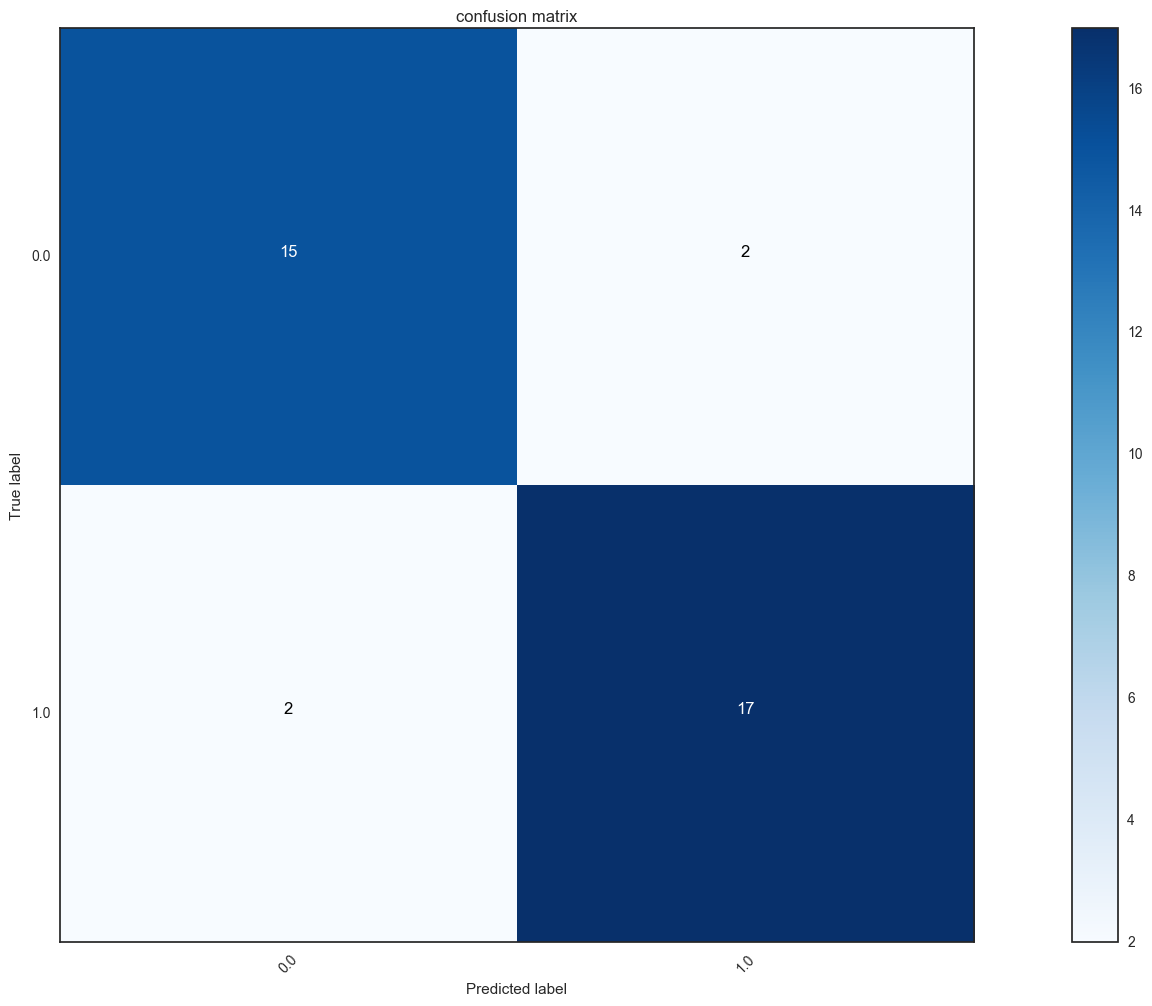

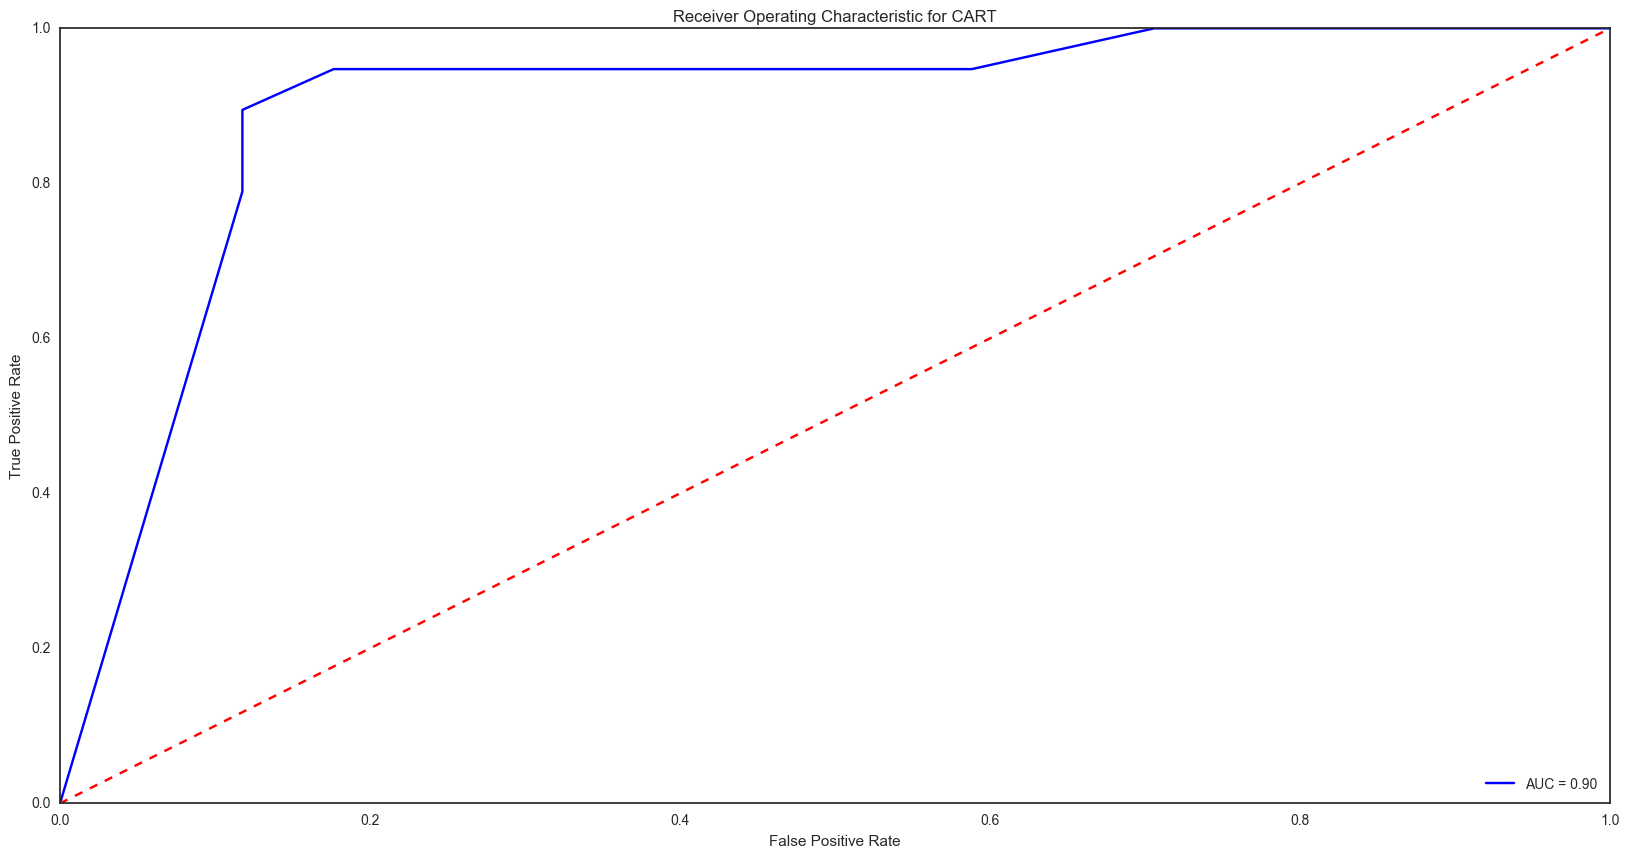

Validation based on NB
0.888888888889
[[15  2]
 [ 2 17]]
[[15  2]
 [ 2 17]]
             precision    recall  f1-score   support

          0       0.88      0.88      0.88        17
          1       0.89      0.89      0.89        19

avg / total       0.89      0.89      0.89        36



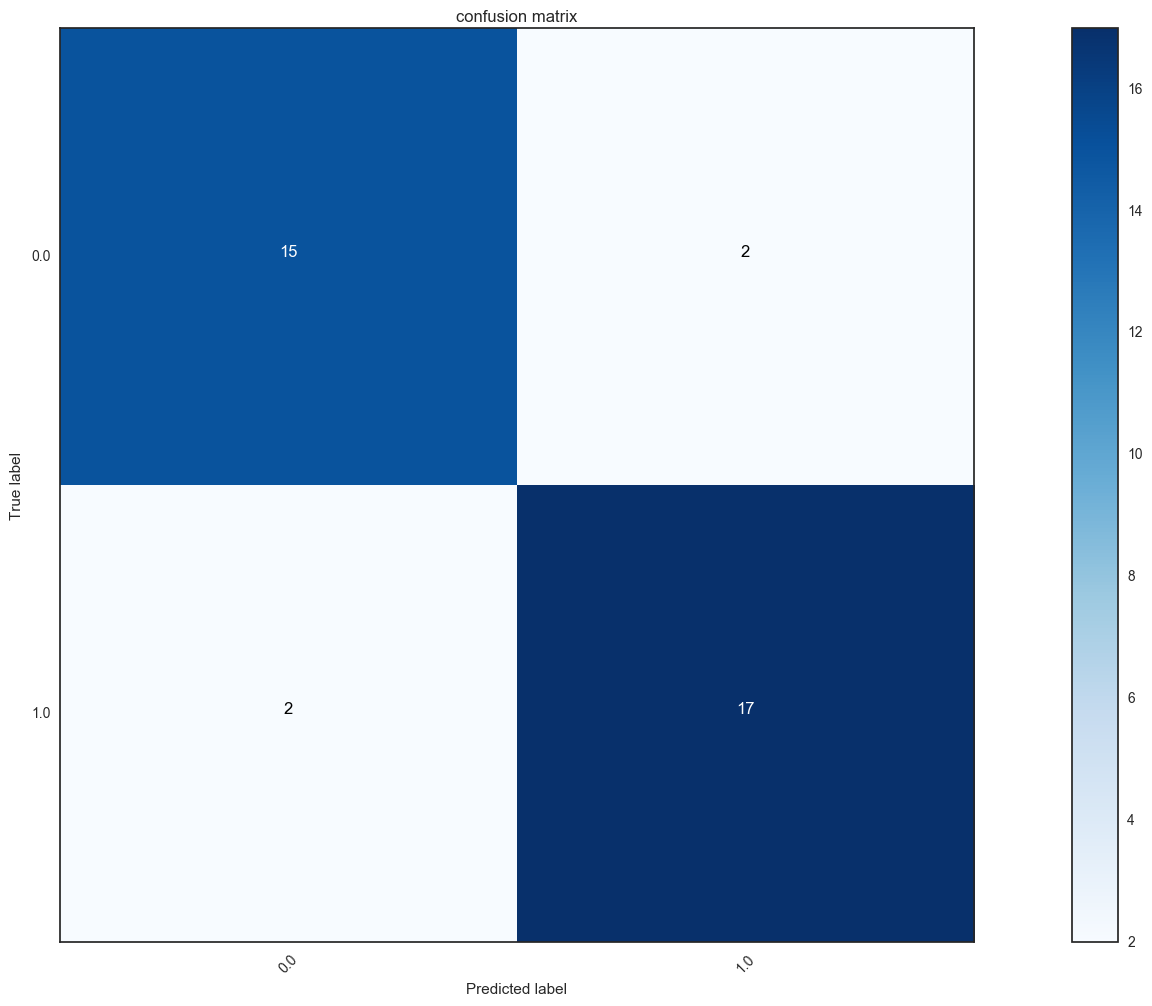

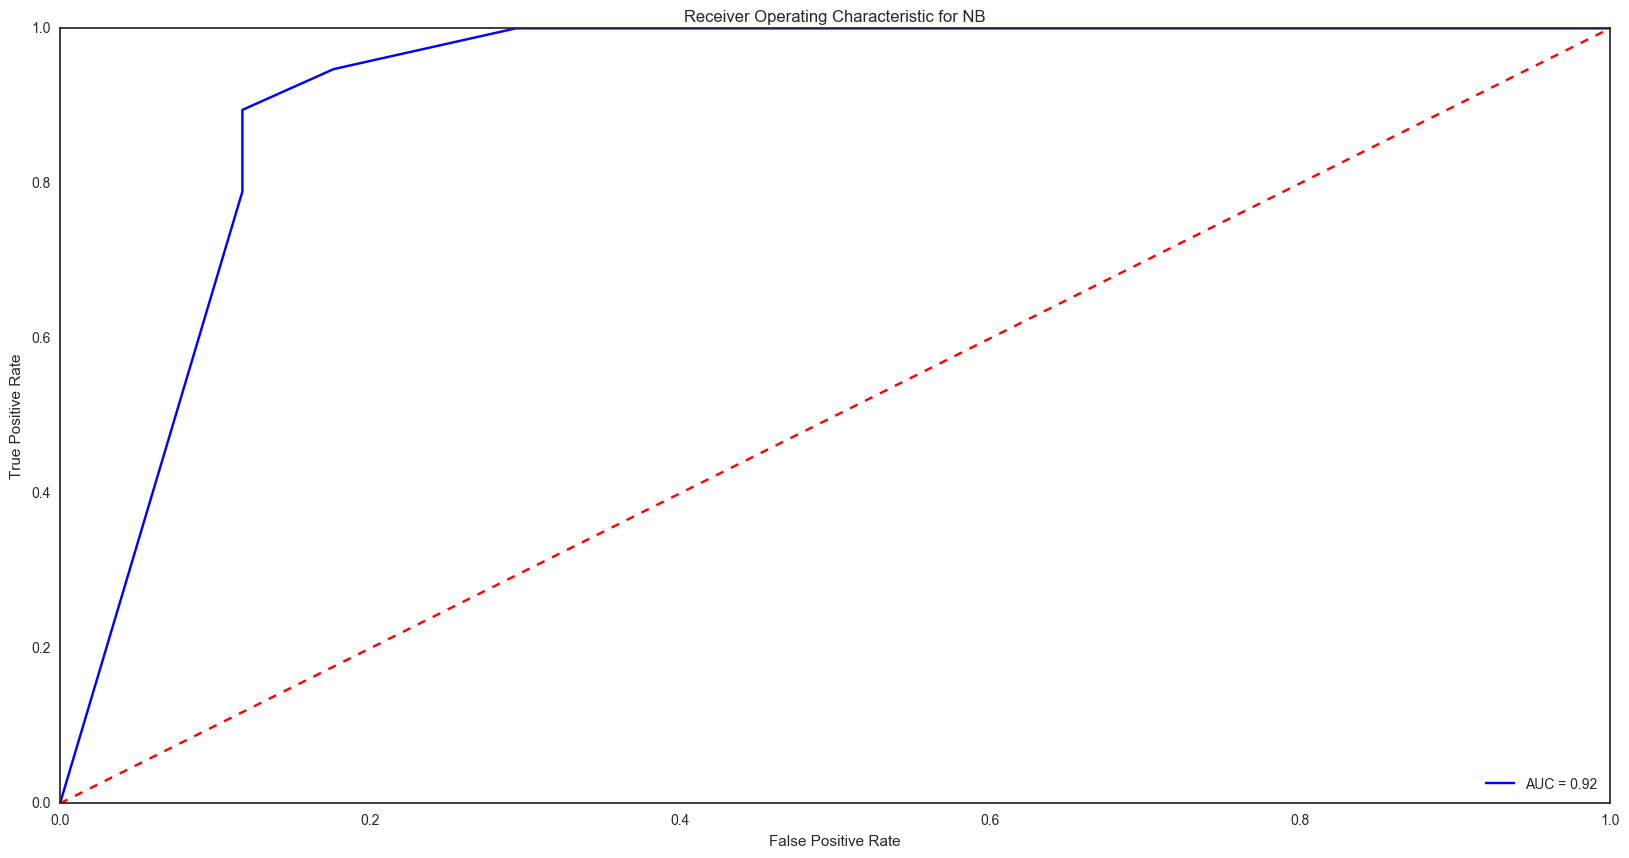

Validation based on SVM
0.888888888889
[[15  2]
 [ 2 17]]
[[15  2]
 [ 2 17]]
             precision    recall  f1-score   support

          0       0.88      0.88      0.88        17
          1       0.89      0.89      0.89        19

avg / total       0.89      0.89      0.89        36



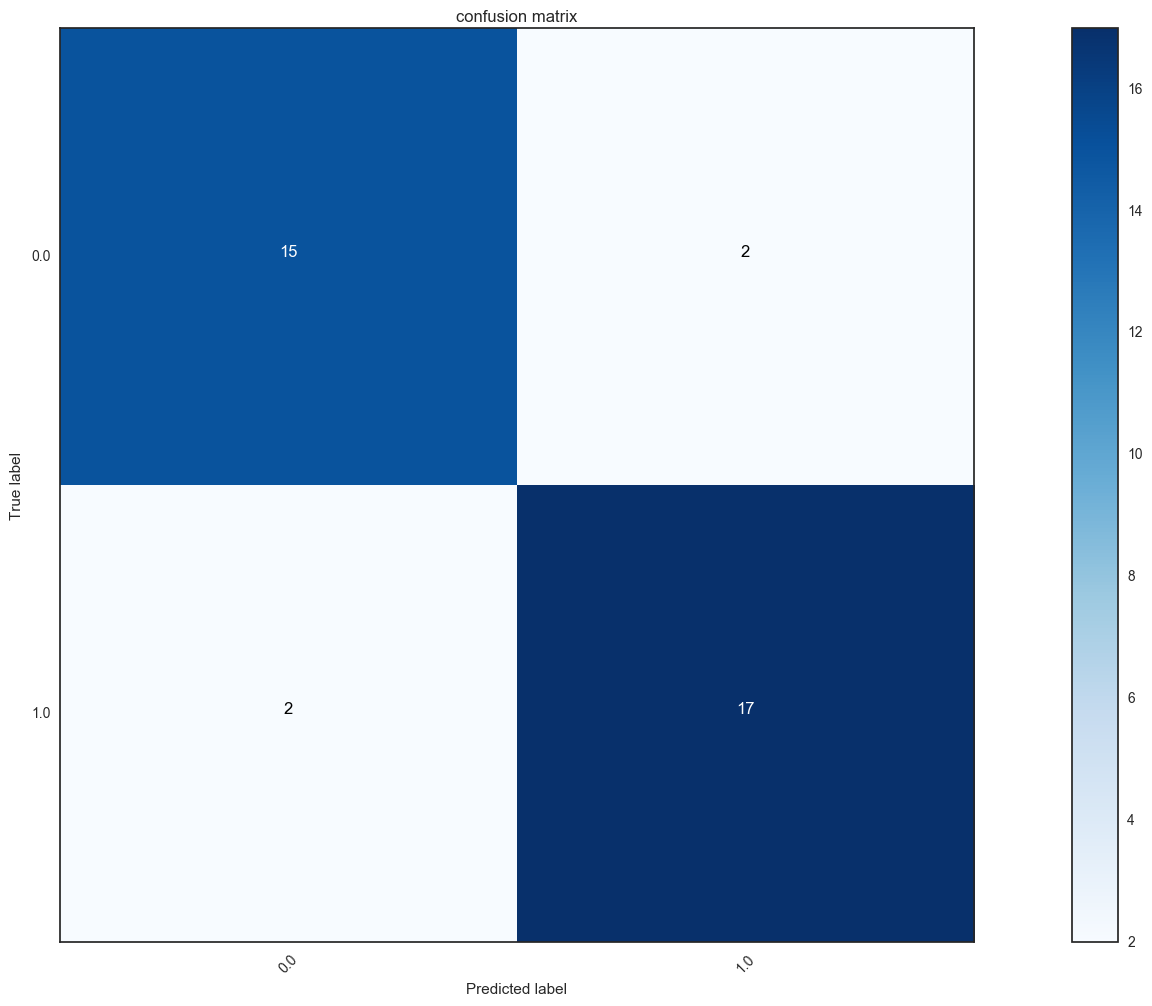

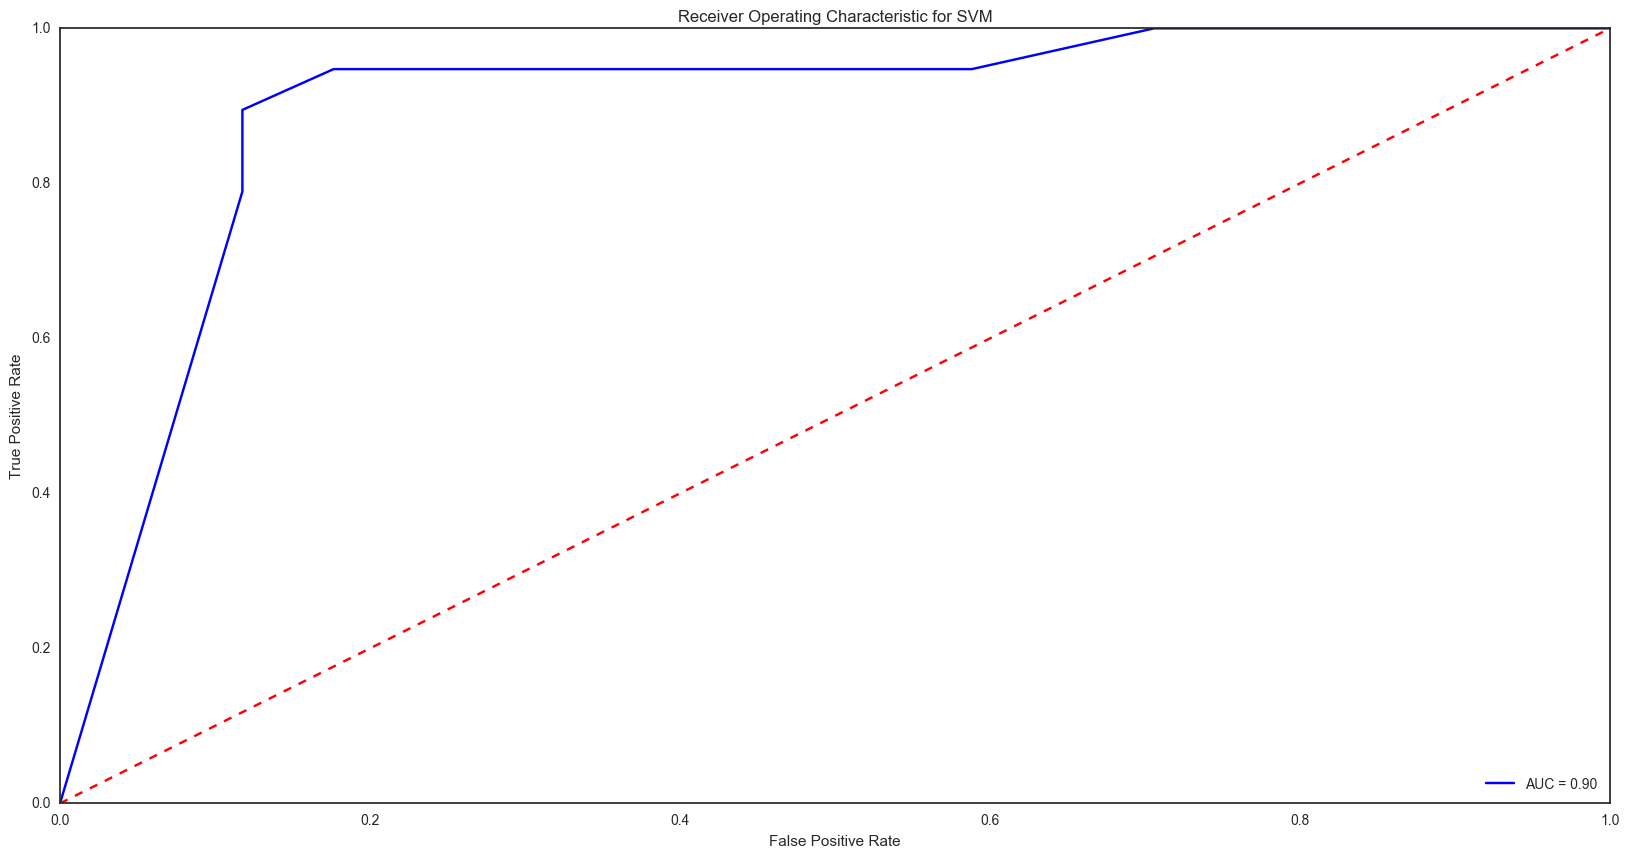

Validation based on AB
0.888888888889
[[15  2]
 [ 2 17]]
[[15  2]
 [ 2 17]]
             precision    recall  f1-score   support

          0       0.88      0.88      0.88        17
          1       0.89      0.89      0.89        19

avg / total       0.89      0.89      0.89        36



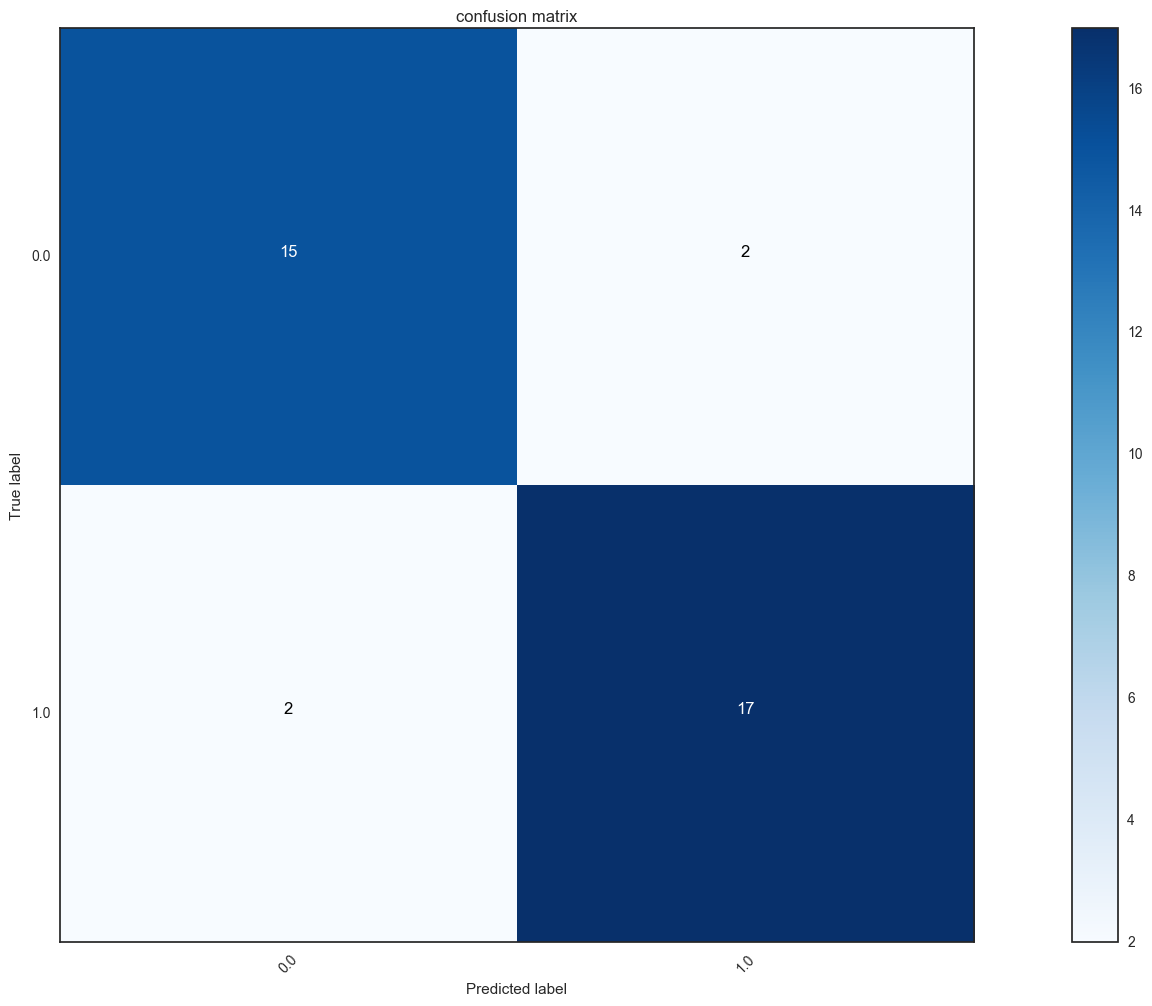

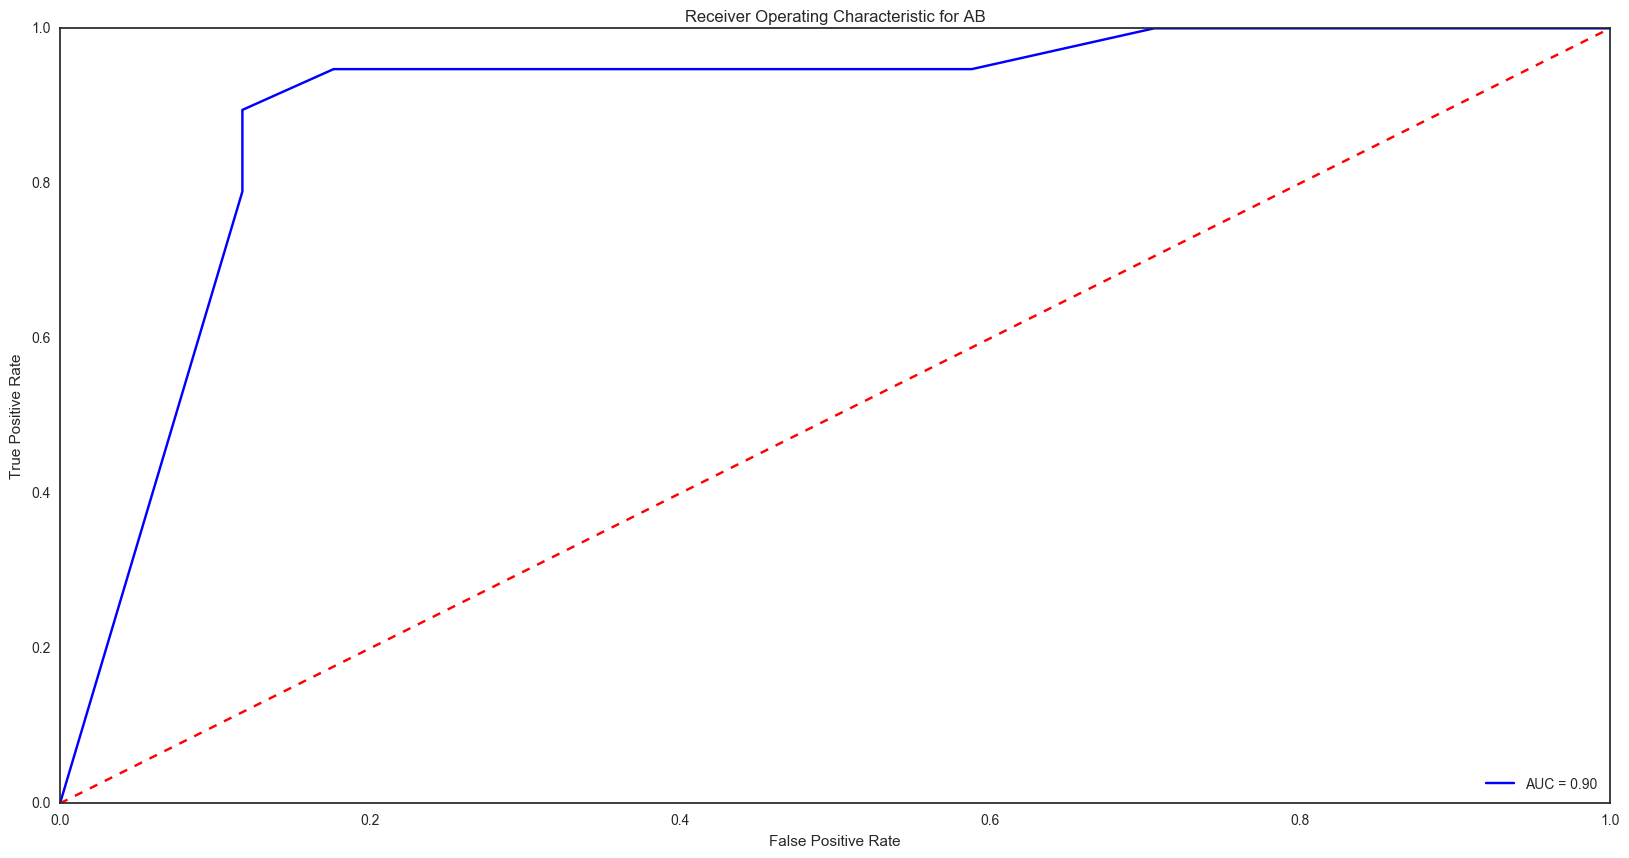

Validation based on GBM
0.888888888889
[[15  2]
 [ 2 17]]
[[15  2]
 [ 2 17]]
             precision    recall  f1-score   support

          0       0.88      0.88      0.88        17
          1       0.89      0.89      0.89        19

avg / total       0.89      0.89      0.89        36



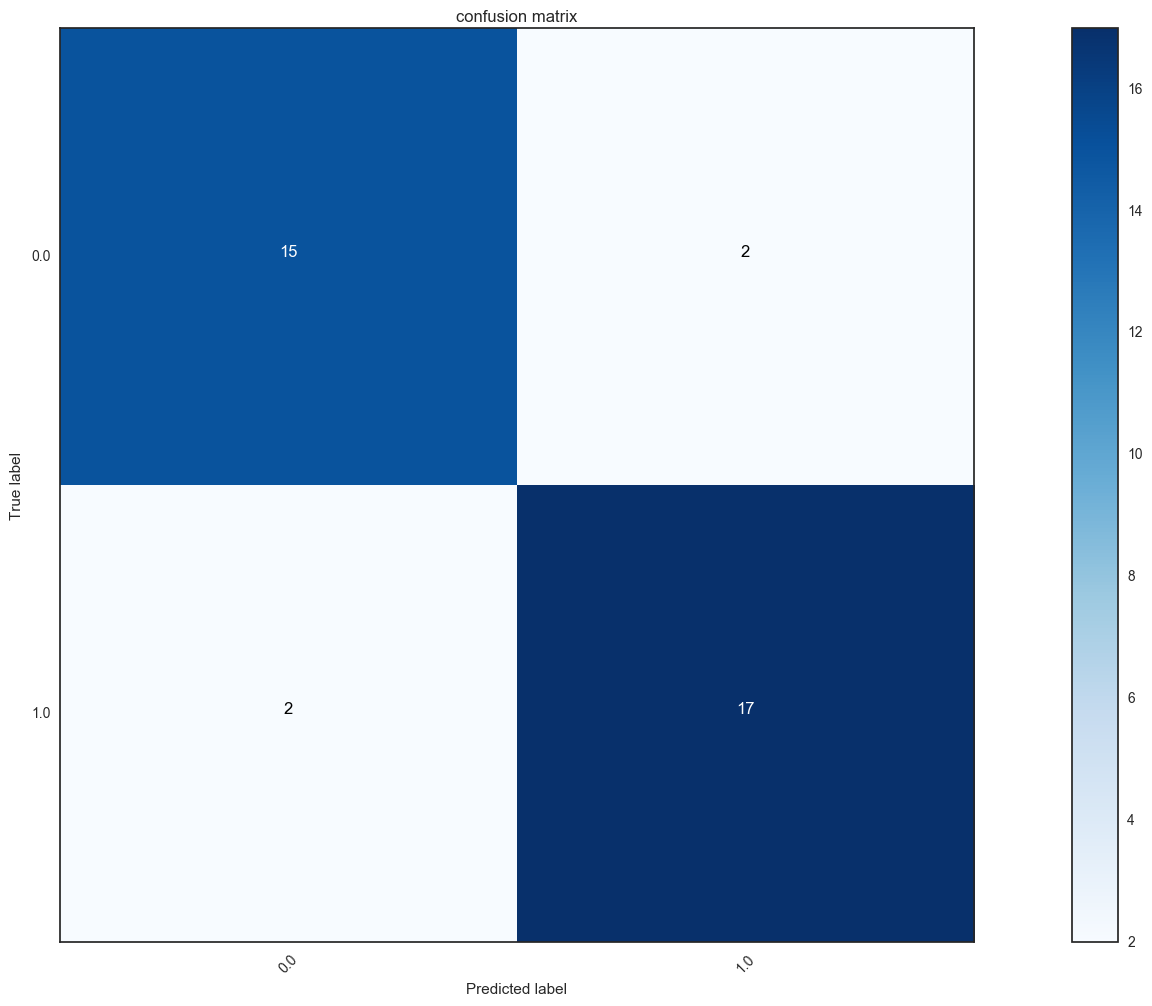

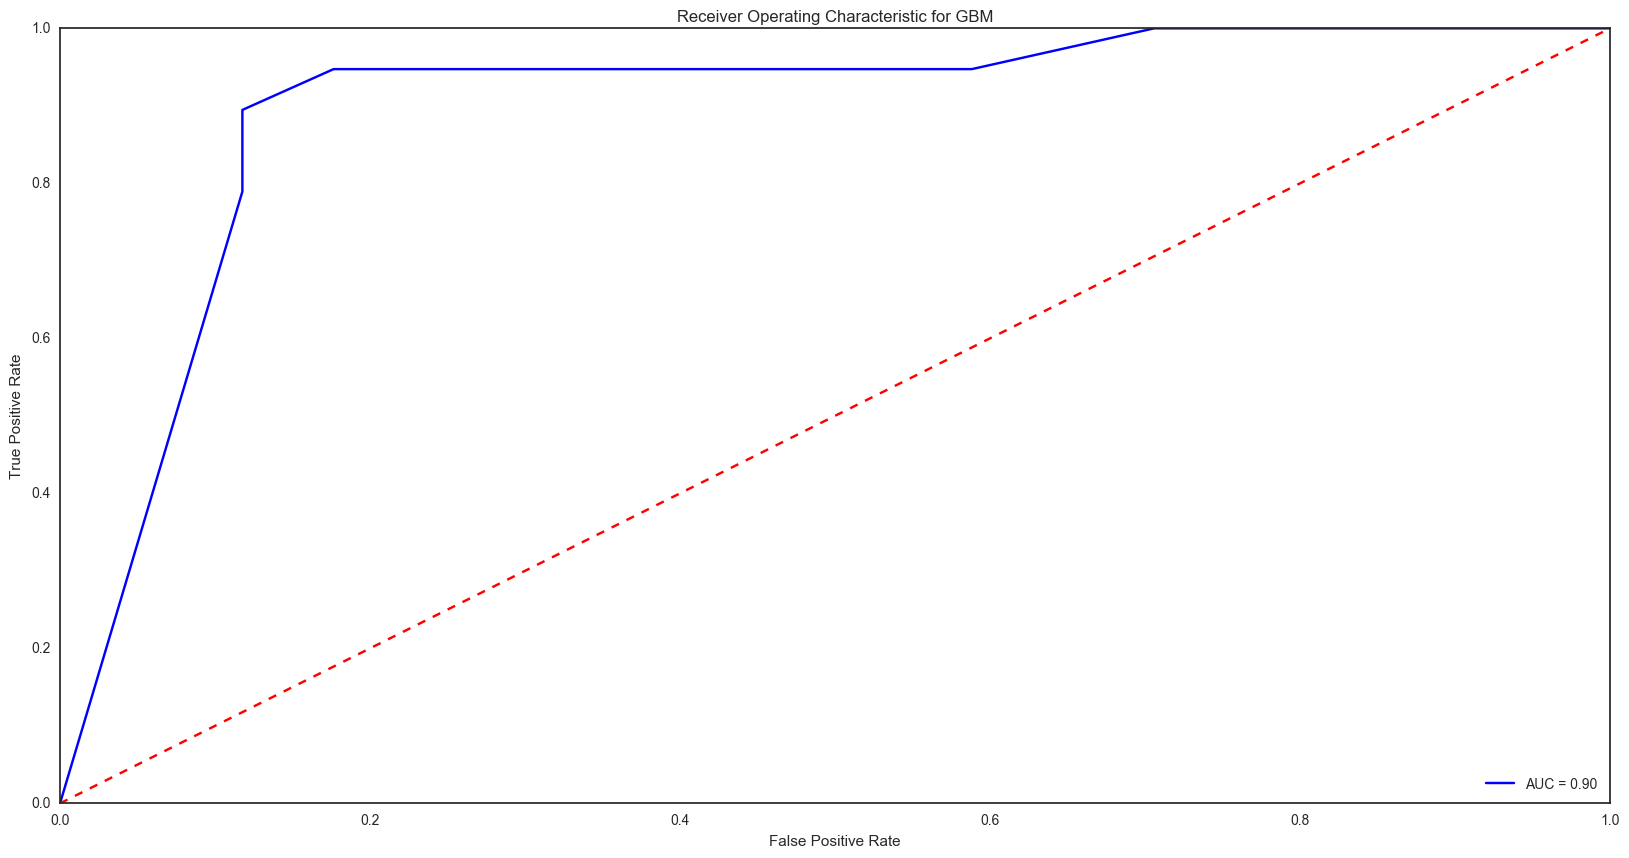

Validation based on RF
0.888888888889
[[15  2]
 [ 2 17]]
[[15  2]
 [ 2 17]]
             precision    recall  f1-score   support

          0       0.88      0.88      0.88        17
          1       0.89      0.89      0.89        19

avg / total       0.89      0.89      0.89        36



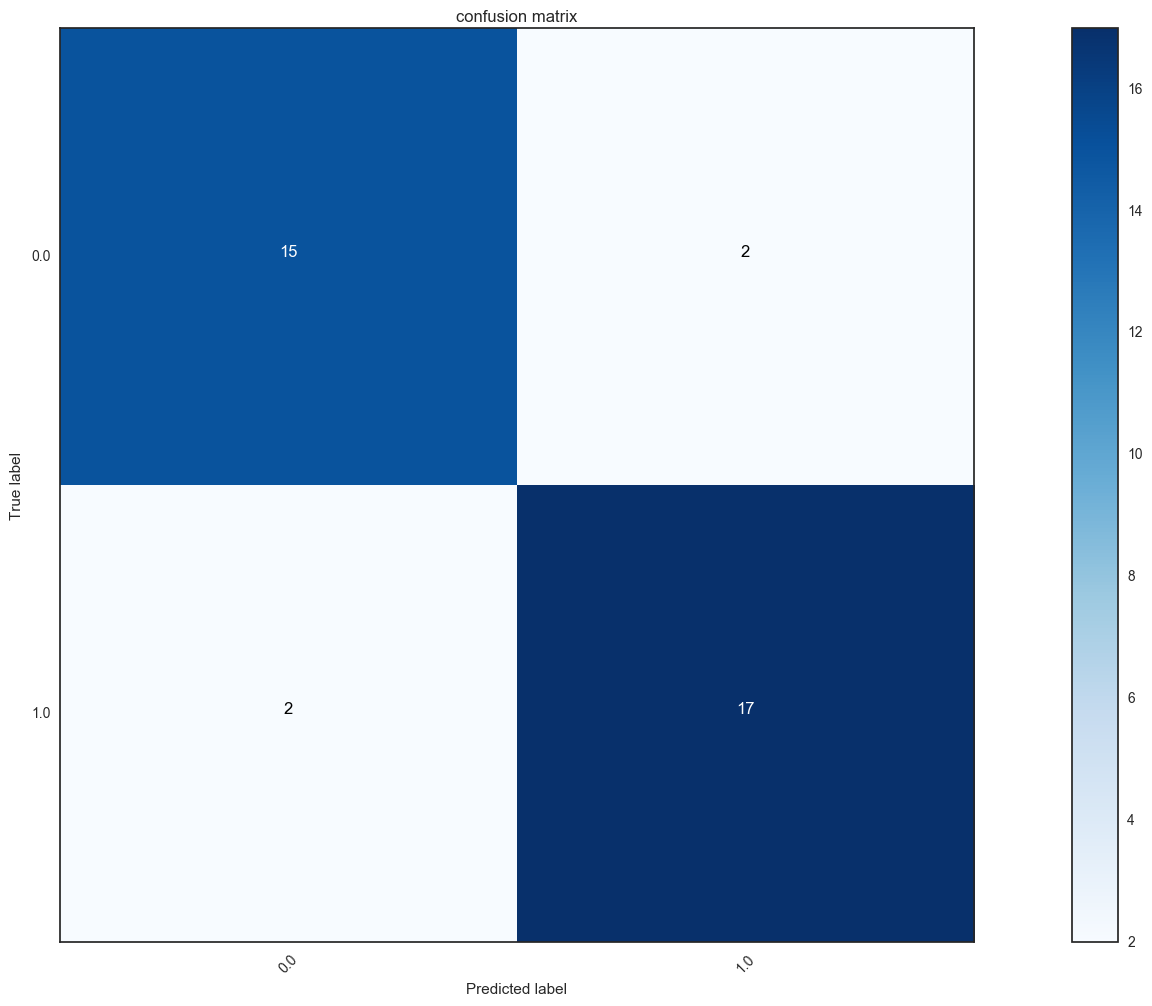

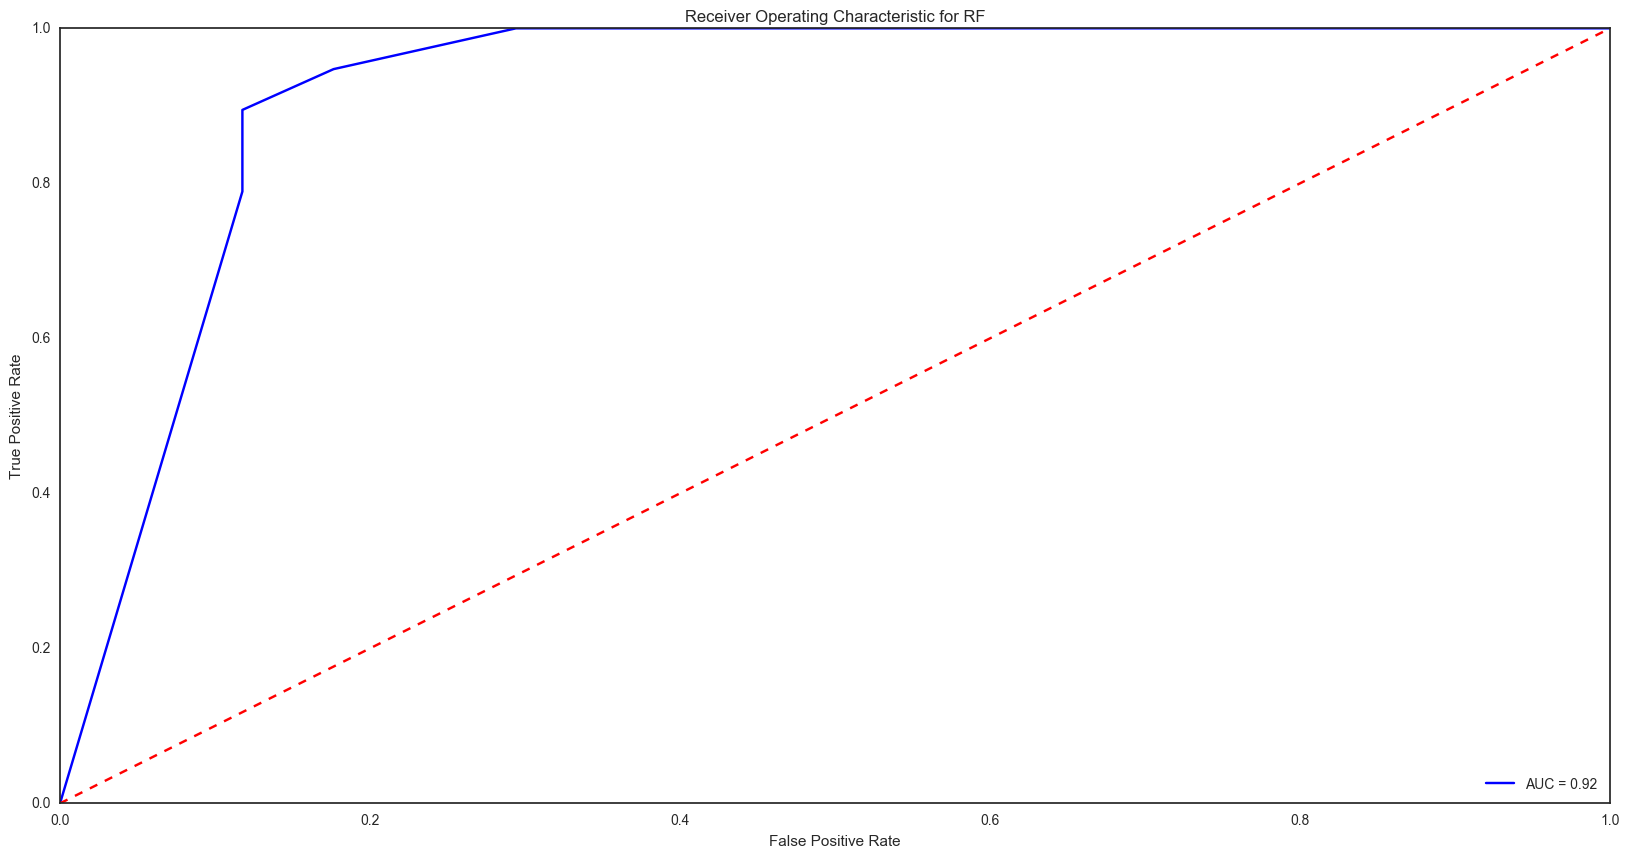

Validation based on ET
0.888888888889
[[15  2]
 [ 2 17]]
[[15  2]
 [ 2 17]]
             precision    recall  f1-score   support

          0       0.88      0.88      0.88        17
          1       0.89      0.89      0.89        19

avg / total       0.89      0.89      0.89        36



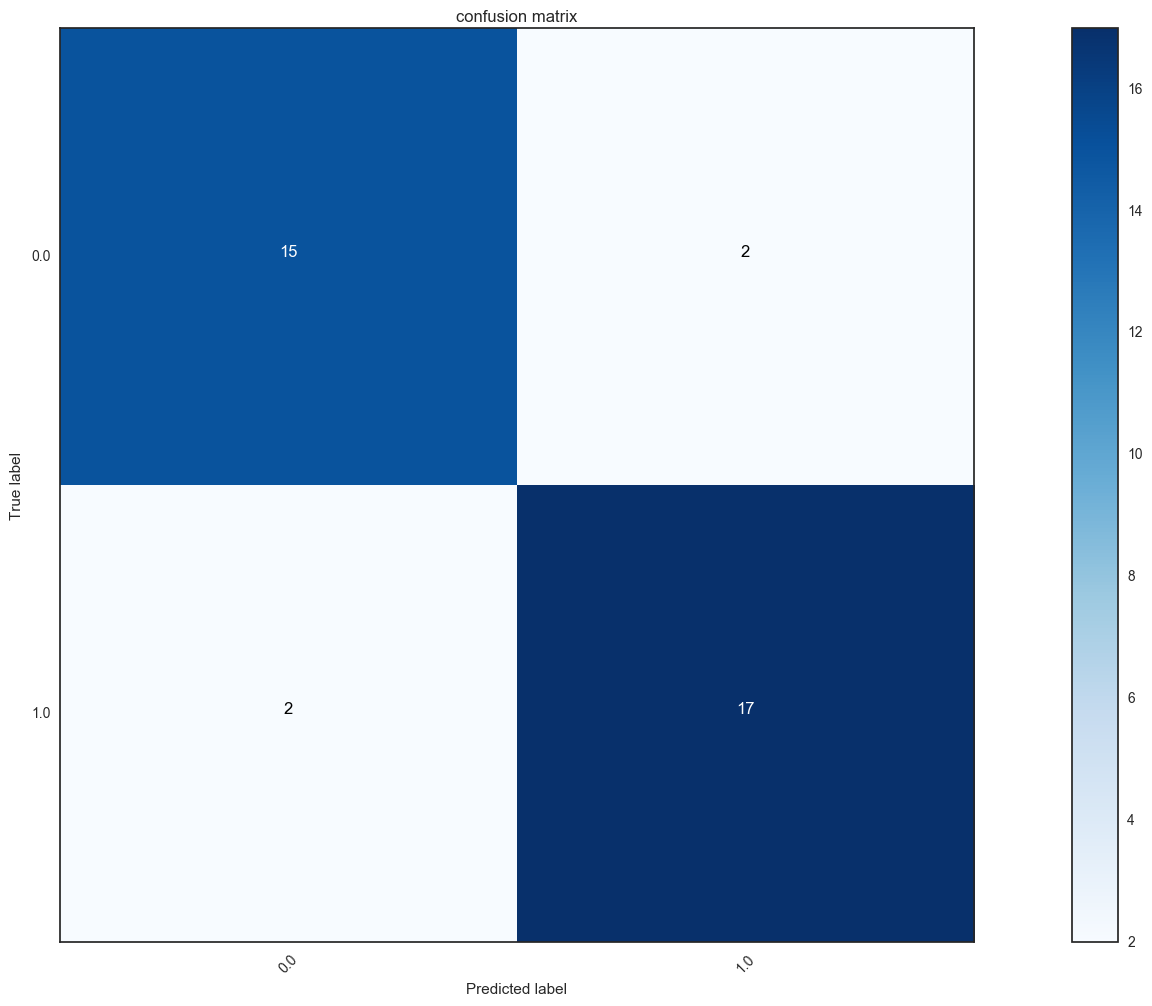

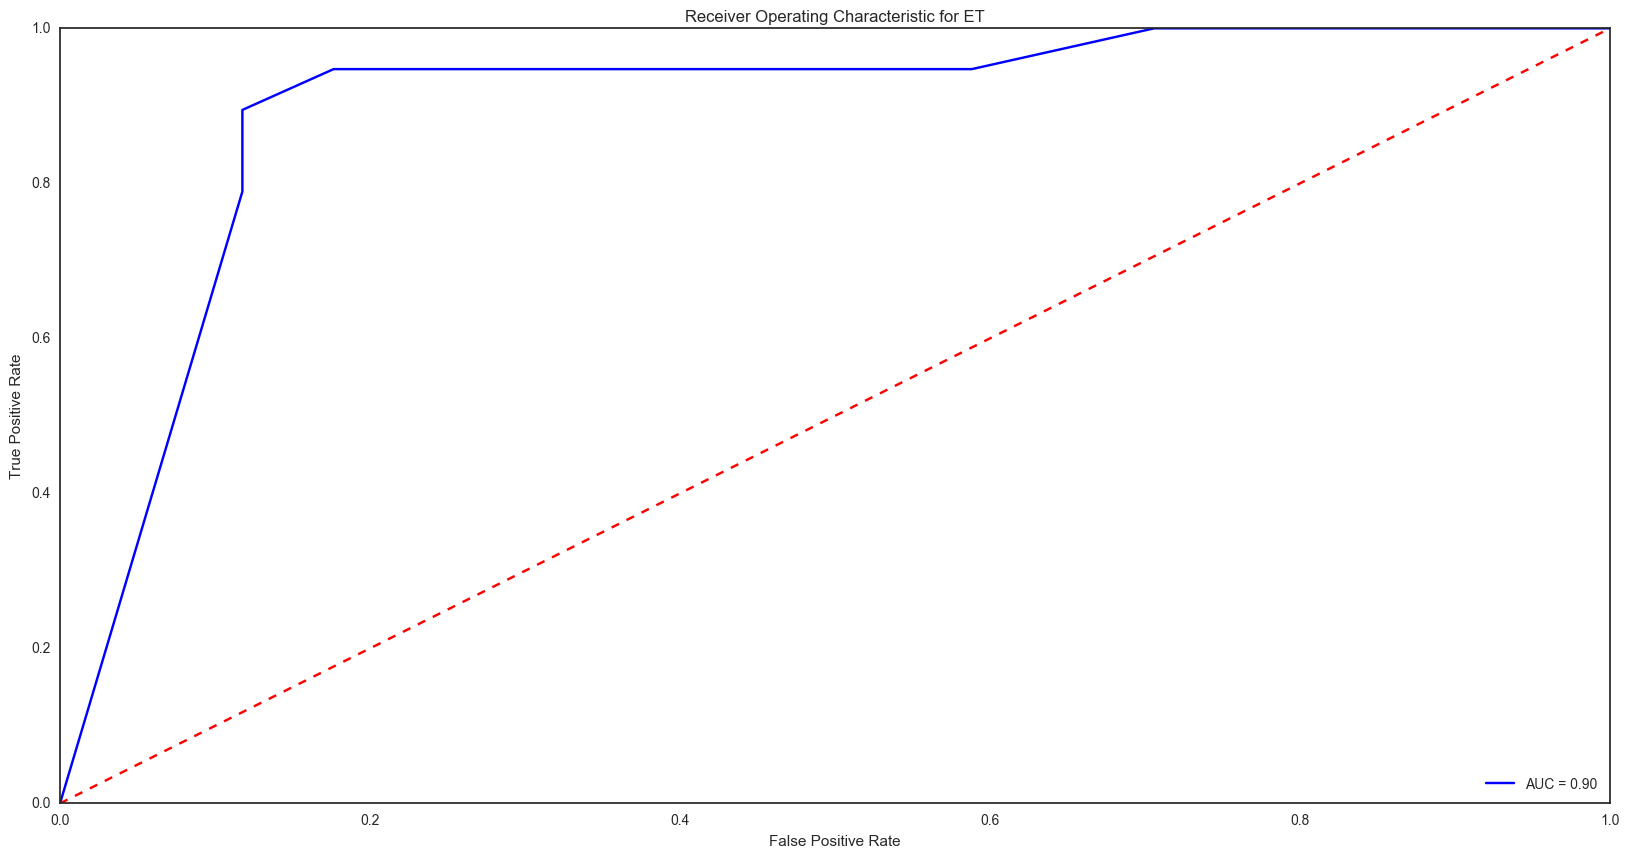

Validation based on XGB
0.888888888889
[[15  2]
 [ 2 17]]
[[15  2]
 [ 2 17]]
             precision    recall  f1-score   support

          0       0.88      0.88      0.88        17
          1       0.89      0.89      0.89        19

avg / total       0.89      0.89      0.89        36



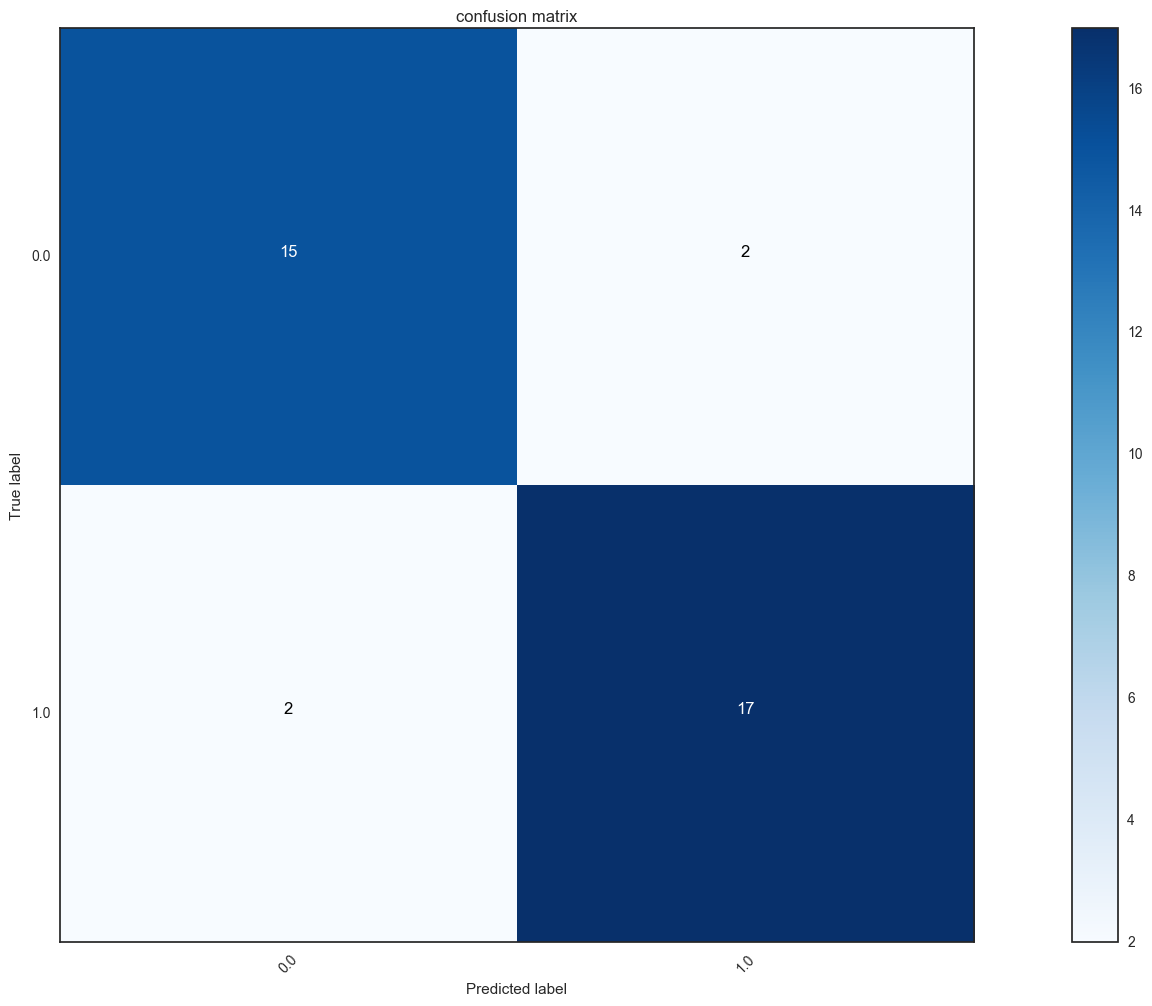

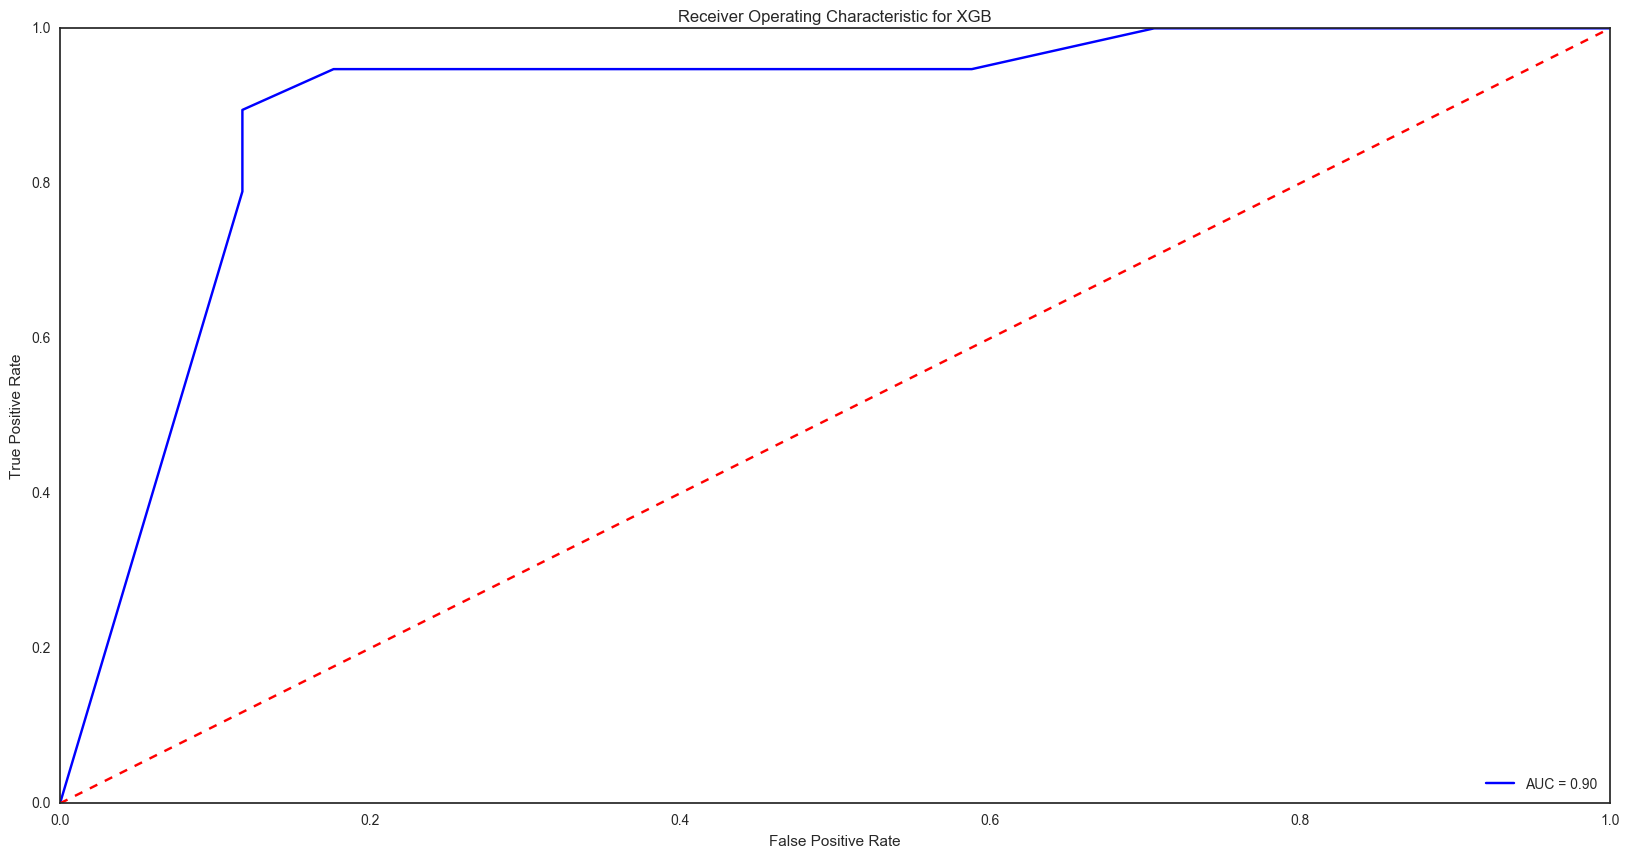

In [210]:
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(1)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def validate_models(training_set, outcome, validation_data, validation_outcome):
    
    models = []
    
    #baselines
    
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(probability=True)))
    
    #ensemble
    
    models.append(('AB', AdaBoostClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('ET', ExtraTreesClassifier()))
    models.append(('XGB', xgboost.XGBClassifier()))

    
    for name, model in models:
        mod = model
        mod.fit(training_set, outcome)
        # estimate accuracy on validation dataset
        predictions = mod.predict(validation_data)
        print "Validation based on " + name
        print(accuracy_score(validation_outcome, predictions))
        print(confusion_matrix(validation_outcome, predictions))
        cfmat = confusion_matrix(validation_outcome, predictions)
        plot_confusion_matrix(cfmat, classes=[0.0, 1.0] , title='confusion matrix')
        
        print(classification_report(validation_outcome, predictions))

        # calculate the fpr and tpr for all thresholds of the classification
        probs = mod.predict_proba(validation_data)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(validation_outcome, preds)
        roc_auc = auc(fpr, tpr)
        
        # method I: plt
        plt.figure(2)
        plt.title('Receiver Operating Characteristic for ' + name)
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
validate_models(X_train_2, y_train, X_val_2, y_val)

# Phase 2

In [211]:
X_test_2 = X_test[["v24.righting.response.high_rights", "v24.righting.response.low_rights", "v24.energy.high_non mobile"]]

In [167]:
scaler = StandardScaler().fit(X_train_2)
X_train_2_scaled = scaler.transform(X_train_2)
X_train_2_scaled

array([[ 0.66240132, -1.02150784, -1.14519667],
       [ 0.66240132, -1.02150784,  0.87321246],
       [ 0.66240132, -1.02150784,  0.87321246],
       [-1.50965882, -1.02150784, -1.14519667],
       [ 0.66240132,  0.97894501,  0.87321246],
       [ 0.66240132,  0.97894501,  0.87321246],
       [ 0.66240132, -1.02150784, -1.14519667],
       [ 0.66240132, -1.02150784,  0.87321246],
       [ 0.66240132,  0.97894501,  0.87321246],
       [ 0.66240132,  0.97894501, -1.14519667],
       [ 0.66240132, -1.02150784, -1.14519667],
       [ 0.66240132,  0.97894501, -1.14519667],
       [-1.50965882, -1.02150784, -1.14519667],
       [ 0.66240132,  0.97894501,  0.87321246],
       [-1.50965882, -1.02150784, -1.14519667],
       [ 0.66240132, -1.02150784,  0.87321246],
       [-1.50965882, -1.02150784, -1.14519667],
       [ 0.66240132,  0.97894501,  0.87321246],
       [ 0.66240132,  0.97894501,  0.87321246],
       [-1.50965882, -1.02150784, -1.14519667],
       [ 0.66240132,  0.97894501, -1.145

In [213]:
#testing_set = X_test_2
#outcome = y_test
#validation_data = X_validation
#validation_outcome = Y_validation

mod = xgboost.XGBClassifier(n_estimators=1000)
#mod = LogisticRegression()
mod.fit(X_train_2, y_train)



XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [214]:
predicted = mod.predict(X_val_2)
print predicted

[0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0]


In [215]:
probs = mod.predict_proba(X_val_2)
print probs

[[ 0.99631226  0.00368775]
 [ 0.0819869   0.9180131 ]
 [ 0.99631226  0.00368775]
 [ 0.0819869   0.9180131 ]
 [ 0.0819869   0.9180131 ]
 [ 0.0819869   0.9180131 ]
 [ 0.0819869   0.9180131 ]
 [ 0.0819869   0.9180131 ]
 [ 0.93106174  0.06893826]
 [ 0.92143792  0.07856207]
 [ 0.92143792  0.07856207]
 [ 0.0819869   0.9180131 ]
 [ 0.0819869   0.9180131 ]
 [ 0.0819869   0.9180131 ]
 [ 0.92143792  0.07856207]
 [ 0.41653508  0.58346492]
 [ 0.99631226  0.00368775]
 [ 0.92143792  0.07856207]
 [ 0.93106174  0.06893826]
 [ 0.0819869   0.9180131 ]
 [ 0.41653508  0.58346492]
 [ 0.0819869   0.9180131 ]
 [ 0.0819869   0.9180131 ]
 [ 0.99631226  0.00368775]
 [ 0.0819869   0.9180131 ]
 [ 0.92143792  0.07856207]
 [ 0.0819869   0.9180131 ]
 [ 0.0819869   0.9180131 ]
 [ 0.63601947  0.3639805 ]
 [ 0.99631226  0.00368775]
 [ 0.0819869   0.9180131 ]
 [ 0.0819869   0.9180131 ]
 [ 0.63601947  0.3639805 ]
 [ 0.93106174  0.06893826]
 [ 0.92143792  0.07856207]
 [ 0.92143792  0.07856207]]


In [216]:
# generate evaluation metrics
print accuracy_score(y_val, predicted)
print roc_auc_score(y_val, probs[:, 1])

0.888888888889
0.899380804954


In [217]:
print confusion_matrix(y_val, predicted)
print classification_report(y_val, predicted)

[[15  2]
 [ 2 17]]
             precision    recall  f1-score   support

          0       0.88      0.88      0.88        17
          1       0.89      0.89      0.89        19

avg / total       0.89      0.89      0.89        36



In [218]:
def test_model(model, testing_data, truth):
    predicted = model.predict(testing_data)
    print "Predicted output" 
    print predicted
    probs = mod.predict_proba(testing_data)
    print zip(predicted, probs) 
    print "Accuracy :" + str(accuracy_score(truth, predicted))
    print "Classification Report :"
    print classification_report(truth, predicted) 
    print confusion_matrix(truth, predicted)

In [219]:
#scaler = StandardScaler().fit(X_test_2)
#X_test_2_scaled = scaler.transform(X_test_2)
#X_test_2_scaled

test_model(mod, X_test_2, y_test)

Predicted output
[0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 1 0
 0 1 1 0 0 0 1 0]
[(0, array([ 0.99631226,  0.00368775], dtype=float32)), (0, array([ 0.63601947,  0.3639805 ], dtype=float32)), (1, array([ 0.41653508,  0.58346492], dtype=float32)), (1, array([ 0.0819869,  0.9180131], dtype=float32)), (1, array([ 0.41653508,  0.58346492], dtype=float32)), (1, array([ 0.0819869,  0.9180131], dtype=float32)), (0, array([ 0.99631226,  0.00368775], dtype=float32)), (1, array([ 0.41653508,  0.58346492], dtype=float32)), (1, array([ 0.0819869,  0.9180131], dtype=float32)), (1, array([ 0.0819869,  0.9180131], dtype=float32)), (1, array([ 0.0819869,  0.9180131], dtype=float32)), (1, array([ 0.0819869,  0.9180131], dtype=float32)), (0, array([ 0.93106174,  0.06893826], dtype=float32)), (0, array([ 0.92143792,  0.07856207], dtype=float32)), (0, array([ 0.92143792,  0.07856207], dtype=float32)), (1, array([ 0.0819869,  0.9180131], dtype=float32)), (1, array([ 0.0819869, 